# Time-series Forecasting Using Facebook Prophet
## Brief Version

### Alan Gaugler
### December 2024

---

## <span style="color: darkblue;">About the Brief Version</span>
This briefer version of the report streamlines the iterative modelling process into two key Prophet models, Pr3.1 and Pr5, with Model Pr5 building on the enhancements of Model Pr3.1 after examining patterns of high prediction error in the training set. Each model developed during the project focused on addressing specific challenges, such as seasonality, holidays, outliers, and hyperparameter tuning, to enhance forecast accuracy for grocery sales in Ecuador's Favorita supermarkets. By combining all these techniques into an interim and a final model, this report provides a more condensed reference for the methods applied and insights gained throughout the project. A small part of the Exploratory Data Analysis section has also been removed.

The summarized process highlights how features like holiday adjustments, additional regressors, and cross-validation were systematically incorporated to refine the model's performance. This unified approach demonstrates an effective methodology for time-series forecasting, showcasing its practical application for real-world challenges. At the end of the report is a summary of the individual models developed during the project, which culminated in this streamlined implementation.

--- 
## <span style="color: darkblue;">1. Introduction</span>

Supermarkets play a vital role in providing essential goods and services to communities, with their operations influenced by various economic, social, and seasonal factors. Accurately predicting sales is critical for optimizing inventory management, reducing waste, and improving overall customer satisfaction. This project utilizes Facebook Prophet, a powerful open-source tool for time-series forecasting, to model and forecast sales of the "Grocery I" product family across all Favorita stores in Ecuador.

The focus on the "Grocery I" category is deliberate, as its consistent and comprehensive sales data make it an ideal candidate for exploring Prophet’s configuration and capabilities. By narrowing the scope to a single product family, the project emphasizes advanced model optimization and tuning, rather than generalizing across diverse product categories with varying sales patterns.

The dataset is sourced from the Kaggle competition "Store Sales - Time Series Forecasting." It provides detailed historical sales data, store metadata, promotions, oil prices, and holiday information, offering valuable context for understanding and forecasting sales trends. This project demonstrates the application of rigorous data analysis, feature engineering, and hyperparameter optimization to build a robust and practical forecasting model with real-world applications.

This project showcases how Facebook Prophet can be effectively fine-tuned to accurately forecast time-series events such as sales by capturing regular annual, monthly, and weekly patterns in customer behaviour while also accounting for holidays and unique, one-time events.

---

## <span style="color: darkblue;">2. Description of the Dataset</span>

The [Store Sales - Time Series Forecasting dataset](https://www.kaggle.com/competitions/store-sales-time-series-forecasting/data) comprises several interrelated files that collectively provide a comprehensive view of supermarket sales for the supermarket chain Favorita in Ecuador. Below is a summary of the key files and their contents:

#### Main Files

1. **train.csv**:
   - Contains the primary time-series data used for training the model.
   - Key columns:
     - `store_nbr`: Identifies the store.
     - `family`: Indicates the product category. Category **Grocery I** was used in this project.
     - `sales`: The target variable, representing total sales for a product family at a store on a given date. Fractional values are possible for products sold in weights (e.g., 1.5 kg of cheese).
     - `onpromotion`: The number of items in a product family that were promoted at a store on a given date.
   
This file consists of over 3 million rows of sales data ranging from 01 January 2013 to 15 August 2018.

2. **test.csv**:
   - Contains the features for which sales predictions are required.
   - Includes the same columns as `train.csv` except for the target variable `sales`.
   - Covers the 15 days following the last date in `train.csv`. The dataset ranges over a 2 week period from 16 August 2017 to 31 August 2017.
   - This is used for the competition, so it does not contain the sales figures in this period. It will not be used in this project.

#### Supplementary Files

1. **stores.csv**:
   - Provides metadata about the stores, including:
     - `city` and `state`: Location of the store.
     - `type`: Store type, indicating its size or format.
     - `cluster`: Groups similar stores based on shared characteristics.
<br><br>
2. **oil.csv**:
   - Records daily oil prices, which are crucial for Ecuador’s economy as an oil-dependent nation.
   - Missing values are interpolated to ensure continuity.
<br><br>
3. **holidays_events.csv**:
   - Lists holidays and events with metadata:
     - `type`: Categorizes the event (e.g., Holiday, Additional, Bridge).
     - `transferred`: Indicates if the holiday was officially moved to another date.
     - `description`: Provides the name of the holiday or event.
     - Includes holidays that impact sales, such as Christmas and additional holidays around major events.

#### Additional Notes
- Wages in the public sector are paid every two weeks on the 15 th and on the last day of the month. Supermarket sales could be affected by this.
- A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

#### Key Observations
- **Seasonality**: Grocery sales exhibit clear seasonal trends, influenced by holidays, weekends, and other recurring events.
- **Economic Context**: Oil prices are included as a regressor due to their impact on Ecuador’s economy and consumer behaviour.
- **Holidays and Events**: Public sector wages, paid fortnightly, and major events like the 2016 earthquake significantly affect sales patterns.

This dataset provides a solid foundation for developing and evaluating forecasting models, consisting of both time-series trends and external factors to potentially improve prediction accuracy.

#### Train-Test Split

For this project, the focus was to make an accurate model for the **Grocery I** category which has a consistent and solid sales pattern throughout  the entire dataset. It is also the largest category, making it the core sales category of the supermarket chain.

The training set used for this project was the four calendar years from 01 January 2013 to 31 December 2016.  
The test set consists of the seven and a half months from 01 January 2017 to 15 August 2017.

---

## <span style="color: darkblue;">3. Project setup</span>
The required libraries for this project will be loaded and specialised functions for the project will be set up here.

### Import the Required Libraries

In [1]:
import numpy as np
import pandas as pd
import pandasql as ps
import math
import itertools 
import calendar
import time
from datetime import timedelta
import datetime

In [2]:
# matplotlib libraries
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.cm as cm
import matplotlib.colors
import seaborn as sns

# date libraries
from dateutil import parser
from datetime import datetime, timedelta, date
import holidays

In [3]:
# prophet library
from prophet import Prophet
from prophet.diagnostics import performance_metrics
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import cross_validation

In [4]:
# SKLearn libraries
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

In [5]:
import os
import warnings

# Suppress FutureWarnings specifically
warnings.filterwarnings("ignore", category=FutureWarning)

In [6]:
# Set Pandas option to display the entire content in a column
pd.set_option('display.max_columns', None)

In [7]:
# Define the width for metrics display alignment
label_width = 10
value_width = 15

### Create Various Functions

These functions are required for various purposes including feature engineering and plotting the results.

**Function to calculate the performance metrics**  
**RMSE, MAE, MAPE, Accuracy**

In [8]:
def calculate_metrics(df):
    '''
    Function to calculate RMSE, MAPE, and Accuracy
    
    input: DataFrame with columns 'y' and 'yhat'
    output: RMSE, MAPE, and Accuracy values
    '''
    if 'y' not in df.columns or 'yhat' not in df.columns:
        raise KeyError("The DataFrame must contain 'y' and 'yhat' columns.")

    # Calculate RMSE - Root Mean Square Error
    rmse = np.sqrt(mean_squared_error(df['y'], df['yhat']))
    
    # Calculate MAE - Mean Absolute Error
    mae = np.mean(abs(df['y'] - df['yhat']))
    
    # Calculate MAPE - Mean Absolute Percentage Error
    mape = np.mean(abs((df['y'] - df['yhat']) / df['y'])) * 100
    
    # Calculate Accuracy
    accuracy = 100 - mape
    
    return rmse, mae, mape, accuracy

**Missing Data Function**

In [9]:
# Credit to The Almost Astrophysicist for this function
def missing_data(input_data):
    '''
    This function returns dataframe with information about the percentage of nulls in each column and the column data type.
    
    input: pandas df
    output: pandas df
    '''
    
    total = input_data.isnull().sum()
    percent = (input_data.isnull().sum()/input_data.isnull().count()*100)
    table = pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent'])
    types = []
    for col in input_data.columns: 
        dtype = str(input_data[col].dtype)
        types.append(dtype)
    table["Types"] = types
    return(pd.DataFrame(table))

**Function to Create Time Features**  
This function generates time-related features for use in time-series analysis. While many of these features are not explicitly required by Prophet since it already includes annual, monthly, and weekly seasonality components. Additional features can help capture more specific patterns, such as increased sales on weekends after payday, which may not be accounted for by default.

The function has been designed to accommodate a variety of features for flexibility during model development. Some features have been included preemptively to streamline future processes and avoid writing additional code later in the workflow. Various combinations of regressors and seasonalities will be explored to optimize model performance.

In [10]:
# Credit to Rob Mulla for this function
from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=['Monday', 'Tuesday', 'Wednesday',
                                        'Thursday', 'Friday', 'Saturday', 'Sunday'],
                            ordered=True)

def create_time_features(df, label=None):
    """
    Creates time-series features from datetime index and includes all original columns.
    Adds features for the first weekend of the month and the first weekend after the 15th.
    """
    print(f'The label is: {label}')
    df = df.copy()
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['weekday'] = df['date'].dt.day_name()
    df['weekday'] = df['weekday'].astype(cat_type)
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['month_name'] = df['date'].dt.month_name()  # Add the name of the month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df.index.isocalendar().week
    df['date_offset'] = (df.date.dt.month * 100 + df.date.dt.day - 320) % 1300

    """
    US seasons are not applicable in Ecuador
    df['season'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300],
                          labels=['Spring', 'Summer', 'Fall', 'Winter'])
    """
    
    # Define wet and dry seasons based on Ecuador's climate
    df['season'] = df['month'].apply(lambda x: 'Wet' if x in [11, 12, 1, 2, 3, 4, 5] else 'Dry')
    
    # Create 'First Weekend of Month' feature
    df['first_weekend_of_month'] = 0
    for year, month in df[['year', 'month']].drop_duplicates().itertuples(index=False):
        month_df = df[(df['year'] == year) & (df['month'] == month)]
        if not month_df.empty:
            first_day = month_df.index.min()
            first_saturday = first_day + pd.DateOffset(days=(5 - first_day.dayofweek) % 7)
            first_sunday = first_day + pd.DateOffset(days=(6 - first_day.dayofweek) % 7)
            
            # Ensure the calculated dates exist within the month
            if first_saturday in df.index:
                df.loc[first_saturday, 'first_weekend_of_month'] = 1
            if first_sunday in df.index:
                df.loc[first_sunday, 'first_weekend_of_month'] = 1

    # Create 'First Weekend After 15th' feature
    df['first_weekend_after_15th'] = 0
    for year, month in df[['year', 'month']].drop_duplicates().itertuples(index=False):
        month_df = df[(df['year'] == year) & (df['month'] == month)]
        if not month_df.empty:
            fifteenth_day = month_df.loc[month_df['dayofmonth'] == 15].index[0]
            first_saturday_after_15th = fifteenth_day + pd.DateOffset(days=(5 - fifteenth_day.dayofweek) % 7)
            first_sunday_after_15th = fifteenth_day + pd.DateOffset(days=(6 - fifteenth_day.dayofweek) % 7)
            
            # Ensure the calculated dates exist within the month
            if first_saturday_after_15th in df.index:
                df.loc[first_saturday_after_15th, 'first_weekend_after_15th'] = 1
            if first_sunday_after_15th in df.index:
                df.loc[first_sunday_after_15th, 'first_weekend_after_15th'] = 1

    # Create 'Week Before Christmas' feature (18th to 24th December)
    #df['is_week_before_christmas'] = (df['month'] == 12) & (df['dayofmonth'].between(18, 24))
    
    # Return the DataFrame with all original columns plus the new features
    return df

**Function to plot the training and test set predictions**

In [11]:
def plot_train_set(test_start_date, df_pred_plt, model_name):
    # Create an explicit copy of the DataFrame to avoid warnings
    df_pred_plt = df_pred_plt.copy()

    # Convert the 'ds' column to datetime
    df_pred_plt['ds'] = pd.to_datetime(df_pred_plt['ds'])

    # Split data based on the test_start_date
    before_test = df_pred_plt[df_pred_plt['ds'] < test_start_date]
    on_or_after_test = df_pred_plt[df_pred_plt['ds'] >= test_start_date]

    # Plot the time series
    plt.figure(figsize=(14, 8))

    # Plot the actual sales
    plt.plot(df_pred_plt['ds'], df_pred_plt['y'], alpha=1, label='Actual Grocery Sales')

    # Add main title and subtitle
    plt.suptitle('Total Daily Sales of "Grocery I" for All Stores Combined', fontsize=16)
    plt.title(f'Predicted Sales vs Actual Sales (Model: {model_name}). 15 Aug 2015 - 15 Aug 2017', fontsize=12)

    plt.xlabel('Date')
    plt.ylabel('Total Daily Sales ($)')
    plt.grid(True)

    # Plot predicted sales before test_start_date in green
    plt.plot(before_test['ds'], before_test['yhat'], color='green', alpha=1, label='Predicted Sales (Training Set)')

    # Plot predicted sales on or after test_start_date in red
    plt.plot(on_or_after_test['ds'], on_or_after_test['yhat'], color='red', alpha=1, label='Predicted Sales (Test Set)')

    # Add legend
    plt.legend()
    plt.show()


**Function to plot the test set predictions**

In [12]:
def plot_test_set(model_name, df_pred_plt, df_test=None):
    # Define the new start date for the plot
    nov15_start_date = '2016-11-15'

    # Filter the DataFrame for dates on or after the new start date
    filtered_df = df_pred_plt[df_pred_plt['ds'] >= nov15_start_date]

    # Split data based on the test_start_date
    before_test = filtered_df[filtered_df['ds'] < test_start_date]

    # Check if df_test is provided
    if df_test is None:
        on_or_after_test = filtered_df[filtered_df['ds'] >= test_start_date]
    else:
        on_or_after_test = df_test

    # Plot the time series
    plt.figure(figsize=(14, 8))

    # Plot the actual sales
    plt.plot(filtered_df['ds'], filtered_df['y'], alpha=1, label='Actual Grocery Sales')

    # Add main title and subtitle
    plt.suptitle('Total Daily Sales of "Grocery I" for All Stores Combined', fontsize=16)
    plt.title(f'Predicted Sales vs Actual Sales (Model: {model_name}). 15 Nov 2016 - 15 Aug 2017', fontsize=12)

    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Total Daily Sales ($)', fontsize=14)
    plt.grid(True)

    # Plot predicted sales before test_start_date in green
    plt.plot(before_test['ds'], before_test['yhat'], color='green', alpha=1, label='Predicted Sales (Training Set)')
    
    # Plot confidence interval for the test set
    plt.fill_between(before_test['ds'], before_test['yhat_lower'], before_test['yhat_upper'],
                     color='green', alpha=0.25, label='80% Confidence Interval (Training Set)')


    # Plot predicted sales on or after test_start_date in red
    plt.plot(on_or_after_test['ds'], on_or_after_test['yhat'], color='red', alpha=1, label='Predicted Sales (Test Set)')
    
    # Plot confidence interval for the test set
    plt.fill_between(on_or_after_test['ds'], on_or_after_test['yhat_lower'], on_or_after_test['yhat_upper'],
                     color='red', alpha=0.25, label='80% Confidence Interval (Test Set)')

    # Add legend
    plt.legend(fontsize=12)
    plt.show()


#### Load the datasets

In [13]:
# Read the training dataset
df = pd.read_csv("./data/train.csv")

# Read the test dataset
df_t = pd.read_csv("./data/test.csv")

# Read in the stores dataset
df_stores = pd.read_csv("./data/stores.csv")

# Read in the stores dataset
df_holidays = pd.read_csv("./data/holidays_events.csv")

# Read in the stores dataset
df_oil = pd.read_csv("./data/oil.csv")

---

## <span style="color: darkblue;">4. Exploratory Data Analysis and Data Preparation</span>

This project is centered on time-series analysis, with a focus on uncovering insights that directly impact the modelling process. The exploratory data analysis prioritizes identifying patterns, anomalies, and trends relevant to sales forecasting, rather than delving into broader company strategies or regional performance. For example, insights such as which regions or product categories contribute to higher sales are beyond the scope of this analysis, as the emphasis is solely on preparing and optimizing the dataset for accurate time-series modelling.

**View the Main dataset header** 

In [14]:
df.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

The main data frame consists of:  
**id:** A row ID marker.  
**date:** The date of the sale.  
**store_nbr:** The store number. This identifies which store the sales were made in.  
**family:** The product type. For example, groceries, beverages or books.  
**sales:** The sales amount per day for the product in that particular store.  
**onpromotion:** The total number of items in a product family that were being promoted at a store on the given date.  

In [15]:
df.shape

(3000888, 6)

In [16]:
df['date'].nunique()

1684

This is a large dataset with over 3 million rows and 6 columns.  
There are 1684 unique dates in this dataset.

**View the Stores dataset header**

In [17]:
df_stores.head()

store_nbr           city                           state type  cluster
0          1          Quito                       Pichincha    D       13
1          2          Quito                       Pichincha    D       13
2          3          Quito                       Pichincha    D        8
3          4          Quito                       Pichincha    D        9
4          5  Santo Domingo  Santo Domingo de los Tsachilas    D        4

The Stores data frame contains additional information about the store.  
**store_nbr:** The store number which can be used to join the data in this table to the main table.  
**city:** The city in which the store is located.  
**state:** The state in which the store is located.  
**type:** This is the category of the store according to its size or format, i.e. a large supermarket or a small convenience store.  
**cluster:** This groups stores based on similarities in their characteristics, such as location, customer base and sales behaviour together. There are 17 unique clusters.

**View the Holidays dataset header**

In [18]:
df_holidays.head()

date     type    locale locale_name                    description  \
0  2012-03-02  Holiday     Local       Manta             Fundacion de Manta   
1  2012-04-01  Holiday  Regional    Cotopaxi  Provincializacion de Cotopaxi   
2  2012-04-12  Holiday     Local      Cuenca            Fundacion de Cuenca   
3  2012-04-14  Holiday     Local    Libertad      Cantonizacion de Libertad   
4  2012-04-21  Holiday     Local    Riobamba      Cantonizacion de Riobamba   

   transferred  
0        False  
1        False  
2        False  
3        False  
4        False

The holidays df lists the holidays that took place by region.  
**date:** The date of the holiday.  
**type:** This confirms that the date is a holiday. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend).   
**locale:** Confirms whether the holiday is local, regional or national.  
**locale_name:** The name of the locality of the holiday.  
**description:** The name of the holiday.  
**transferred:** A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday.

**View the Oil Price dataset header**

In [19]:
df_oil.head()

date  dcoilwtico
0  1/01/2013         NaN
1  2/01/2013       93.14
2  3/01/2013       92.97
3  4/01/2013       93.12
4  7/01/2013       93.20

Daily oil price. Includes values during both the train and test data timeframes. (Ecuador is an oil-dependent country and its economical health is highly vulnerable to shocks in oil prices.). There are missing values that occur mainly on important holidays.

**Check for missing values**  
Call the missing values function.

In [20]:
missing_data(df)

Total  Percent    Types
id               0      0.0    int64
date             0      0.0   object
store_nbr        0      0.0    int64
family           0      0.0   object
sales            0      0.0  float64
onpromotion      0      0.0    int64

There are no missing values in the main dataset.

**Dimensions of the dataset**

In [21]:
# data shape
print(df.shape)
# rows and columns.

(3000888, 6)


The dataset contains over 3 million rows and 6 columns, making it a sizable dataset suitable for solid time-series analysis.

**Data frame Information**

In [22]:
# summary of dataset
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB
None


This summary confirms the data types in each column and ensures the dataset is ready for preprocessing.

**Determine the number of unique stores**

In [23]:
df['store_nbr'].nunique(), 

(54,)

There are 54 unique stores in the dataset.

**Determine if all stores were in operation at the start of the dataset**  
To verify if all stores were operational at the start of the dataset:

In [24]:
min_date = df['date'].min()
unique_store_nbr_at_min_date = df[df['date'] == min_date]['store_nbr'].nunique()
print(unique_store_nbr_at_min_date)

54


All 54 stores were in operation from the earliest date in the dataset, ensuring no inconsistencies due to stores entering operation mid-training.

**Determine the number of unique families (broad product categories)**

In [25]:
df['family'].nunique()

33

The dataset spans 33 broad product categories.

**Determine if all product families were in operation at the start of the dataset**  

In [26]:
min_date = df['date'].min()
unique_store_nbr_at_min_date = df[df['date'] == min_date]['family'].nunique()
print(unique_store_nbr_at_min_date)

33


All product families were available at the start of the dataset, though not necessarily across all stores.

**Convert the 'date' column to datetime format**

In [27]:
# Convert the 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'])

# Check if there are any NaT values, which indicate failed conversions
invalid_dates = df[df['date'].isna()]
invalid_dates.head()

Empty DataFrame
Columns: [id, date, store_nbr, family, sales, onpromotion]
Index: []

No invalid dates were found. All date values are valid and ready for use in time-series analysis.

In [28]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB
None


**Join the store information with the df**

In [29]:
# Join df with df_stores on 'store_nbr'
df = df.merge(df_stores, on='store_nbr', how='left')

**Prepare the oil dataset**

In [30]:
# Check for missing data
missing_data(df_oil)

Total   Percent    Types
date            0  0.000000   object
dcoilwtico     43  3.530378  float64

There are 43 entries that are missing for oil prices. These fall mainly on holidays. They will be interpolated using linear interpolation.

In [31]:
# Convert the date column into a datetime format
df_oil['date'] = pd.to_datetime(df_oil['date'], dayfirst=True, errors='coerce')

In [32]:
# Check if there are any NaT (Not a Time) values, which missing or null values in datetime columns.
invalid_dates = df_oil[df_oil['date'].isna()]
invalid_dates.head()

Empty DataFrame
Columns: [date, dcoilwtico]
Index: []

The date column is correctly formatted.

In [33]:
# Interpolate the missing values using linear interpolation
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].interpolate(method='linear')

# Fill any remaining NaN values at the start or end using forward/backward fill
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].ffill()
df_oil['dcoilwtico'] = df_oil['dcoilwtico'].bfill()

In [34]:
# Check for missing data
missing_data(df_oil)

Total  Percent           Types
date            0      0.0  datetime64[ns]
dcoilwtico      0      0.0         float64

No missing values remain.

**Merge the oil data frame to the main data frame**

In [35]:
# Join df with df_oil on 'date'
df = df.merge(df_oil, on='date', how='left')

In [36]:
# View the header
df.head()

id       date  store_nbr      family  sales  onpromotion   city      state  \
0   0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1   1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2   2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   
3   3 2013-01-01          1   BEVERAGES    0.0            0  Quito  Pichincha   
4   4 2013-01-01          1       BOOKS    0.0            0  Quito  Pichincha   

  type  cluster  dcoilwtico  
0    D       13       93.14  
1    D       13       93.14  
2    D       13       93.14  
3    D       13       93.14  
4    D       13       93.14

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 11 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
 6   city         object        
 7   state        object        
 8   type         object        
 9   cluster      int64         
 10  dcoilwtico   float64       
dtypes: datetime64[ns](1), float64(2), int64(4), object(4)
memory usage: 251.8+ MB


Oil is a float, as expected.

**Plot the Daily Total Sales for All Stores Combined**

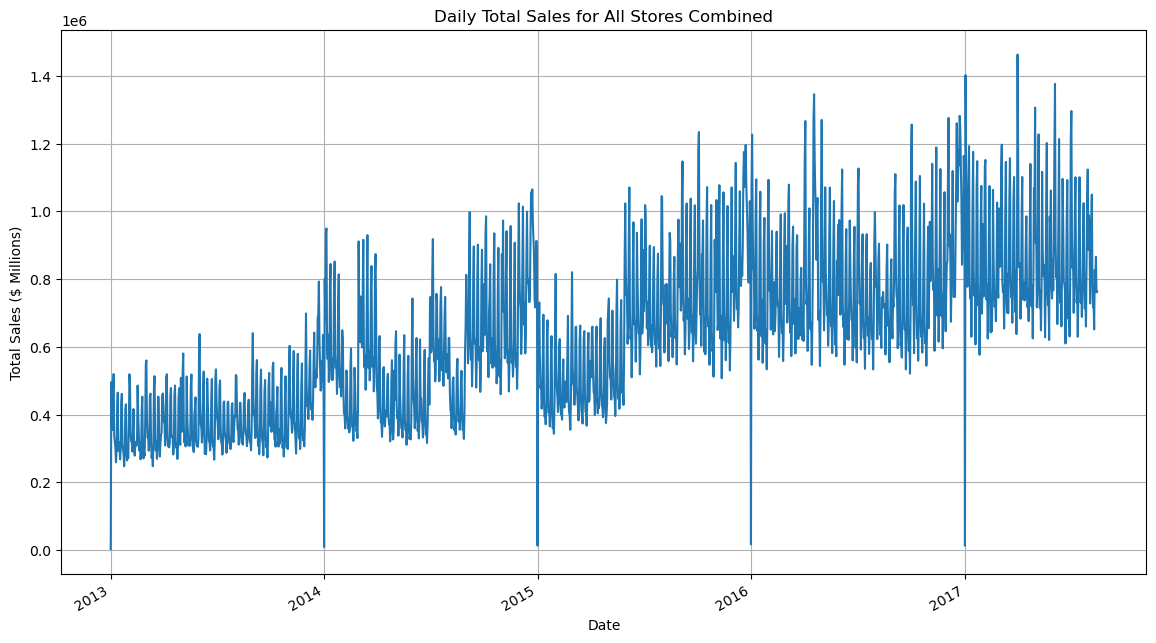

In [38]:
# Group by 'date' and sum 'sales' column
daily_total_sales = df.groupby('date')['sales'].sum()

# Plot the time series
plt.figure(figsize=(14, 8))
daily_total_sales.plot()
plt.title('Daily Total Sales for All Stores Combined')
plt.xlabel('Date')
plt.ylabel('Total Sales ($ Millions)')
plt.grid(True)
plt.show()


- The sales patterns exhibit inconsistencies year-to-year, particularly in 2014.
- Possible reasons include products being introduced or discontinued in specific regions or shifts in sales strategies.

#### Plotting Sales Data by Product Category

**Plot the Daily Total Sales by Product Category for All Stores Combined**

To better observe the sales pattern of each product category (family), each product category (family):

In [39]:
# Group by 'date' and 'family' and sum the 'sales' column
# Credit to The Almost Astrophysicist for this code.
daily_total_sales_by_product = df.groupby(['date', 'family'])['sales'].sum().unstack()

In [40]:
daily_total_sales_by_product.shape

(1684, 33)

The plot shows daily prices by category. Let's plot each product individually.

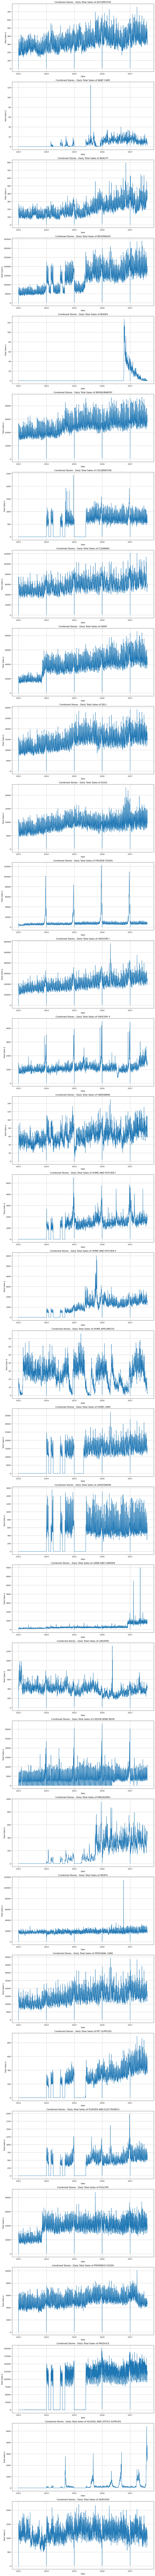

In [41]:
# Create a figure and axes for subplots
fig, axs = plt.subplots(len(daily_total_sales_by_product.columns), 1, figsize=(12, 6 * len(daily_total_sales_by_product.columns)))

# Iterate through each product and plot its daily total sales
for i, product in enumerate(daily_total_sales_by_product.columns):
    axs[i].plot(daily_total_sales_by_product[product])
    axs[i].set_title(f'Combined Stores - Daily Total Sales of {product}')
    axs[i].set_xlabel('Date')
    axs[i].set_ylabel('Total Sales $')
    axs[i].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()


Looking at the sales for all the product categories above, the category "Grocery I" has a nice, seasonal pattern and a solid daily sales total. I will select this product category to model and forecast.

Several categories have intermittent sales, suggesting that these categories may have often been merged with others, or were not always available or may have been expanded, added to or removed from particular stores.

**Create a new dataset for Grocery I**

In [42]:
df_grocery = df[df['family'] == 'GROCERY I']
dfg = df_grocery.groupby('date').agg({
    'sales': 'sum', # Total sales
    'onpromotion': 'mean'  # The mean value of promotion across all stores
}).reset_index()

In [43]:
# Convert the 'date' column to datetime format
dfg['date'] = pd.to_datetime(dfg['date'])

**Merge oil prices into the dataset**

In [44]:
# Rejoin oil onto the dataset
dfg = dfg.merge(df_oil, on='date', how='left')

In [45]:
missing_data(dfg)

Total    Percent           Types
date             0   0.000000  datetime64[ns]
sales            0   0.000000         float64
onpromotion      0   0.000000         float64
dcoilwtico     481  28.562945         float64

There are more dates in the dataset than there are dates in the Oil dataset. This is because oil prices are not updated on weekends and holidays. Oil prices need to be interpolated over the missing dates.

In [46]:
# Fill missing oil prices by interpolation
dfg['dcoilwtico'] = dfg['dcoilwtico'].interpolate(method='linear')
dfg['dcoilwtico'] = dfg['dcoilwtico'].ffill()
dfg['dcoilwtico'] = dfg['dcoilwtico'].bfill()

In [47]:
# Check for missing data
missing_data(dfg)

Total  Percent           Types
date             0      0.0  datetime64[ns]
sales            0      0.0         float64
onpromotion      0      0.0         float64
dcoilwtico       0      0.0         float64

Missing oil prices have been successfully interpolated.

In [48]:
# Ensure 'date' is the index
dfg.set_index('date', inplace=True)

#### Plot characteristics of the dataset

**Plot the time-series for Grocery I sales**

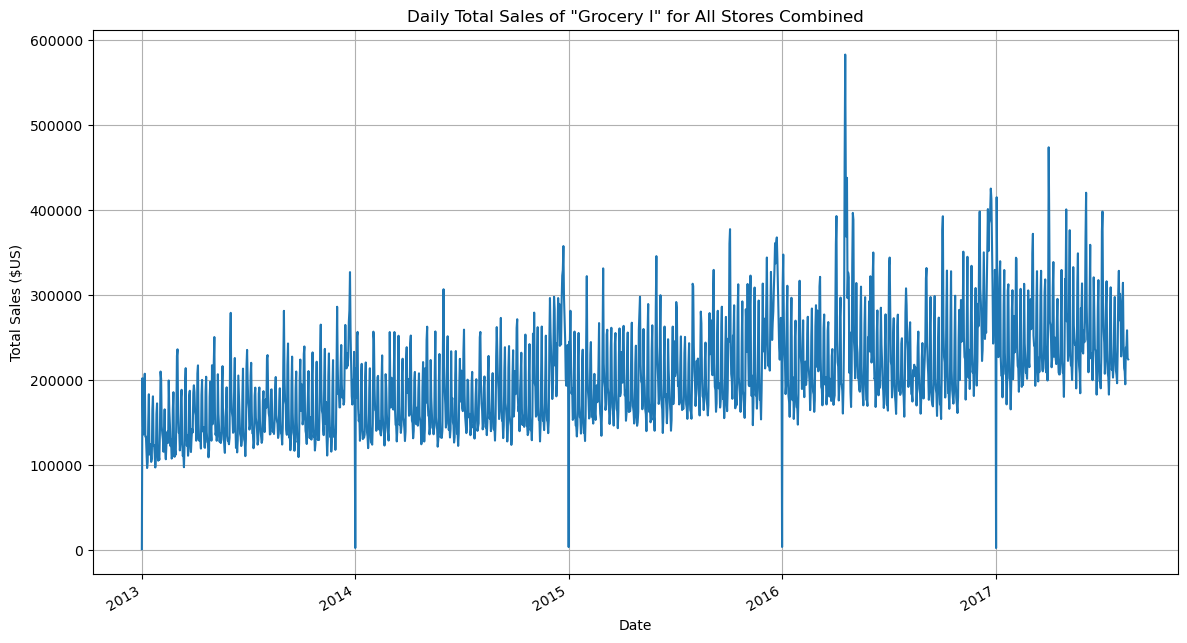

In [49]:
# Plot the time series
plt.figure(figsize=(14, 8))
dfg['sales'].plot()
plt.title('Daily Total Sales of "Grocery I" for All Stores Combined')
plt.xlabel('Date')
plt.ylabel('Total Sales ($US)')
plt.grid(True)
plt.show()

As previously noted, this category exhibits a stable and consistent sales pattern and represents the largest product category, making it the cornerstone of the supermarket chain's sales.

- **New Year's Day:** As a public holiday, the vast majority of stores remain closed. Only a few remain open, resulting in an enormous drop in sales on 01 January.
- **Late December:** Sales experience a notable surge during this period, with a substantial increase in both minimum and maximum sales figures.

In [50]:
print(dfg.index.min())  # Ensure the minimum date is 2013-01-01

2013-01-01 00:00:00


**Plot the chart of oil process over time**

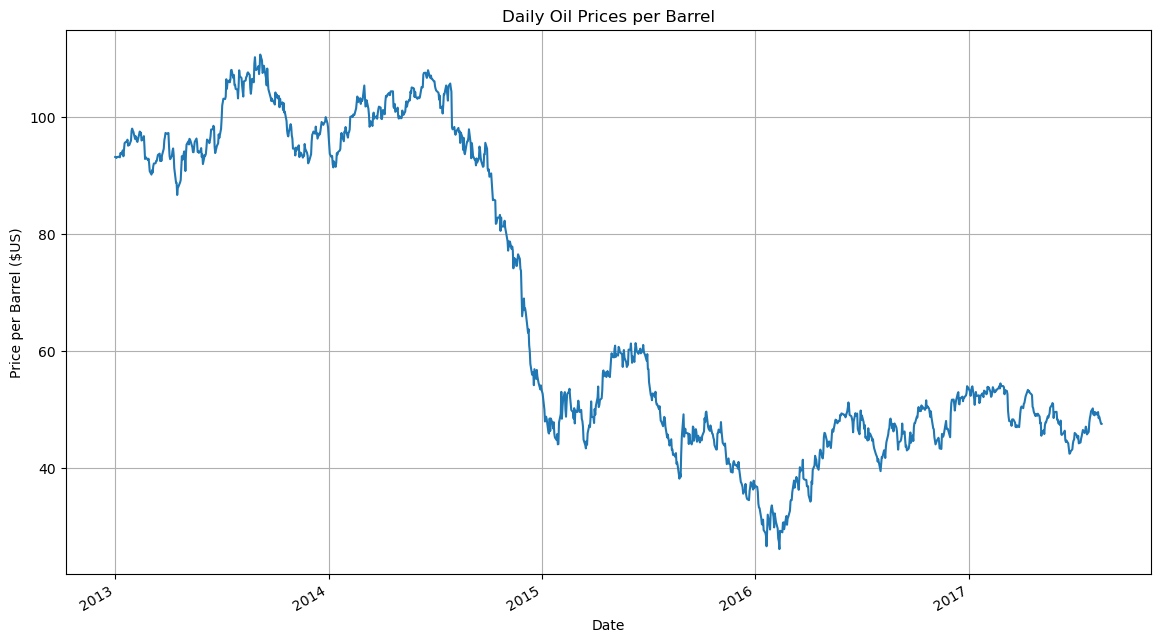

In [51]:
# Plot the oil prices
plt.figure(figsize=(14, 8))
dfg['dcoilwtico'].plot()
plt.title('Daily Oil Prices per Barrel')
plt.xlabel('Date')
plt.ylabel('Price per Barrel ($US)')
plt.grid(True)
plt.show()

From 2013 to around July 2014, the price per barrel was averaging around US\\$100. It then took a sharp fall and was averaging around \\$50 per barrel from January 2015 to August 2017.

**Scatter plot of oil prices**

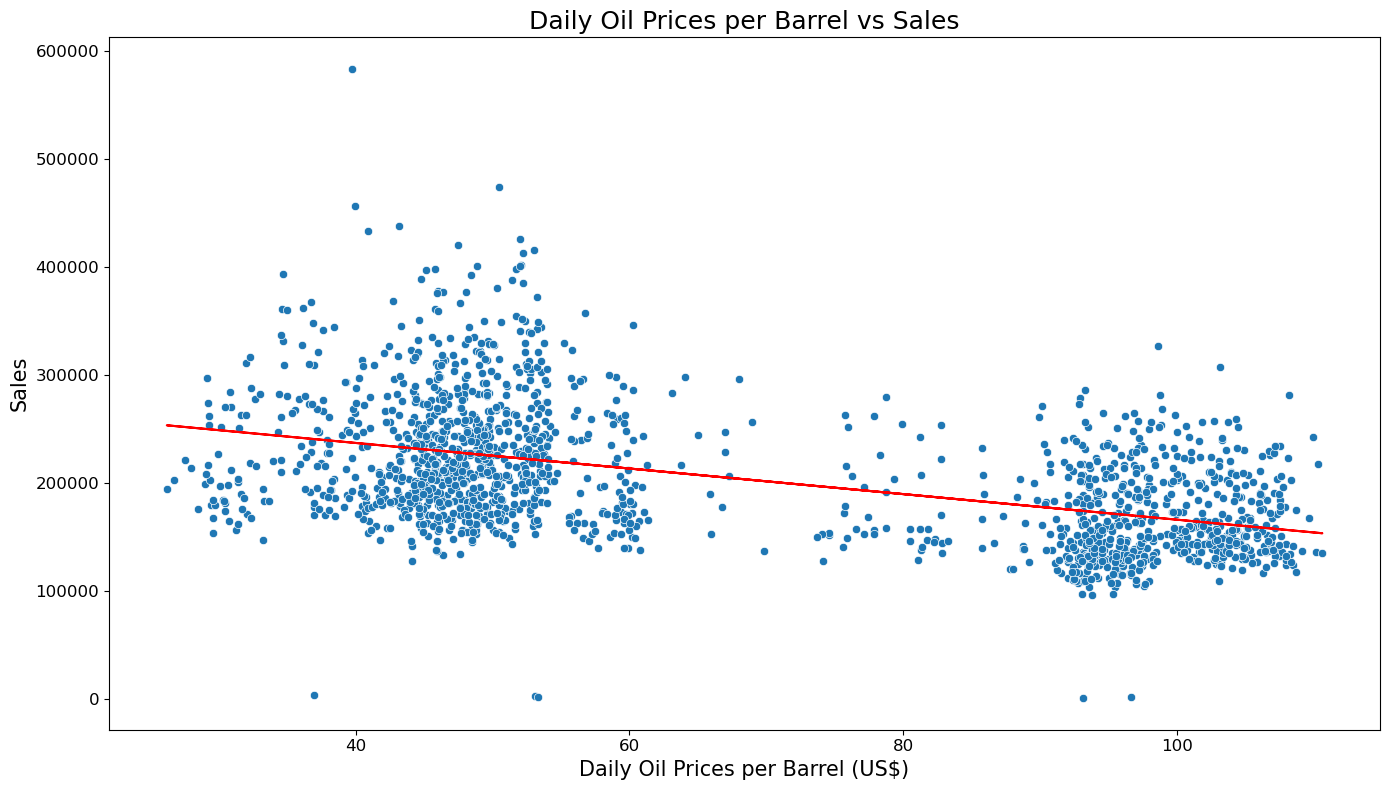

In [52]:
# Setup the figure and axes
fig, ax = plt.subplots(figsize=(14, 8))

# Main Title

# Drop the rows where 'dcoilwtico' or 'sales' have NaN values
df_plot = dfg.dropna(subset=['dcoilwtico', 'sales'])
df_plot = df_plot[~(np.isinf(df_plot['dcoilwtico']) | np.isinf(df_plot['sales']))]

# Create a scatter plot for 'dcoilwtico' vs 'sales'
sns.scatterplot(x=df_plot['dcoilwtico'], y=df_plot['sales'], ax=ax)

# Create a line of best fit for 'dcoilwtico' vs 'sales'
m, b = np.polyfit(df_plot['dcoilwtico'], df_plot['sales'], 1)

ax.plot(df_plot['dcoilwtico'], m*df_plot['dcoilwtico'] + b, color='red')
ax.set_title("Daily Oil Prices per Barrel vs Sales", fontsize=18)
ax.set_xlabel("Daily Oil Prices per Barrel (US$)", fontsize=15)
ax.set_ylabel("Sales", fontsize=15)
ax.tick_params(axis='both', labelsize=12)

# Display the plot
plt.tight_layout()
plt.show()


There appears to be a slight but noticeable negative correlation between oil prices and sales. The clustering of oil prices into two distinct groups reflects a sharp decline in oil prices during late 2014. However, this correlation may be coincidental, as the dataset shows a steady growth in sales over time, despite the sharp drop in oil prices. This consistent growth is more plausibly attributed to factors such as inflation and an increasing population, rather than fluctuations in oil prices. 

**Plot the average number of promotions of groceries per store**

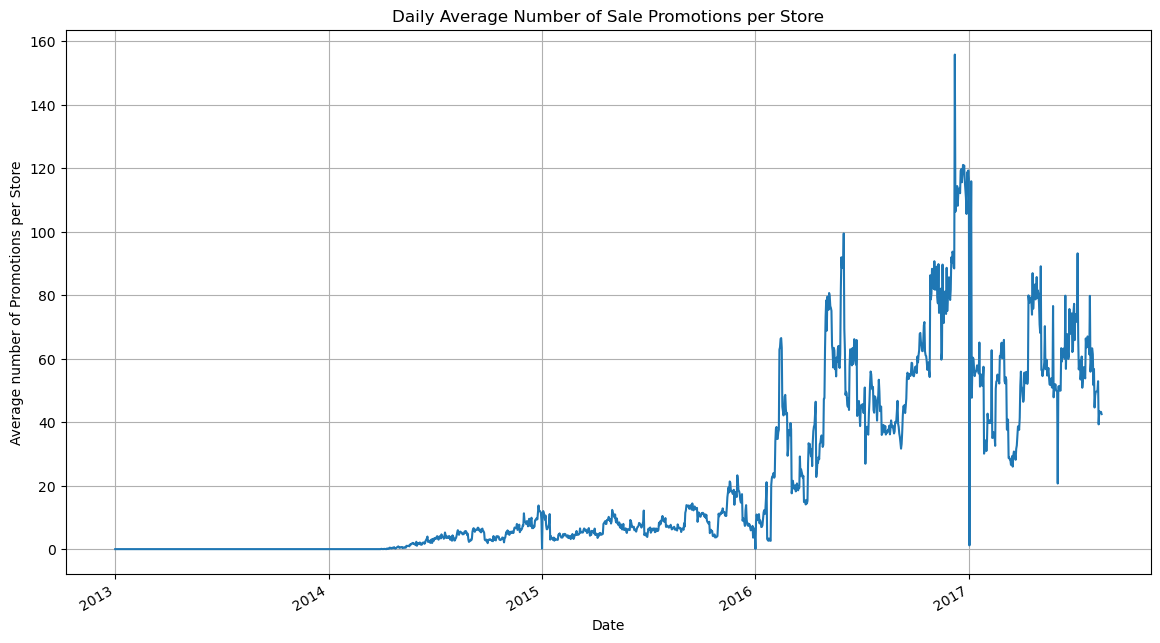

In [53]:
# Plot the average number of promotions of groceries per store 
plt.figure(figsize=(14, 8))
dfg['onpromotion'].plot()
plt.title('Daily Average Number of Sale Promotions per Store')
plt.xlabel('Date')
plt.ylabel('Average number of Promotions per Store')
plt.grid(True)
plt.show()

The average number of promotions per store appears to increase exponentially over time. However, total sales have shown a slower, more gradual increase. This suggests that the relationship between promotions and sales is not linear in the long term.

**Plot the natural log of the average number of promotions of groceries per store**

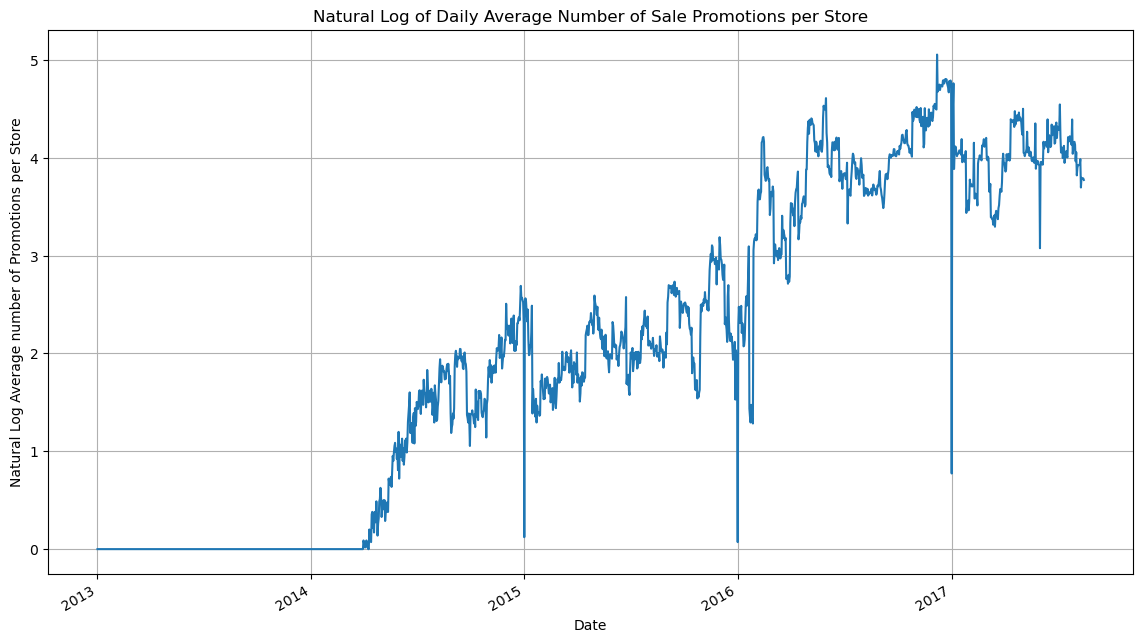

In [54]:
# Plot the oil prices
plt.figure(figsize=(14, 8))
np.log(dfg['onpromotion'] + 1).plot()
plt.title('Natural Log of Daily Average Number of Sale Promotions per Store')
plt.xlabel('Date')
plt.ylabel('Natural Log Average number of Promotions per Store')
plt.grid(True)
plt.show()

The natural log transformation of the number of promotions shows a more linear trend over time compared to the raw data. This transformation will be evaluated for its effectiveness as a regressor in the modelling process.

In [55]:
# Create a new feature of log(onpromotion)
dfg['log_onpromotion'] = np.log(dfg['onpromotion'].replace(0, .01))

**Plot the scatter plot of the average number of promotions of groceries per store**

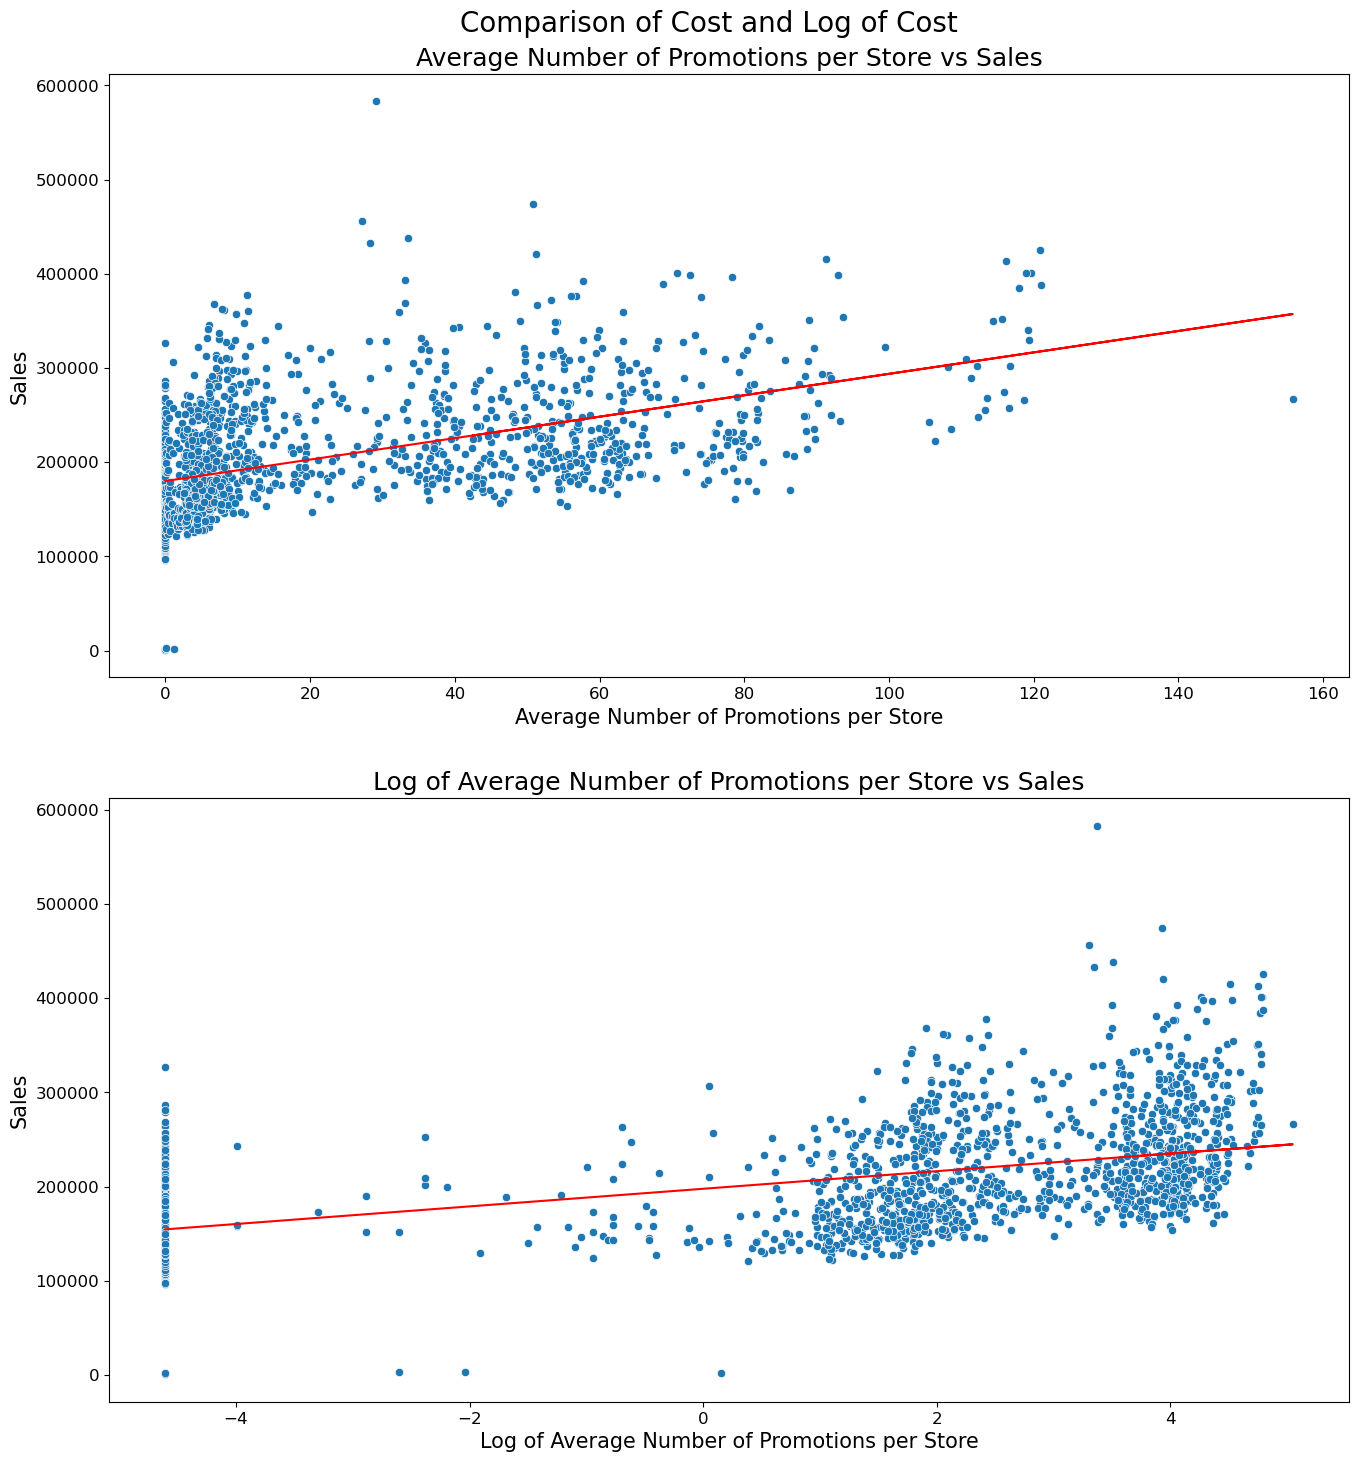

In [56]:
# Setup the figure and axes
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(16, 16))

# Adjust spacing between the main title and subplots
fig.subplots_adjust(top=0.94)  # Adjust the top margin to create space for the main title

# Add the main title
fig.suptitle('Comparison of Cost and Log of Cost', fontsize=20)

# Plot 1 
# Drop the rows where 'onpromotion' or 'sales' have NaN values
df_plot1 = dfg.dropna(subset=['onpromotion', 'sales'])
df_plot1 = df_plot1[~(np.isinf(df_plot1['onpromotion']) | np.isinf(df_plot1['sales']))]

# Create a scatter plot for cost vs rating number
sns.scatterplot(x=df_plot1['onpromotion'], y=df_plot1['sales'], ax=axes[0])

# Create a line of best fit for cost vs rating number
m1, b1 = np.polyfit(df_plot1['onpromotion'], df_plot1['sales'], 1)
axes[0].plot(df_plot1['onpromotion'], m1*df_plot1['onpromotion'] + b1, color='red')

# Customize the first plot
axes[0].set_title("Average Number of Promotions per Store vs Sales", fontsize=18)
axes[0].set_xlabel("Average Number of Promotions per Store", fontsize=15)
axes[0].set_ylabel("Sales", fontsize=15)
axes[0].tick_params(axis='both', labelsize=12)

# Plot 2
# Drop the rows where 'log_onpromotion' or 'sales' have NaN values
df_plot2 = dfg.dropna(subset=['log_onpromotion', 'sales'])
df_plot2 = df_plot2[~(np.isinf(df_plot2['log_onpromotion']) | np.isinf(df_plot2['sales']))]

# Create a scatter plot for log_onpromotion vs sales
sns.scatterplot(x=df_plot2['log_onpromotion'], y=df_plot2['sales'], ax=axes[1])

# Create a line of best fit for log_onpromotion vs sales
m2, b2 = np.polyfit(df_plot2['log_onpromotion'], df_plot2['sales'], 1)
axes[1].plot(df_plot2['log_onpromotion'], m2*df_plot2['log_onpromotion'] + b2, color='red')

# Customize the second plot
axes[1].set_title("Log of Average Number of Promotions per Store vs Sales", fontsize=18)
axes[1].set_xlabel("Log of Average Number of Promotions per Store", fontsize=15)
axes[1].set_ylabel("Sales", fontsize=15)
axes[1].tick_params(axis='both', labelsize=12)

# Display the plots
plt.show()

**Correlation with Promotions**:
- The first plot shows a strong positive correlation between the average number of promotions and sales, with increasing promotions generally leading to higher sales.
- However, there is some non-linearity in this relationship, especially at higher promotion levels.

**Log Transformation**:
- The second plot, using the natural logarithm of promotions, demonstrates a more linear relationship with sales.
- This transformation helps to stabilize the variance and emphasizes smaller changes in promotions, making it a suitable regressor for modelling purposes.

Both metrics (raw and log-transformed promotions) indicate a meaningful relationship with sales. However, this correlation may be coincidental. While promotions have increased significantly in recent years, overall sales have shown a slow and steady upward trend, likely driven by factors such as population growth or inflation. Groceries are essential items, and consumers are likely to make purchases regardless of promotional activities. While promotions may influence sales for specific items, the dataset does not provide sufficient granularity to confirm this. Therefore, the suitability of the "On Promotion" feature for modelling purposes will require further evaluation.

In [57]:
dfg.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1684 entries, 2013-01-01 to 2017-08-15
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   sales            1684 non-null   float64
 1   onpromotion      1684 non-null   float64
 2   dcoilwtico       1684 non-null   float64
 3   log_onpromotion  1684 non-null   float64
dtypes: float64(4)
memory usage: 65.8 KB


There are now four columns in the grocery data frame: date is the index, 'daily sales', 'oil prices', the 'average number of daily promotions per store' and also its natural log. There are 1684 daily records, corresponding to four years and 7.5 months of sales data.

**View Summary Statistics of the Grocery I DataFrame**

In [58]:
dfg.describe()

sales  onpromotion   dcoilwtico  log_onpromotion
count    1684.000000  1684.000000  1684.000000      1684.000000
mean   203956.493400    21.056578    67.894634         0.677862
std     61832.884741    27.770375    25.690236         3.444922
min       700.000000     0.000000    26.190000        -4.605170
25%    157759.750000     0.000000    46.378333        -4.605170
50%    194681.310000     6.361111    53.285000         1.850202
75%    239845.256250    39.185185    95.785000         3.668297
max    583222.480000   155.777778   110.620000         5.048430

The summary statistics provide an overview of the key metrics and features in the dataset:

- **sales**:
  - The average daily sales (`y`) across the dataset is approximately **\\$203,956.49**, with a standard deviation of **\\$61,832.88**, indicating moderate variability in sales.
  - The minimum sales observed were **\\$700**, and the maximum were **\\$583,222.48**, reflecting significant fluctuations in daily sales.
<br><br>
- **Continuous Regressors**:
  - **`dcoilwtico` (Oil Prices)**:
    - Mean: **\\$67.89**
    - Range: **\\$26.19** (min) to **\\$110.62** (max), showing substantial variation over the dataset period.
  - **`onpromotion` (Number of Promotions)**:
    - Mean: **21.06**, with a maximum of **155.78** promotions on average per store, reflecting days with significant promotional activity.
  - **`log_onpromotion` (Log of Promotions)**:
    - Mean: **2.04**, indicating the logarithmic transformation effectively stabilized extreme values in promotions.
<br><br>
- **Time Period**:
  - The dataset spans from **2013-01-01** to **2017-08-15**, covering 1,684 days.

**Check for any missing dates**

In [59]:
dfg.shape

(1684, 4)

There are 1,684 days in the dataset.  
Doing a quick calculation, From 01 Jan 2013 to 15 Aug 2017 inclusive, there should be 1,688 days.  
Let's find out which dates are missing.

In [60]:
full_date_range = pd.date_range(start="2013-01-01", end="2017-08-15")
missing_dates = full_date_range.difference(dfg.index)
print("Missing dates:", missing_dates)

Missing dates: DatetimeIndex(['2013-12-25', '2014-12-25', '2015-12-25', '2016-12-25'], dtype='datetime64[ns]', freq=None)


All these days are Christmas Day when all stores are closed. As sales are absolutely $0 for Christmas and it is not in the test set, Christmas will be left out of the dataset for now. Regardless, it is always good practice to check if there are missing dates and determine why.

**Plot a histogram of the distribution of the daily sales**

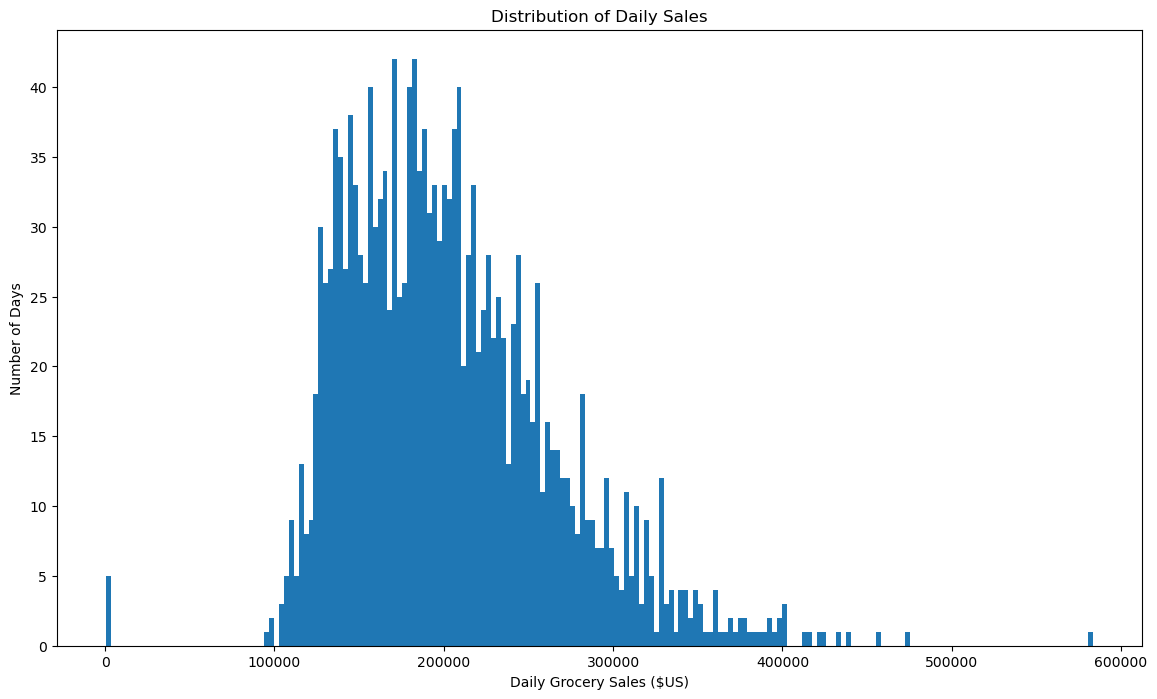

In [61]:
plt.figure(figsize=(14, 8))
dfg['sales'].plot(
    kind='hist',
    bins=200,
    title='Distribution of Daily Sales',
    xlabel='Daily Grocery Sales ($US)',
    ylabel='Number of Days'
)
plt.show()

There are five days in the dataset with sales values very close to $0, all occurring on New Year's Day, as shown in the time-series chart above. Additionally, there is an extreme spike in sales on **18 April 2016**, two days after the earthquake, driven by the purchase of emergency supplies such as food and water. Sales remained exceptionally high for several days following the earthquake.

Another notable outlier is **1 April 2017**, which experienced unusually high sales. However, as this date falls within the test set, it will not be adjusted or treated during the modelling process.

### Data Cleaning

Data preparation is an important step in the modelling process. The following steps are commonly recommended for effective data cleaning:

1. **Remove Low-Volume Data**: Filter out data points with very low sales volumes, which may not contribute meaningfully to the analysis.

2. **Address Irregular Data Lapses**: Identify and filter out periods where there are irregular lapses in data, such as consecutive days or weeks with zero sales, that do not reflect ongoing trends.

3. **Handle Outliers**: Remove unusual aberrations in the data or impute them with reasonable values. This ensures that extreme values do not unduly influence the model.

4. **Reassess the Time-Series**: After cleaning, review the time-series data to identify any remaining irregularities. If there are significant shifts in the pattern over time, consider filtering out data prior to the start of the regular pattern.

#### Outlier Treatment
The histogram highlights several notable outliers, such as:
- **Important Holidays**: New Year's Day when almost all stores are closed, leading to near-zero sales.
- **Earthquake Impact**: A sharp increase in sales following the earthquake, as customers purchased emergency supplies.

These outliers can be effectively addressed in Prophet by treating them as special regressors for specified dates. This approach ensures that unusual sales patterns do not skew the model and eliminates the need for steps 2 and 3 above in Prophet. Models 2 and 3 specifically handle these outliers to improve prediction accuracy.

In [62]:
# Determine the date of maximum sales in the groceries and the quantity
dfg[dfg['sales'] == dfg['sales'].max()]

sales  onpromotion  dcoilwtico  log_onpromotion
date                                                           
2016-04-18  583222.48    29.055556       39.74          3.36921

The day of maximum sales was 18 April 2016, two days after the earthquake. Total grocery sales for that day were \\$583,222.

**Create Time Features for the Data Frame**

The `create_time_features` function generates a range of time-related features to enhance time-series analysis. While many of these features are not explicitly required by Facebook Prophet, since it already incorporates annual, monthly, and weekly seasonality—additional features help capture more specific patterns, such as increased sales on weekends after payday, which may not be accounted for by default.

**Key Points**:
- **Flexibility**: The function accommodates a wide variety of features, enabling adaptability during model development.
- **Preemptive Inclusion**: Certain features have been included in advance to streamline future workflows and reduce the need for additional coding later.
- **Exploration**: Various combinations of these features, regressors, and seasonalities will be explored to identify optimal configurations for improving model performance.

In [63]:
# Call the create_time_features function to create time features for the data frame
dfgt = create_time_features(dfg)

The label is: None


In [64]:
# Make a copy of the time featured dataset to be used for the prophet model.
dfg1 = dfgt.copy()

**View the added time-related features**

In [65]:
dfg1.head(6)

sales  onpromotion  dcoilwtico  log_onpromotion       date  \
date                                                                        
2013-01-01     700.0          0.0   93.140000         -4.60517 2013-01-01   
2013-01-02  202020.0          0.0   93.140000         -4.60517 2013-01-02   
2013-01-03  144878.0          0.0   92.970000         -4.60517 2013-01-03   
2013-01-04  135754.0          0.0   93.120000         -4.60517 2013-01-04   
2013-01-05  188356.0          0.0   93.146667         -4.60517 2013-01-05   
2013-01-06  207297.0          0.0   93.173333         -4.60517 2013-01-06   

            hour  dayofweek    weekday  quarter  month month_name  year  \
date                                                                      
2013-01-01     0          1    Tuesday        1      1    January  2013   
2013-01-02     0          2  Wednesday        1      1    January  2013   
2013-01-03     0          3   Thursday        1      1    January  2013   
2013-01-04     0          4     Friday        1      1    January  2013   
2013-01-05     0          5   Saturday        1      1    January  2013   
2013-01-06     0          6     Sunday        1      1    January  2013   

            dayofyear  dayofmonth  weekofyear  date_offset season  \
date                                                                
2013-01-01          1           1           1         1081    Wet   
2013-01-02          2           2           1         1082    Wet   
2013-01-03          3           3           1         1083    Wet   
2013-01-04          4           4           1         1084    Wet   
2013-01-05          5           5           1         1085    Wet   
2013-01-06          6           6           1         1086    Wet   

            first_weekend_of_month  first_weekend_after_15th  
date                                                          
2013-01-01                       0                         0  
2013-01-02                       0                         0  
2013-01-03                       0                         0  
2013-01-04                       0                         0  
2013-01-05                       1                         0  
2013-01-06                       1                         0

**Key Features**:
- **Temporal Details**: Columns such as `dayofweek`, `weekday`, `month`, and `year` help capture time-related sales patterns.
- **Seasonality**: Two seasons are included based on Ecuador's climate:
  - **Wet Season**: November to May.
  - **Dry Season**: June to October.
- **Payday Weekends**: Flags for the first weekend of the month and the weekend following the 15th are included to capture payday-related sales spikes.
- **Holiday Proximity**: Features like "Is 2nd of January" and "Is Week Before Christmas" are added to capture specific seasonal behaviours.

These enhancements provide a richer dataset, allowing for better modelling of seasonality and trends, especially in the context of Ecuador's unique climate and cultural events.

**Box Plot of daily sales distribution**

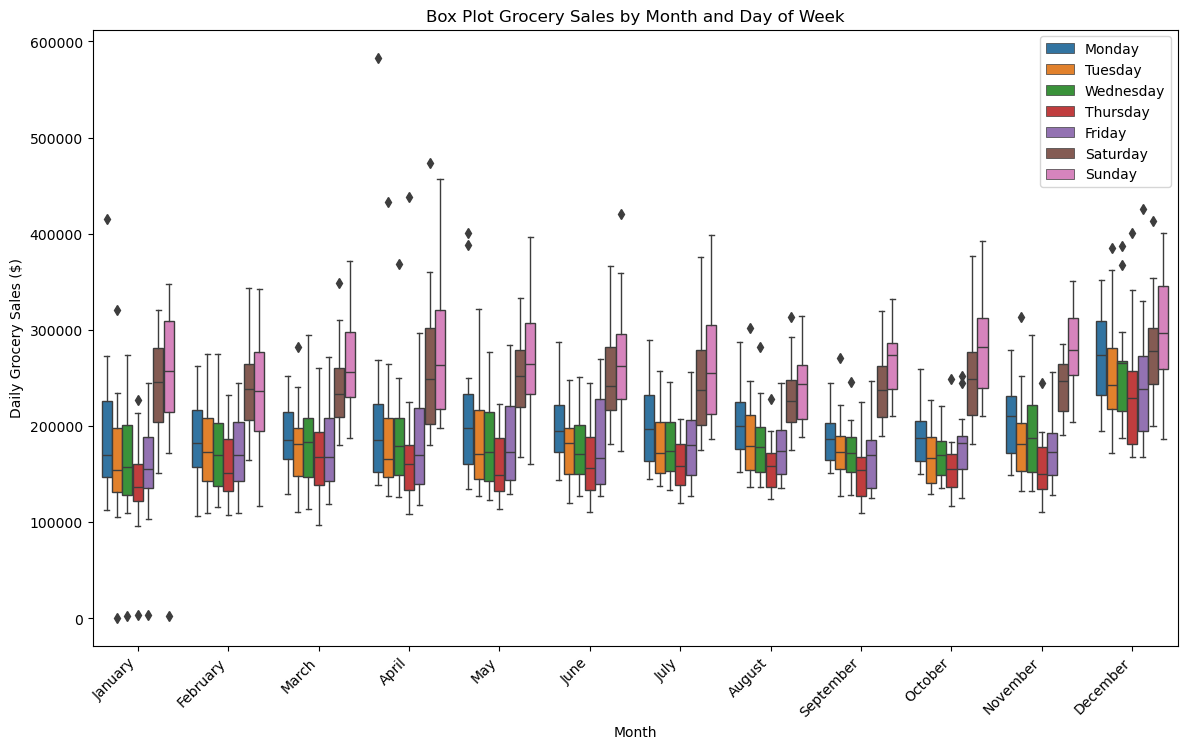

In [66]:
# Get the month names
month_names = [calendar.month_name[i] for i in range(1, 13)]

# Create the plot
fig, ax = plt.subplots(figsize=(14, 8))
sns.boxplot(data=dfg1.dropna(),
            x='month',
            y='sales',
            hue='weekday',
            ax=ax,
            linewidth=1)

# Set the x-axis labels to the month names
ax.set_xticklabels(month_names, rotation=45, ha='right')

# Set the title, x-label, y-label, and legend
ax.set_title('Box Plot Grocery Sales by Month and Day of Week')
ax.set_xlabel('Month')
ax.set_ylabel('Daily Grocery Sales ($)')
ax.legend(bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

This box plot visualizes daily grocery sales across all months, segmented by weekdays. It provides insights into seasonality and sales trends influenced by days of the week and special events.

**Key Observations**:  
1. **Weekly Seasonality**:
   - **Weekends** (particularly Sundays) are the busiest days for grocery sales.
   - **Thursday** (red) consistently shows the lowest sales across all months.
<br><br>
2. **Monthly Trends**:
   - **December**: The busiest month due to the Christmas and New Year holidays.
   - **April**: The second busiest month, likely attributed to **Easter**, a significant holiday in Latin America, amd the **earthquake** in April 2016.
   - **January**: Follows closely, though five days (New Year’s Day) have virtually zero sales due to widespread store closures.
<br><br>
3. **Outliers**:
   - April exhibits extreme sales spikes in 2016 due to the **Manabí Earthquake**, where people purchased emergency supplies such as food and water. This anomaly will be addressed during the modelling phase.
<br><br>
4. **Exclusions**:
   - **Christmas Day** is excluded from the dataset as stores are entirely closed on this day, making it consistent with the observed data trends.

This plot effectively highlights the interaction between seasonality, cultural events, and weekly patterns, offering good insights for time-series modelling.

**Plot daily sales for a six-month period**

In [67]:
# Select a data frame for the first 6 months of 2014
df_2014_1_3 = dfg1.loc[('2014-01-01' <= dfg1.index) & (dfg1.index <= '2014-06-30')]

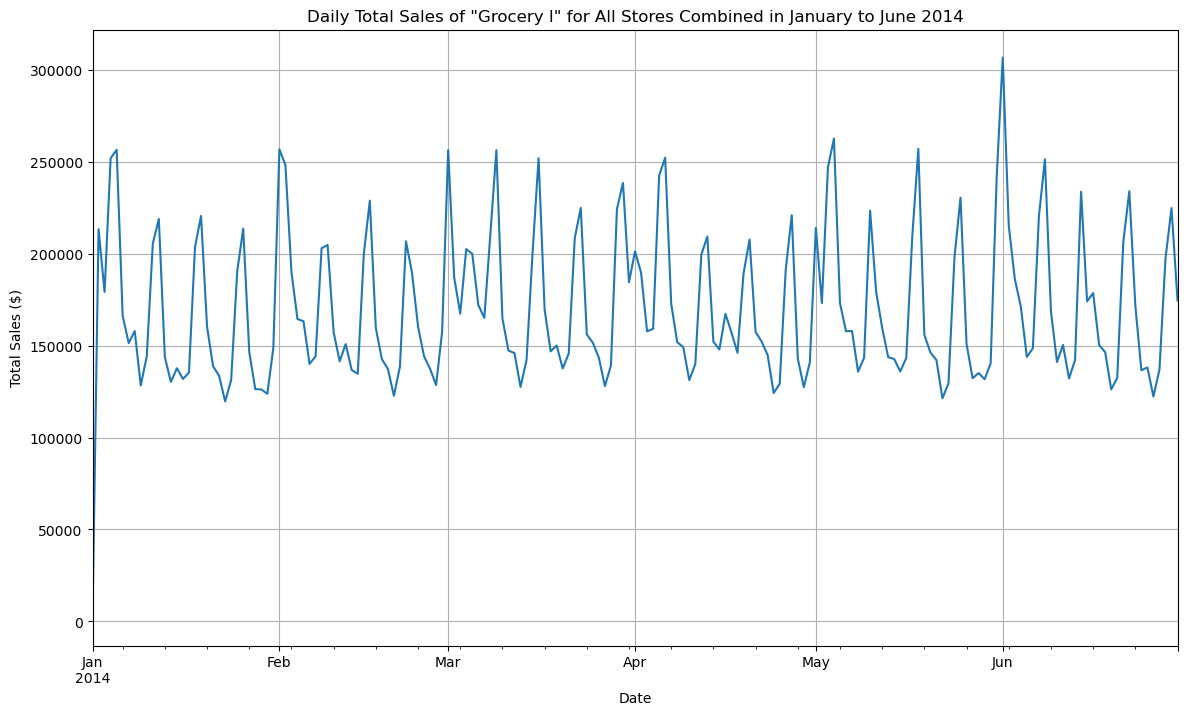

In [68]:
# Plot the sales for 01 January to 30 June 2014
plt.figure(figsize=(14, 8))
df_2014_1_3['sales'].plot()
plt.title('Daily Total Sales of "Grocery I" for All Stores Combined in January to June 2014')
plt.xlabel('Date')
plt.ylabel('Total Sales ($)')
plt.grid(True)
plt.show()

**Daily Sales for the First Six Months of 2014**

This plot illustrates daily grocery sales for the **Grocery I** category across all stores for the first half of 2014. 

**Key Insights**:
1. **Weekly Seasonality**:
   - Sales exhibit a clear **weekly pattern**, with peaks occurring on **weekends** (especially Sundays) and troughs during weekdays.
   - This pattern is consistent with consumer shopping habits, where weekends tend to have higher foot traffic.
<br><br>
2. **Monthly Patterns**:
   - Significant sales are often observed on the **first day of the month** and the **weekend following the 1st**.
   - Similarly, sales spikes are common on the **weekend following the 15th**, correlating with fortnightly paydays.
<br><br>
3. **Impact of Payday Cycles**:
   - According to the dataset notes, **wages in the public sector are paid fortnightly**—on the 15th and the last day of the month. This payment schedule likely drives increased sales during the associated weekends.
<br><br>
4. **Feature Engineering**:
   - Custom columns have been created to flag the **weekends following the 1st and 15th** of each month. These features will be used in the modelling process to capture the sales patterns associated with payday-driven behaviour.

This granular time-series visualization highlights the recurring sales patterns and the influence of weekly and fortnightly cycles, providing valuable context for feature selection and model development.

---

## <span style="color: darkblue;">5. Modelling</span>
In the full project, an initial baseline model was created using the default configuration of Facebook Prophet. Numerous enhancements were applied to both data preparation and Prophet’s parameter settings. Seven additional models were developed, all incorporated additional improvements, demonstrating their impact on the modelling results. The process culminated in identifying the best-performing model, which underwent hyperparameter tuning to further optimize its performance.

This condensed version of the report focuses on the development of two key models. The first model, **Pr3.1**, incorporates major enhancements, including the handling of seasonality, holiday effects, and external regressors. Following its evaluation, patterns of the largest prediction errors were analyzed, leading to the creation of the final model, **Pr5**, which integrates additional regressors to account for these errors. This streamlined approach provides a clear demonstration of the techniques and methodologies applied in the project.

### <span style="color: darkblue;">Prepare the data frame for modelling with Prophet</span>
The dataset will be structured and refined to meet the requirements for time-series modelling.

**Train and Test set**  
The training set consists of four full years of data, spanning from 01 January 2013, to 31 December 2016.  
The test set includes all available data for 2017, covering the period from 01 January 2017, to 15 August 2017.

In [69]:
# Define the test start date
test_start_date = "2017-01-01"
test_start_date = datetime.strptime(test_start_date, "%Y-%m-%d")

# Convert test_start_date to a Timestamp object
test_start_date_ts = pd.Timestamp(test_start_date)

#### Determine the number of days in the test set
This will be used to determine how far into the future to run predictions.

In [70]:
# Find the last date in the data frame
last_date = dfg1['date'].max()

In [71]:
# Convert last_date to np.datetime64 with 'D' (day) unit
last_date_np = np.datetime64(last_date, 'D')

# Convert test_start_date_ts to np.datetime64 with 'D' (day) unit
test_start_date_np = np.datetime64(test_start_date_ts, 'D')

# Calculate the number of days between last_date and test_start_date + 1 to include the first day
num_days = np.timedelta64(last_date_np - test_start_date_np, 'D').astype(int) +1

In [72]:
num_days

227

There are 227 days in the test set, 01 Jan to 15 Aug 2017.

**Prepare a new DataFrame (dfp) formatted specifically for Prophet, which has unique requirements compared to other time-series models.**

In [73]:
# Make a copy of df grocery (dfg1) to df Prophet (dfp)
dfp = dfg1.copy()

In [74]:
dfp.head()

sales  onpromotion  dcoilwtico  log_onpromotion       date  \
date                                                                        
2013-01-01     700.0          0.0   93.140000         -4.60517 2013-01-01   
2013-01-02  202020.0          0.0   93.140000         -4.60517 2013-01-02   
2013-01-03  144878.0          0.0   92.970000         -4.60517 2013-01-03   
2013-01-04  135754.0          0.0   93.120000         -4.60517 2013-01-04   
2013-01-05  188356.0          0.0   93.146667         -4.60517 2013-01-05   

            hour  dayofweek    weekday  quarter  month month_name  year  \
date                                                                      
2013-01-01     0          1    Tuesday        1      1    January  2013   
2013-01-02     0          2  Wednesday        1      1    January  2013   
2013-01-03     0          3   Thursday        1      1    January  2013   
2013-01-04     0          4     Friday        1      1    January  2013   
2013-01-05     0          5   Saturday        1      1    January  2013   

            dayofyear  dayofmonth  weekofyear  date_offset season  \
date                                                                
2013-01-01          1           1           1         1081    Wet   
2013-01-02          2           2           1         1082    Wet   
2013-01-03          3           3           1         1083    Wet   
2013-01-04          4           4           1         1084    Wet   
2013-01-05          5           5           1         1085    Wet   

            first_weekend_of_month  first_weekend_after_15th  
date                                                          
2013-01-01                       0                         0  
2013-01-02                       0                         0  
2013-01-03                       0                         0  
2013-01-04                       0                         0  
2013-01-05                       1                         0

#### Prepare the data frame for modelling with Prophet

Prophet requires the column names to be **ds** for the date and **y** for the time-series value. Ensure that **y** is numeric and that **ds** is in datetime format.

In [75]:
# Step 1: Drop the existing 'date' column if it exists
if 'date' in dfp.columns:
    dfp = dfp.drop(columns=['date'])

In [76]:
# Step 2: Reset the index to create the 'ds' column
dfp = dfp.reset_index()

In [77]:
# Step 3: Rename the columns: 'sales' to 'y' and 'index' (former date index) to 'ds'
dfp = dfp.rename(columns={'sales': 'y', 'date': 'ds'})

In [78]:
# Step 4: Keep only the 'ds' and 'y' columns
dfp = dfp[['ds', 'y']]

In [79]:
# Step 5: Ensure 'y' is numeric
dfp['y'] = pd.to_numeric(dfp['y'], errors='coerce')

In [80]:
# Display the Prophet Ready dataset information
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      1684 non-null   datetime64[ns]
 1   y       1684 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 26.4 KB


#### Create the original training set
The train set is from 01 January 2013 up to 31 December 2016.  
The test set is from 01 January 2017 to 15 August 2017.  
In this project there are 4 full years of training data to predict the first 7.5 months of 2017.  

In [81]:
df_train = dfp[(dfp['ds'] < test_start_date) ]

In [82]:
df_train.head()

ds         y
0 2013-01-01     700.0
1 2013-01-02  202020.0
2 2013-01-03  144878.0
3 2013-01-04  135754.0
4 2013-01-05  188356.0

This training set will be used to create the special model for New Year's Day only. Other training sets will be created after additional feature engineering has been performed on the dataset.

In [83]:
# View the train tail
df_train.tail()

ds           y
1452 2016-12-27  242792.095
1453 2016-12-28  265759.513
1454 2016-12-29  257006.744
1455 2016-12-30  329599.654
1456 2016-12-31  302232.811

The training data frame ends at 31 December 2016 as expected.

---

### <span style="color: darkblue;">Prophet Model 3.1.</span>

#### <span style="color: darkblue;">Incorporating Holidays</span>

**Holiday Data**  
Holidays can significantly impact sales, as observed in the baseline Model Pr1 in the full report. To improve prediction accuracy, holiday data will be incorporated into the model.

In [84]:
# Add the holiday data
holiday = pd.DataFrame([])

# Fetch Ecuadorian holidays from 2013 to 2017 inclusive
ecuador_holidays = holidays.Ecuador(years=[2013, 2014, 2015, 2016, 2017])

# Convert the holiday dates to a DataFrame
# It was determined that there is a strong sales effect one day before the holiday and two days after.
# These final numbers were confirmed, after evaluating many iterations.
ecuador_holidays_df = pd.DataFrame({
    'holiday': list(ecuador_holidays.values()),  # Name of the holiday
    'ds': pd.to_datetime(list(ecuador_holidays.keys())),  # Date of the holiday
    'lower_window': -1,  # Lower window
    'upper_window': 2,   # Upper window
})

# Ensure the lower and upper window for "Año Nuevo" (New Year) are set to 0
# As this holiday has virtually 0 sales, the effects in the lower and upper window were different to other holidays.
ecuador_holidays_df.loc[ecuador_holidays_df['holiday'] == 'Año Nuevo', ['lower_window', 'upper_window']] = [0, 0]
# Christmas day was briefly implemented into the dataset, but it resulted difficult to model, like New Year's so it was removed.
#ecuador_holidays_df.loc[ecuador_holidays_df['holiday'] == 'Día de Navidad', ['lower_window', 'upper_window']] = [0, 0]

In [85]:
# Display the holidays for the first two years
ecuador_holidays_df.sort_values('ds').head(25)

holiday         ds  lower_window  upper_window
25                      Año Nuevo 2013-01-01             0             0
26                       Carnaval 2013-02-11            -1             2
27                       Carnaval 2013-02-12            -1             2
28                  Viernes Santo 2013-03-29            -1             2
29                Día del Trabajo 2013-05-01            -1             2
30           Batalla de Pichincha 2013-05-24            -1             2
31  Primer Grito de Independencia 2013-08-10            -1             2
32     Independencia de Guayaquil 2013-10-09            -1             2
33            Día de los Difuntos 2013-11-02            -1             2
34        Independencia de Cuenca 2013-11-03            -1             2
35                 Día de Navidad 2013-12-25            -1             2
36                      Año Nuevo 2014-01-01             0             0
37                       Carnaval 2014-03-03            -1             2
38                       Carnaval 2014-03-04            -1             2
39                  Viernes Santo 2014-04-18            -1             2
40                Día del Trabajo 2014-05-01            -1             2
41           Batalla de Pichincha 2014-05-24            -1             2
42  Primer Grito de Independencia 2014-08-10            -1             2
43     Independencia de Guayaquil 2014-10-09            -1             2
44            Día de los Difuntos 2014-11-02            -1             2
45        Independencia de Cuenca 2014-11-03            -1             2
46                 Día de Navidad 2014-12-25            -1             2
47                      Año Nuevo 2015-01-01             0             0
48                       Carnaval 2015-02-16            -1             2
49                       Carnaval 2015-02-17            -1             2

There are 11 holidays per year. All of these are national even though a couple sound like regional holidays. For example Independencia de Guayaquil (Independence of Guayaquil).

In [86]:
# Display the number of holidays in Ecuador during the time period.

ecuador_holidays_df.shape

(58, 4)

#### <span style="color: darkblue;">Oil Prices</span>
#### Existing Regressors
The dataset already includes the following variables, summarized below:

- **Daily Oil Price (`dcoilwtico`)**:  
  This variable tracks daily oil prices during both the training and test data periods.  
  - **Importance**: Ecuador’s economy is highly oil-dependent, and fluctuations in oil prices have significant impacts on economic stability and consumer behaviour.
<br><br>
- **Promotions (`onpromotion`)**:  
  Represents the total number of items in a product family that were being promoted at a store on a given date.  
  - **Key Observations**:  
    - Barely any promotions were observed in grocery sales in 2013.  
    - Promotions increased exponentially, peaking with an average of nearly 160 items promoted across all stores.

#### <span style="color: darkblue;">First Weekend After Payday</span>
#### Observations from Model Pr2.1
In the full report, from Model Pr2.1's grocery sales charts, it is evident that:

1. **First Weekend of the Month**:
   - These dates often exhibit larger sales spikes.  
   - This pattern aligns with many workers receiving their salaries at the start of the month in Ecuador.
<br><br>
2. **First Weekend After the 15th**:  
   - Although less pronounced, these weekends also show noticeable sales spikes.

#### New Regressors
To capture these effects more accurately, the following will be added as regressors:
- **First Weekend of the Month**: A binary flag for Saturdays and Sundays in the first weekend of each month.
- **First Weekend After the 15th**: A binary flag for Saturdays and Sundays in the first weekend following the 15th of the month.

These regressors were incorporated into the **create_time_features** function and will be used in **Model Pr3.1**.

#### <span style="color: darkblue;">Earthquake Outliers</span>
Beyond New Year’s Day, further examination is needed for extreme outliers. A notable period is **March to May 2016**, which includes:
- **Earthquake Impact**: The **Manabí Earthquake** on April 16, 2016, had a profound effect on consumer behaviour and store operations. Sales data for this period will be closely analyzed and treated to better handle such anomalies.

By incorporating these additional regressors and addressing significant outliers, **Model Pr3.1** aims to improve prediction accuracy.

#### Plot Daily Sales for April 2016

In [87]:
# Select a data frame for the specified period in 2016
df_2016 = dfg1.loc[('2016-04-01' <= dfg1.index) & (dfg1.index <= '2016-05-05')]

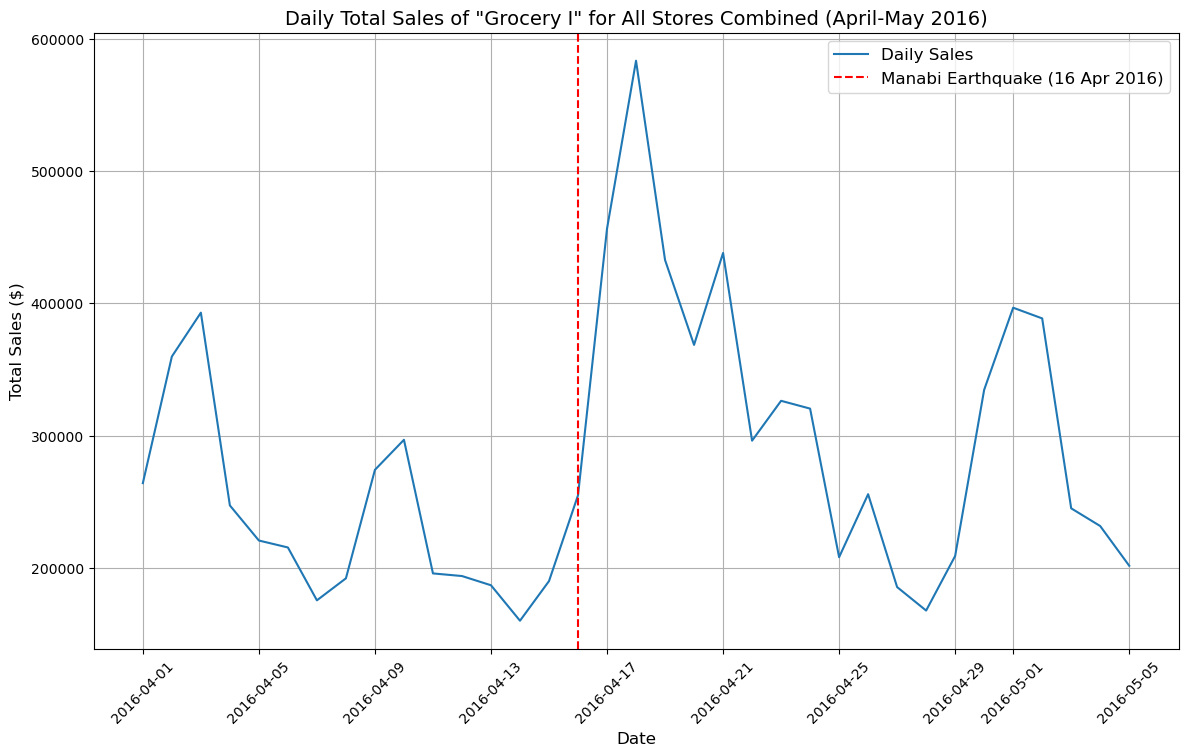

In [88]:
# Plot the sales for April to May 2016
plt.figure(figsize=(14, 8))
plt.plot(df_2016.index, df_2016['sales'], label='Daily Sales')

# Add a red vertical line for the earthquake date
earthquake_date = '2016-04-16'
plt.axvline(pd.to_datetime(earthquake_date), color='red', linestyle='--', label='Manabi Earthquake (16 Apr 2016)')

# Add labels and title
plt.title('Daily Total Sales of "Grocery I" for All Stores Combined (April-May 2016)', fontsize=14)
plt.xlabel('Date', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True)

# Display the plot
plt.show()

In [89]:
max_sales_date = dfg1.loc[dfg1['sales'].idxmax(), 'date']
max_sales_value = dfg1['sales'].max()

print(f"The maximum sales value is: ${max_sales_value}")
print(f'It occurred on: {max_sales_date.strftime("%Y-%m-%d")}')

The maximum sales value is: $583222.48
It occurred on: 2016-04-18


#### Define and Add Key Earthquake Dates as Regressors

On Saturday, April 16, 2016, at 18:58 local time, a devastating magnitude 7.8 earthquake struck the Manabí province in Ecuador. This event caused a significant disruption in daily life and resulted in extreme spikes in grocery and water sales in the days following, as people stocked up on essential supplies and bought provisions for those affected.

By analyzing the sales chart, it is evident that sales remained unusually elevated until the following Saturday, April 23, 2016, after which they began to normalize.

Rather than removing or imputing these outliers, these dates will be added as special regressors to explicitly account for this anomaly in the data and its impact on sales patterns. This approach allows the model to recognize the unique influence of this event without distorting the overall trend or seasonal components.

**Add Earthquake Regressors**

In [90]:
# Define the specific dates
earthquake_1_day_after = '2016-04-17'
eq_2_days_after = '2016-04-18'
eq_3_days_after = '2016-04-19'
eq_4_days_after = '2016-04-20'
eq_5_days_after = '2016-04-21'
eq_6_days_after = '2016-04-22'
#eq_7_days_after = '2016-04-22'

In [91]:
# Initialize the columns with 0s
dfg1['earthquake_1_day_after'] = 0
dfg1['eq_2_days_after'] = 0
dfg1['eq_3_days_after'] = 0
dfg1['eq_4_days_after'] = 0
dfg1['eq_5_days_after'] = 0
dfg1['eq_6_days_after'] = 0

# Set the flag for the specific dates with highly unusual activity
dfg1.loc[dfg1.index == earthquake_1_day_after, 'earthquake_1_day_after'] = 1
dfg1.loc[dfg1.index == eq_2_days_after, 'eq_2_days_after'] = 1
dfg1.loc[dfg1.index == eq_3_days_after, 'eq_3_days_after'] = 1
dfg1.loc[dfg1.index == eq_4_days_after, 'eq_4_days_after'] = 1
dfg1.loc[dfg1.index == eq_5_days_after, 'eq_5_days_after'] = 1
dfg1.loc[dfg1.index == eq_6_days_after, 'eq_6_days_after'] = 1

#### Log Transformation of the `onpromotion` Variable

To evaluate the relationship between the number of promotions (`onpromotion`) and grocery sales, a new feature, `LogOfPromotion`, was created by applying a natural logarithm transformation using the `log1p` function. This transformation compresses large values while preserving the relative differences and is particularly useful for addressing skewed distributions.

The purpose of this step is to compare the performance of the log-transformed variable (`LogOfPromotion`) against the original `onpromotion` variable when used as a regressor in the model. This analysis helps identify which representation more effectively captures the impact of promotions on sales, potentially improving the model's predictive power.


In [92]:
dfg1['LogOfPromotion'] = np.log1p(dfg1['onpromotion'])

In [93]:
dfg1.head()

sales  onpromotion  dcoilwtico  log_onpromotion       date  \
date                                                                        
2013-01-01     700.0          0.0   93.140000         -4.60517 2013-01-01   
2013-01-02  202020.0          0.0   93.140000         -4.60517 2013-01-02   
2013-01-03  144878.0          0.0   92.970000         -4.60517 2013-01-03   
2013-01-04  135754.0          0.0   93.120000         -4.60517 2013-01-04   
2013-01-05  188356.0          0.0   93.146667         -4.60517 2013-01-05   

            hour  dayofweek    weekday  quarter  month month_name  year  \
date                                                                      
2013-01-01     0          1    Tuesday        1      1    January  2013   
2013-01-02     0          2  Wednesday        1      1    January  2013   
2013-01-03     0          3   Thursday        1      1    January  2013   
2013-01-04     0          4     Friday        1      1    January  2013   
2013-01-05     0          5   Saturday        1      1    January  2013   

            dayofyear  dayofmonth  weekofyear  date_offset season  \
date                                                                
2013-01-01          1           1           1         1081    Wet   
2013-01-02          2           2           1         1082    Wet   
2013-01-03          3           3           1         1083    Wet   
2013-01-04          4           4           1         1084    Wet   
2013-01-05          5           5           1         1085    Wet   

            first_weekend_of_month  first_weekend_after_15th  \
date                                                           
2013-01-01                       0                         0   
2013-01-02                       0                         0   
2013-01-03                       0                         0   
2013-01-04                       0                         0   
2013-01-05                       1                         0   

            earthquake_1_day_after  eq_2_days_after  eq_3_days_after  \
date                                                                   
2013-01-01                       0                0                0   
2013-01-02                       0                0                0   
2013-01-03                       0                0                0   
2013-01-04                       0                0                0   
2013-01-05                       0                0                0   

            eq_4_days_after  eq_5_days_after  eq_6_days_after  LogOfPromotion  
date                                                                           
2013-01-01                0                0                0             0.0  
2013-01-02                0                0                0             0.0  
2013-01-03                0                0                0             0.0  
2013-01-04                0                0                0             0.0  
2013-01-05                0                0                0             0.0

**Prepare the Prophet dataframe**

In [94]:
# Make a copy of df grocery (dfg) to df predict (dfp)
dfp = dfg1.copy()

In [95]:
# Filter rows where either first_weekend_of_month or first_weekend_after_15th is 1
filtered_dfp = dfp[(dfp['first_weekend_of_month'] == 1) | (dfp['first_weekend_after_15th'] == 1)]

# Count the number of rows in the filtered DataFrame
num_rows = filtered_dfp.shape[0]  # This gives the number of rows

# Alternatively, you can use len() to count the rows
num_rows_alternative = len(filtered_dfp)

print(f"Number of days where weekend following payday regressors are present: {num_rows}")

Number of days where weekend following payday regressors are present: 222


In [96]:
# Step 1: Drop the existing 'date' column
# The index is the date. The date column should be dropped, to avoid duplication.
if 'date' in dfp.columns:
    dfp = dfp.drop(columns=['date'])

# Step 2: Reset the index to create the 'date' column
dfp = dfp.reset_index()

# Step 3: Rename the columns: 'sales' to 'y' and 'index' (former date index) to 'ds' as is required for Prophet
dfp = dfp.rename(columns={'sales': 'y', 'date': 'ds'})

# Step 4: Keep only the 'ds', 'y' and the chosen regressor columns
dfp = dfp[['ds', 'y', 'first_weekend_of_month', 'first_weekend_after_15th', 'dcoilwtico', 
           'onpromotion', 'LogOfPromotion', 'earthquake_1_day_after', 'eq_2_days_after', 'eq_3_days_after', 
           'eq_4_days_after', 'eq_5_days_after', 'eq_6_days_after']]

# Step 5: Ensure 'y' is numeric
dfp['y'] = pd.to_numeric(dfp['y'], errors='coerce')

In [97]:
# Display the modified dataframe's info
dfp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1684 entries, 0 to 1683
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   ds                        1684 non-null   datetime64[ns]
 1   y                         1684 non-null   float64       
 2   first_weekend_of_month    1684 non-null   int64         
 3   first_weekend_after_15th  1684 non-null   int64         
 4   dcoilwtico                1684 non-null   float64       
 5   onpromotion               1684 non-null   float64       
 6   LogOfPromotion            1684 non-null   float64       
 7   earthquake_1_day_after    1684 non-null   int64         
 8   eq_2_days_after           1684 non-null   int64         
 9   eq_3_days_after           1684 non-null   int64         
 10  eq_4_days_after           1684 non-null   int64         
 11  eq_5_days_after           1684 non-null   int64         
 12  eq_6_days_after     

In [98]:
# Check for missing data
missing_data(dfp)

Total  Percent           Types
ds                            0      0.0  datetime64[ns]
y                             0      0.0         float64
first_weekend_of_month        0      0.0           int64
first_weekend_after_15th      0      0.0           int64
dcoilwtico                    0      0.0         float64
onpromotion                   0      0.0         float64
LogOfPromotion                0      0.0         float64
earthquake_1_day_after        0      0.0           int64
eq_2_days_after               0      0.0           int64
eq_3_days_after               0      0.0           int64
eq_4_days_after               0      0.0           int64
eq_5_days_after               0      0.0           int64
eq_6_days_after               0      0.0           int64

There is no missing data.

**Create the training and test sets**

The training set is from 01/01/2013 to 31/12/2016.  
The test set is from 01/01/2017 to 15/08/2017.

In [99]:
df_train3 = dfp[(dfp['ds'] < test_start_date) ]
#df_test = df_pred[df_pred['ds'] >= test_start_date]

**View the new regressors in the data frame**

In [100]:
df_train3.head()

ds         y  first_weekend_of_month  first_weekend_after_15th  \
0 2013-01-01     700.0                       0                         0   
1 2013-01-02  202020.0                       0                         0   
2 2013-01-03  144878.0                       0                         0   
3 2013-01-04  135754.0                       0                         0   
4 2013-01-05  188356.0                       1                         0   

   dcoilwtico  onpromotion  LogOfPromotion  earthquake_1_day_after  \
0   93.140000          0.0             0.0                       0   
1   93.140000          0.0             0.0                       0   
2   92.970000          0.0             0.0                       0   
3   93.120000          0.0             0.0                       0   
4   93.146667          0.0             0.0                       0   

   eq_2_days_after  eq_3_days_after  eq_4_days_after  eq_5_days_after  \
0                0                0                0                0   
1                0                0                0                0   
2                0                0                0                0   
3                0                0                0                0   
4                0                0                0                0   

   eq_6_days_after  
0                0  
1                0  
2                0  
3                0  
4                0

#### Model Configuration with Holiday Data and Additional Regressors

To enhance the predictive power of the model, an instance of the Prophet model (`pr3`) was created with the following configuration:

1. **Holidays:**
   - Holidays were added using a separate dataframe (`ecuador_holidays_df`) as required by Facebook Prophet.
   - The seasonality mode was set to **additive**.  
<br><br>
2. **Additional Regressors:**
   - The model includes a combination of selected regressors, reflecting various factors influencing grocery sales. These regressors include:
     - **First Weekend of the Month:** Captures sales spikes associated with monthly salary payouts.
     - **First Weekend After 15th:** Accounts for mid-month salary-related spending.
     - **Earthquake Days (1-6 days after):** Reflects sales anomalies following the 16 April 2016 earthquake in Ecuador.
<br><br>
3. **Final Regressors:**
   - After meticulous evaluation of various combinations, the regressors not commented out in the code below were identified as the final, optimal set for this model. Each regressor's inclusion was tested for its contribution to model performance.
   - The variables **onpromotion** and **logOfPromotion** were excluded as regressors after testing revealed that they were not accurate indicators of grocery sales.
<br><br>
4. **Oil Prices (dcoilwtico):**
   - Although oil prices were provided in both the training and test sets, caution is advised when including such regressors. In real-world scenarios, future oil prices are typically unknown, making it impractical to use them as regressors in training. 
   - **Best Practice:** If future oil prices are unavailable, proxy variables or economic indicators (e.g., lagged values or moving averages) can be used to approximate their effect on the dependent variable.

In [101]:
# Create an instance of the model and add the holiday data to it
pr3 = Prophet(holidays=ecuador_holidays_df,
              seasonality_mode='additive')

Note that holidays are kept in a separate dataframe from the other regressors Prophet

#### Select the Additional Regressors

In [102]:
# Add the regressors to the model
#pr3.add_regressor('Año Nuevo', mode='multiplicative')
pr3.add_regressor('first_weekend_of_month', mode='multiplicative')
pr3.add_regressor('first_weekend_after_15th', mode='multiplicative')
pr3.add_regressor('dcoilwtico')
#pr3.add_regressor('onpromotion')
#pr3.add_regressor('LogOfPromotion')
pr3.add_regressor('earthquake_1_day_after')
pr3.add_regressor('eq_2_days_after')
pr3.add_regressor('eq_3_days_after')
pr3.add_regressor('eq_4_days_after')
pr3.add_regressor('eq_5_days_after')
pr3.add_regressor('eq_6_days_after')

**Train the model Pr3.1**

In [103]:
# Train the model
pr3.fit(df_train3)

13:11:50 - cmdstanpy - INFO - Chain [1] start processing
13:11:50 - cmdstanpy - INFO - Chain [1] done processing


In [104]:
# Make a future data frame for the number of specified days. 
# This is seven and a half months
future3 = pr3.make_future_dataframe(periods=num_days)

# Merge the regressor columns onto the future dataframe
# Note: if they are commented out above, they will not be active even though they are included here.
future3 = future3.merge(dfp[['ds', 'first_weekend_of_month', 'first_weekend_after_15th', 'dcoilwtico', 
                             'onpromotion', 'LogOfPromotion', 'earthquake_1_day_after', 'eq_2_days_after', 
                             'eq_3_days_after', 'eq_4_days_after', 'eq_5_days_after', 'eq_6_days_after']], 
                        on='ds', 
                        how='left')

**Make predictions with the trained model**

In [105]:
# Predict sales for the next two months
df_pred3 = pr3.predict(future3)

**Plot the forecast**

<Figure size 1400x800 with 0 Axes>

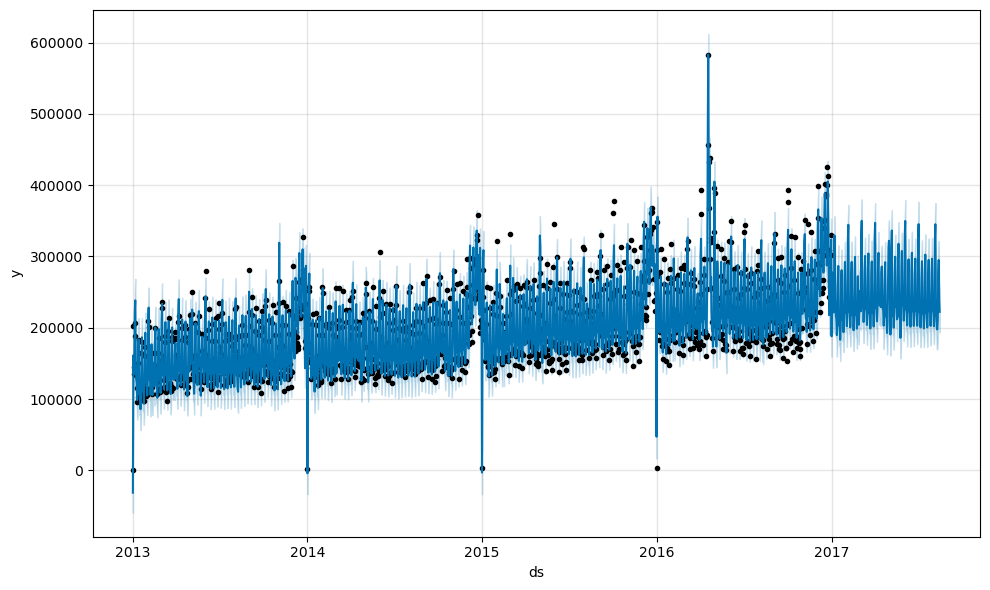

In [106]:
plt.figure(figsize=(14, 8))
fig1 = pr3.plot(df_pred3)
plt.show()

The command `pr1.plot(df_pred)` generates a **forecast plot** based on the predictions made by the Prophet model. Here's what is observed in the plot:

1. **Central Forecast Line (Dark Blue Line)**:  
   This represents the **predicted values (`yhat`)** for the sales target variable over time. It shows the model's expected trend and seasonality patterns.

2. **Observed Data Points (Black Dots)**:  
   These are the actual values from the dataset used during the model's training. They help visually compare the predicted results with the real data.

3. **Prediction Interval (Light Blue Shaded Area)**:  
   This is the **uncertainty range** for the forecast, representing an 80% confidence interval. It highlights the model's level of confidence in its predictions, widening as the forecast moves further into the future.

This plot allows a clear visual evaluation of how well the model fits the historical data and provides insight into expected future trends and uncertainties.

--- 

The plot clearly shows that the regressors used to account for the extreme outliers caused by the earthquake do not actually predict the event itself. Instead, they overfit to this unique occurrence. However, this behaviour helps train the model to recognize these days as anomalies, ensuring they are not treated as typical days during training.

New Year's Day remains a challenging day to model accurately. A separate model will be built to deal with this outlier holiday.

**Breakdown the components of the series**

<Figure size 1400x800 with 0 Axes>

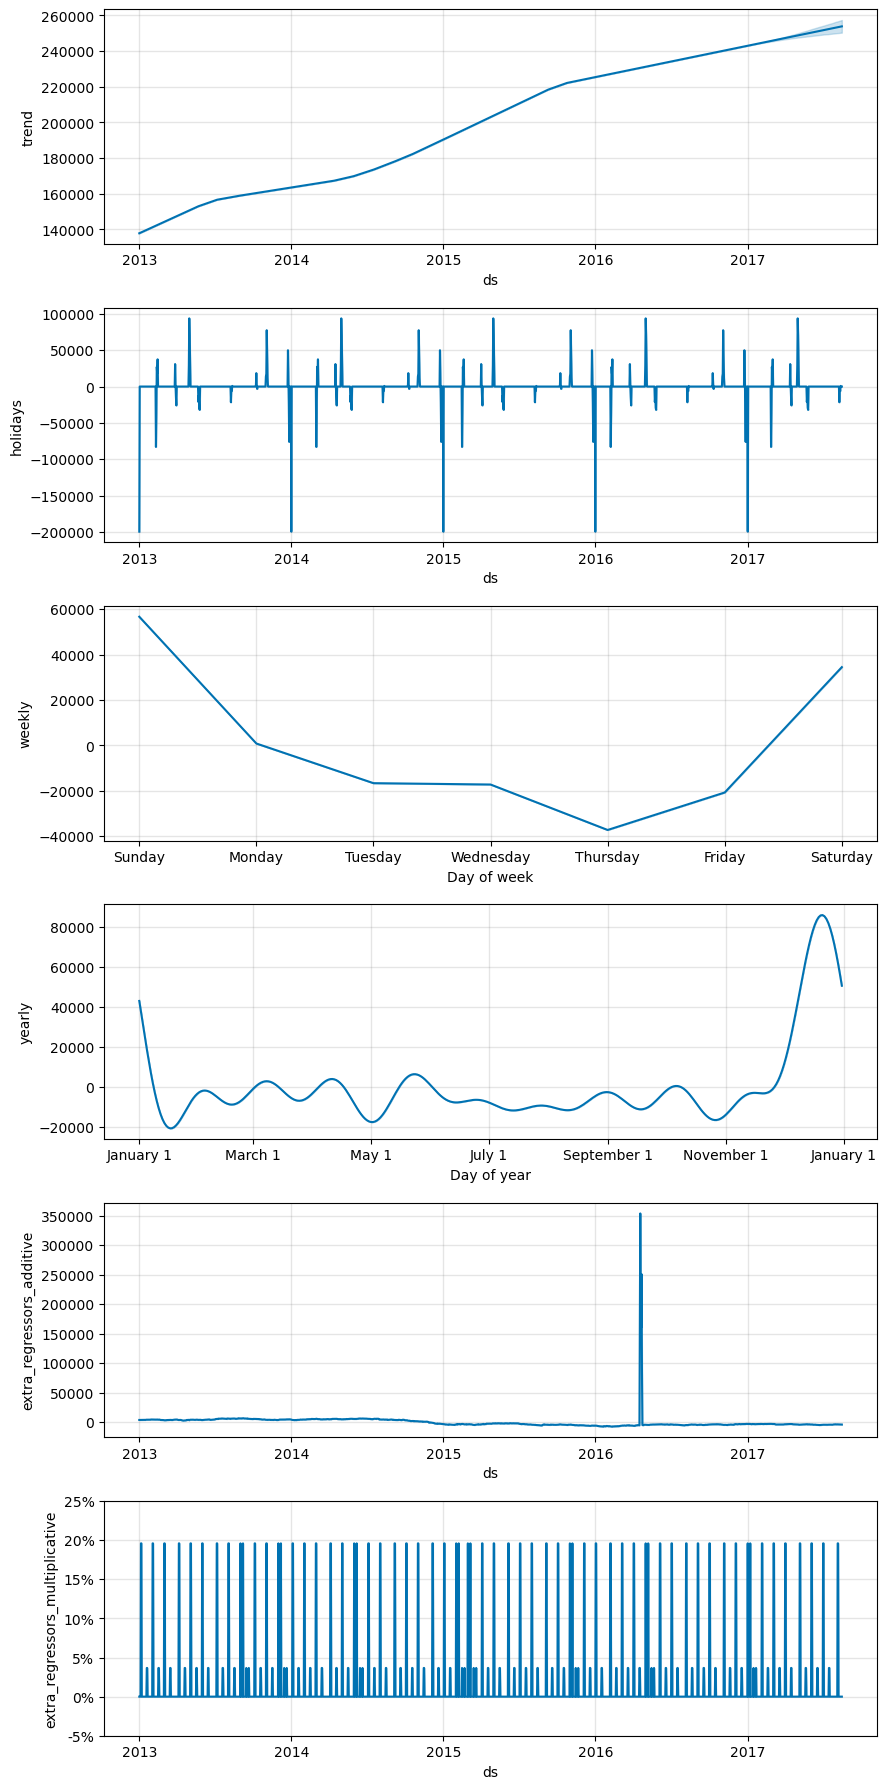

In [107]:
plt.figure(figsize=(14, 8))
pr3.plot_components(df_pred3)
plt.show()

The components of the series, as visualized using **FB Prophet**, are broken down into the following:

1. **Trend**  
   - A steady annual upward trend is observed, indicating that grocery sales have been consistently increasing over time.
<br><br>
2. **Holidays**  
   - Holiday effects reveal fascinating insights. Some holidays boost sales, while others have a negative impact.  
   - **Key Observations**:  
     - **New Year’s Day (01 January)**: Sales drop to near zero as most stores are closed.  
     - **Carnaval**: Many stores are closed on the first day (around 11 February), but sales recover on the second day.  
     - **Independence Day for Cuenca**: These holidays show continued sales activity, suggesting that stores remain open.
     - **Christmas Day** was excluded from the original dataset as all stores are closed on that day.
<br><br>
3. **Weekly**  
   - As confirmed in the previous boxplots, sales are consistently higher on weekends, with **Sundays** being the peak sales day of the week.
<br><br>
4. **Yearly**  
   - Seasonal effects align with key observations from the boxplots:  
     - Sales peak in **late December and early January**, coinciding with the Christmas and New Year period.  
     - **Mid-January** sees the lowest sales, followed by a similar drop in **late October**.  
     - A notable increase in sales occurs towards the **end of April**, coinciding with the **Easter holy week**.
<br><br>
5. **Additive Regressors**  
    - The addition of the earthquake regressors as additive factors introduces significant spikes of up to $350,000 in the days following the earthquake. This adjustment effectively accounts for this unique event in the series. Additionally, the additive regressors chart reveals a subtle fluctuation in sales linked to changes in oil prices.
<br><br>
6. **Multiplicative regressors**  
    - The first weekend of the month shows a multiplicative impact of 19.6%, while the first weekend after the 15th has a smaller multiplicative effect of approximately 3.6%.

**Filter the Predicted Test Set and Merge the Actual Sales Values to it**

In [108]:
# Prophet has predicted for the entire training set plus the additional 227 days in the test set.
# For now, we are only interested in the predictions including and beyond the cutoff date of 2017-01-01
df_test3 = df_pred3[df_pred3['ds'] >= test_start_date] 

In [109]:
# Ensure df_test3 is a standalone copy
df_test3 = df_test3.copy()

# Convert 'ds' to datetime in both dataframes to ensure consistency
df_test3['ds'] = pd.to_datetime(df_test3['ds'])
dfp['ds'] = pd.to_datetime(dfp['ds'])

#### Plot and Analyze the Forecast

**Merge the actual sales values to the predicted test set**

In [110]:
df_test3 = df_test3.merge(dfp[['ds', 'y']], on='ds', how='left')

In [111]:
df_test3.head()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0 2017-01-01  243009.442437  159625.409660  215800.323821  243009.442437   
1 2017-01-02  243057.520536  249332.204643  306268.844375  243057.520536   
2 2017-01-03  243105.598635  225857.668846  282814.365146  243105.598635   
3 2017-01-04  243153.676734  218314.162974  274493.076622  243153.676734   
4 2017-01-05  243201.754834  193011.603243  250280.087447  243201.754834   

     trend_upper      Año Nuevo  Año Nuevo_lower  Año Nuevo_upper  \
0  243009.442437 -199407.848469   -199407.848469   -199407.848469   
1  243057.520536       0.000000         0.000000         0.000000   
2  243105.598635       0.000000         0.000000         0.000000   
3  243153.676734       0.000000         0.000000         0.000000   
4  243201.754834       0.000000         0.000000         0.000000   

   Año Nuevo (observado)  Año Nuevo (observado)_lower  \
0                    0.0                          0.0   
1                    0.0                          0.0   
2                    0.0                          0.0   
3                    0.0                          0.0   
4                    0.0                          0.0   

   Año Nuevo (observado)_upper  Batalla de Pichincha  \
0                          0.0                   0.0   
1                          0.0                   0.0   
2                          0.0                   0.0   
3                          0.0                   0.0   
4                          0.0                   0.0   

   Batalla de Pichincha_lower  Batalla de Pichincha_upper  \
0                         0.0                         0.0   
1                         0.0                         0.0   
2                         0.0                         0.0   
3                         0.0                         0.0   
4                         0.0                         0.0   

   Batalla de Pichincha (observado)  Batalla de Pichincha (observado)_lower  \
0                               0.0                                     0.0   
1                               0.0                                     0.0   
2                               0.0                                     0.0   
3                               0.0                                     0.0   
4                               0.0                                     0.0   

   Batalla de Pichincha (observado)_upper  Carnaval  Carnaval_lower  \
0                                     0.0       0.0             0.0   
1                                     0.0       0.0             0.0   
2                                     0.0       0.0             0.0   
3                                     0.0       0.0             0.0   
4                                     0.0       0.0             0.0   

   Carnaval_upper  Día de Navidad  Día de Navidad_lower  Día de Navidad_upper  \
0             0.0             0.0                   0.0                   0.0   
1             0.0             0.0                   0.0                   0.0   
2             0.0             0.0                   0.0                   0.0   
3             0.0             0.0                   0.0                   0.0   
4             0.0             0.0                   0.0                   0.0   

   Día de los Difuntos  Día de los Difuntos_lower  Día de los Difuntos_upper  \
0                  0.0                        0.0                        0.0   
1                  0.0                        0.0                        0.0   
2                  0.0                        0.0                        0.0   
3                  0.0                        0.0                        0.0   
4                  0.0                        0.0                        0.0   

   Día del Trabajo  Día del Trabajo_lower  Día del Trabajo_upper  \
0              0.0                    0.0                    0.0   
1              0.0                    0.0                    0.0   
2              0.

the predicted values **yhat** and the actual sales values **y** can be seen on the right of the data frame.

**Merge the predictions with the actual data**

In [112]:
# Merge predictions with actual data over the entire dataset
df_pred3_long = df_pred3.merge(dfp[['ds', 'y']], on='ds', how='left')

# Create a plot dataset showing the last two years of the predictions.
# This comprises both the train and test set.
df_pred3_plt = df_pred3_long[df_pred3_long['ds'] >= '2015-08-15']

In [113]:
df_pred3_long.tail()

ds          trend     yhat_lower     yhat_upper    trend_lower  \
1679 2017-08-11  253682.780473  182234.087313  240165.478416  250261.504665   
1680 2017-08-12  253730.858573  246139.377427  305229.697316  250291.483750   
1681 2017-08-13  253778.936672  265238.221789  321773.901562  250315.848247   
1682 2017-08-14  253827.014771  209790.033823  267901.068627  250335.813858   
1683 2017-08-15  253875.092870  193413.902344  252102.943557  250358.672765   

        trend_upper  Año Nuevo  Año Nuevo_lower  Año Nuevo_upper  \
1679  257149.286368        0.0              0.0              0.0   
1680  257225.819748        0.0              0.0              0.0   
1681  257302.353128        0.0              0.0              0.0   
1682  257374.279080        0.0              0.0              0.0   
1683  257442.403647        0.0              0.0              0.0   

      Año Nuevo (observado)  Año Nuevo (observado)_lower  \
1679                    0.0                          0.0   
1680                    0.0                          0.0   
1681                    0.0                          0.0   
1682                    0.0                          0.0   
1683                    0.0                          0.0   

      Año Nuevo (observado)_upper  Batalla de Pichincha  \
1679                          0.0                   0.0   
1680                          0.0                   0.0   
1681                          0.0                   0.0   
1682                          0.0                   0.0   
1683                          0.0                   0.0   

      Batalla de Pichincha_lower  Batalla de Pichincha_upper  \
1679                         0.0                         0.0   
1680                         0.0                         0.0   
1681                         0.0                         0.0   
1682                         0.0                         0.0   
1683                         0.0                         0.0   

      Batalla de Pichincha (observado)  \
1679                               0.0   
1680                               0.0   
1681                               0.0   
1682                               0.0   
1683                               0.0   

      Batalla de Pichincha (observado)_lower  \
1679                                     0.0   
1680                                     0.0   
1681                                     0.0   
1682                                     0.0   
1683                                     0.0   

      Batalla de Pichincha (observado)_upper  Carnaval  Carnaval_lower  \
1679                                     0.0       0.0             0.0   
1680                                     0.0       0.0             0.0   
1681                                     0.0       0.0             0.0   
1682                                     0.0       0.0             0.0   
1683                                     0.0       0.0             0.0   

      Carnaval_upper  Día de Navidad  Día de Navidad_lower  \
1679             0.0             0.0                   0.0   
1680             0.0             0.0                   0.0   
1681             0.0             0.0                   0.0   
1682             0.0             0.0                   0.0   
1683             0.0             0.0                   0.0   

      Día de Navidad_upper  Día de los Difuntos  Día de los Difuntos_lower  \
1679                   0.0                  0.0                        0.0   
1680                   0.0                  0.0                        0.0   
1681                   0.0                  0.0                        0.0   
1682                   0.0                  0.0                        0.0   
1683                   0.0                  0.0                        0.0   

      Día de los Difuntos_upper  Día del Trabajo  Día del Trabajo_lower  \
1679                        0.0              0.0                    0.0   
1680                        0.0              0.0 

#### Plot Predicted vs. Actual Sales

This code overlays the predicted sales values on top of the actual sales data to visually evaluate the model's performance.

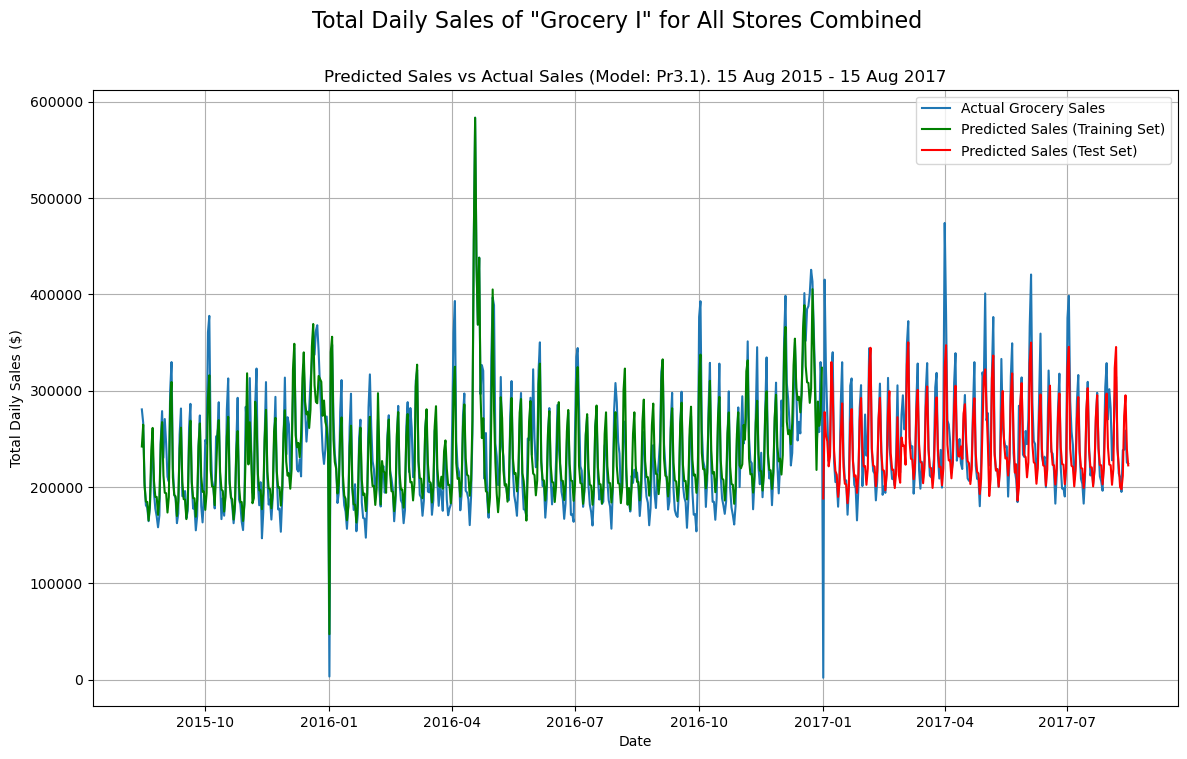

In [114]:
model_name = 'Pr3.1'
plot_train_set(test_start_date, df_pred3_plt, model_name)

#### Plot Observations:
This plot shows the last two years of predictions, including the end of the training data and the entire test set.
1. **Actual Sales (Blue Line)**:  
   The actual observed grocery sales over time are plotted as a reference for evaluating the model's predictions.
<br><br>
2. **Predicted Sales (Green and Red Lines)**:  
   - **Green Line**: Represents the model's predictions (`yhat`) on the training data (before the test start date). This shows how well the model fits the historical data it was trained on.  
   - **Red Line**: Represents the predictions for the test set (after the test start date). This highlights the model's performance on unseen data.
<br><br>
3. **Title and Axes**:  
   The title provides an overview of the dataset and model, while the x-axis and y-axis show the dates and sales values ($US), respectively.

Overall, the model captures the seasonlity of the grocery sales very well, particularly on the training set. 

- **Impact of Extra Regressors:**  
  The additional regressors for earthquake-related outliers align perfectly with the observed spikes in sales, indicating the model now effectively captures the impact of this unique event.

- **Weekend Peaks:**  
  Predictions for higher sales peaks following weekends after payday show noticeable improvement in both the training and test sets.

- **New Year's Day Holiday:**  
  After reintegrating New Year’s Day into the holidays DataFrame as an additive regressor instead of a multiplicative regressor, its predictions have shown a slight decline compared to Model Pr2.2 in the full report. The decision to retain New Year’s Day as an additive regressor was made because it resulted in a slight improvement in the test set performance. The large prediction error for this holiday will now be dealt with by creating a separate model for New Year's Day.

#### Calculate Performance Metrics for the Training Set: Model Pr3.1 
Note these figures are for the entire four years of the training set, not just the green period displayed above.

In [115]:
# Prophet has predicted for the entire training set plus the additional 227 days in the test set.

# Merge the actual sales values to the predicted test set
df_train3 = df_pred3[['ds', 'yhat']].merge(dfp, on='ds', how='left')

In [116]:
# Filter for training data only, before the cutoff date of 2017-01-01
df_train3 = df_train3[df_train3['ds'] < test_start_date]

In [117]:
# Call the function to calculate the performance metrics
rmse_trn3, mae_trn3, mape_trn3, accuracy_trn3 = calculate_metrics(df_train3)

In [118]:
# Print the performance metrics
print(f'{"RMSE:":<{label_width}} {round(rmse_trn3, 2):<{value_width}}')
print(f'{"MAE:":<{label_width}} {round(mae_trn3, 2):<{value_width}}')
print(f'{"MAPE:":<{label_width}} {round(mape_trn3, 2)}%')
print(f'{"Accuracy:":<{label_width}} {round(100 - mape_trn3,2)}%')

RMSE:      22418.38       
MAE:       16197.24       
MAPE:      12.47%
Accuracy:  87.53%


**Summary Training Set Metrics of Model Pr3.1**

- **RMSE (Root Mean Square Error):** is **22,418**.
- **MAE (Mean Absolute Error):** is **16,197**.
- **MAPE (Mean Absolute Percentage Error):** is **12.47%**. 

Many steps were taken to achieve these good results in the metrics. These results demonstrate that implementing holidays and regressors for the earthquake and weekends after payday substantially improve the modelling performance on the training set. New Year's Day still remains a significant problem. Before evaluating on the test set, a special model to treat this holiday separately will be made.

### <span style="color: darkblue;">Create a Prophet model for New Year's Day Only and Merge with Pr3.1</span>

To address the poor performance of predicting New Year's Day, several options were considered.

#### Options Considered
1. **Dynamic Multiplicative Regressor Scaling**: 
   Adjusting the regressor dynamically based on historical sales trends and scaling factors.

2. **Expanded Holiday Windows**: 
   Testing extended pre/post-holiday periods to better capture sales patterns around New Year's.

3. **Rule-Based Adjustments**: 
   Applying post-prediction adjustments, such as capping sales predictions or introducing decay factors based on prior day sales.

4. **Hybrid Models**: 
   Integrating a lightweight linear regression or separate model specifically for New Year's Day into the Prophet framework.

#### Chosen Solution
Creating a **Prophet model specifically for New Year's Day** proved to be highly effective. This approach isolates the holiday’s unique sales behaviour and merges the resulting predictions with the broader Pr3.1 model. It significantly reduces test set MAPE while remaining efficient to implement.
To address the persistent inaccuracies for New Year's Day, several approaches were evaluated:

#### Create a Function for New Year's Day Only and Merge with Pr3.1  

This function will create a simple Prophet model for New Year's Day only, and replace the predicted value for 01/01/2017 in the test set with the predicted value from this function. This will drastically reduce the MAPE in the test set results.

**Function to model New Year's Day Only** 

In [119]:
def model_new_years_day_prophet(df, df_test):
    # Filter data for January 1st only in the training set
    df_jan1 = df[(df['ds'].dt.month == 1) & (df['ds'].dt.day == 1)]

    # Create a new Prophet model
    model_jan1 = Prophet(yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=False)
    
    # Fit the model on the January 1st data
    model_jan1.fit(df_jan1[['ds', 'y']])
    
    # Filter the test set for January 1st only
    df_test_jan1 = df_test[(df_test['ds'].dt.month == 1) & (df_test['ds'].dt.day == 1)]

    # Make predictions on the test set
    df_test_jan1 = model_jan1.predict(df_test_jan1[['ds']])

    # Insert the predictions back into the original test set
    df_test.loc[(df_test['ds'].dt.month == 1) & (df_test['ds'].dt.day == 1), 'yhat'] = df_test_jan1['yhat'].values
    
    # Plotting the train set and test set
    plt.figure(figsize=(14, 8))
    # Plot the training data
    plt.plot(df_jan1['ds'], df_jan1['y'], label='Train Set - Actual', marker='o')
    # Plot the test data and predictions
    plt.plot(df_test_jan1['ds'], df_test_jan1['yhat'], label='Test Set - Predicted', marker='x')
    if 'y' in df_test.columns:
        plt.plot(df_test_jan1['ds'], df_test.loc[df_test_jan1.index, 'y'], label='Test Set - Actual', marker='o')
    
    plt.title("Sales on January 1st - Train and Test Sets")
    plt.xlabel("Date")
    plt.ylabel("Sales")
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return df_test

**Call the New Year's Day Function**  
This will add an improved prediction for New Year's Day to the test set by modelling New Year's Day separately from the other data. It will replace the previously predicted value for 01 January in the test set.

13:11:52 - cmdstanpy - INFO - Chain [1] start processing
13:11:52 - cmdstanpy - INFO - Chain [1] done processing


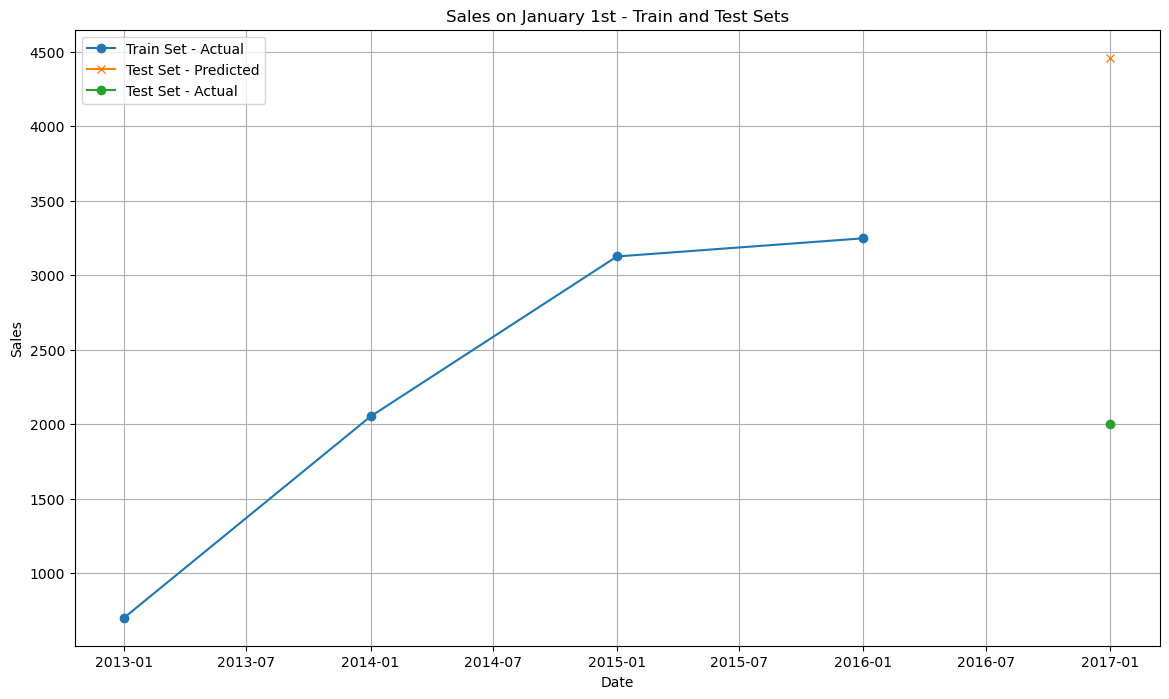

In [120]:
df_test3 = model_new_years_day_prophet(df_train, df_test3)

As observed above, the actual sales value for 01 January 2017 is **\\$2,000**, while the historical trend suggests an upward trajectory, leading the model to forecast nearly **\\$4,500**. Although this represents a significant error, it is a notable improvement compared to **Model Pr3.1**, which predicted an inflated value of approximately **\\$190,000** for the same date. While the error in the chart above could be considered large, it is an enormous improvement and the adjustments made in this model drastically improve the accuracy in the overall modelling results. 

#### Plot and Analyze the Forecast

**Plot the test set predictions in more detail**

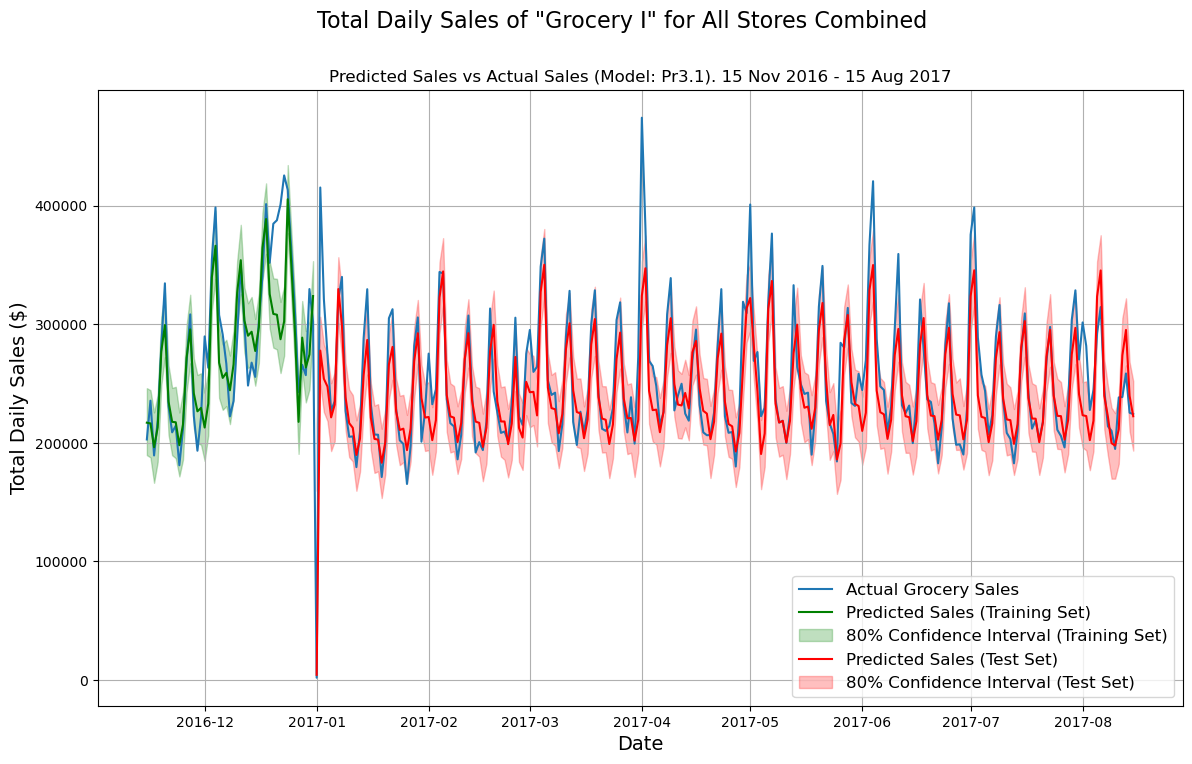

In [121]:
plot_test_set(model_name, df_pred3_plt, df_test3)

#### Observations from the Plot

This plot shows the predictions from 15 November 2016 to 15 August 2017, with green representing predictions on the training data and red representing predictions on the independent test data. The blue line is of course the actual sales data. This plot shows greater detail on the test set results.

- Overall, the model captures the seasonlity of the grocery sales very well, particularly on the training set.

- **Weekend Peaks:**  
  Predictions for higher sales peaks following weekends after payday show good results in both the training and test sets.

- **New Year's Day Holiday:**  
  After imputing the predicted value from the special model, it has vastly improved.

#### Calculate Performance Metrics for the Test Set: Model Pr3.1 

The predictions cover the specified period after the training set cutoff, from **01 January 2017** to **15 August 2017**.

In [122]:
# Call the function to calculate the performance metrics
rmse_pr3, mae_pr3, mape_pr3, accuracy_pr3 = calculate_metrics(df_test3)

In [123]:
# Print the performance metrics
print(f'{"RMSE:":<{label_width}} {round(rmse_pr3, 2):<{value_width}}')
print(f'{"MAE:":<{label_width}} {round(mae_pr3, 2):<{value_width}}')
print(f'{"MAPE:":<{label_width}} {round(mape_pr3, 2)}%')
print(f'{"Accuracy:":<{label_width}} {round(100 - mape_pr3, 2)}%')

RMSE:      28133.27       
MAE:       19643.92       
MAPE:      7.76%
Accuracy:  92.24%


**Summary Test Set Metrics of Model Pr3.1 compared to the Training Set Metrics**

- **RMSE (Root Mean Square Error):** Increased substantially, from **22,418** to **28,133**.
- **MAE (Mean Absolute Error):** Increased substantially, from **16,197** to **19,643**.
- **MAPE (Mean Absolute Percentage Error):** Improved significantly, dropping from **12.47%** to **7.76%**.

Imputing New Year's Day values in the test set using a dedicated model specifically for this holiday has greatly contributed to the reduction in MAPE.

The inclusion of regressors for holidays, earthquake-related outliers and weekends following payday has been highly effective, significantly enhancing the model's overall performance compared to previous models in the complete report.

In this situation, the test set results may appear worse than the training set due to the presence of unique events or patterns in the test data, such as economic shifts or unforseen events, that were not fully represented in the training data, e.g., 01 April 2017. These discrepancies highlight the challenges of generalizing time-series models to unseen data rather than indicating overfitting.

**Summary on Oil as a Regressor**  
The inclusion of oil prices (`dcoilwtico`) as a regressor resulted in only marginal improvements in model performance:  
- **RMSE:** Decreased from **28,348** to **28,133**.  
- **MAPE:** Dropped slightly from **7.80%** to **7.76%**.  

While these small improvements indicate that oil prices have some influence on sales, they are not a dominant driver. Moreover, the test set included actual oil prices, which would not be available in real-world forecasting scenarios. Accurately predicting future oil prices introduces additional uncertainty and complexity that could outweigh the minor improvements in accuracy.  

Given these considerations, excluding oil prices as a regressor in future models is advisable. This ensures that the model relies only on variables that are known or can be accurately forecasted at the time of prediction, enhancing the model’s practicality and robustness.

Additionally, groceries are essential items for survival, so consumers consistently allocate funds for groceries, even when oil prices rise and reduce disposable income. Categories such as **Beauty** or **Lingerie** might experience a greater sensitivity to changes in oil prices, as they are discretionary rather than essential.

**Summary on "On Promotion" as a Regressor**  
The inclusion of the "on promotion" regressor significantly worsened model performance:  
- **RMSE:** Increased to **44,510.33**.  
- **MAPE:** Rose to **13.86%**, reducing accuracy to **86.14%**.  

These results suggest that **on promotion** introduces noise or fails to capture meaningful patterns, making it unsuitable as a regressor. Alternatively, the **log of on promotion** performed better, with an RMSE of **32,335** and a MAPE of **8.91%**. However, excluding this variable entirely yielded the best performance.

For groceries, promotions may not have a significant impact on total sales since they are essential items purchased regularly regardless of discounts. In contrast, **on promotion** could have a more pronounced effect in non-essential categories, where consumer spending is more elastic and influenced by discounts.


#### Display the 30 Days with the Largest Prediction Error in the Training Set
The following analysis identifies the 30 days with the largest absolute prediction errors in the training set, calculated as the difference between predicted (`yhat`) and actual (`y`) sales.

In [124]:
# Create a column of the daily error
df_train3['Error'] = df_train3['yhat'] - df_train3['y']
df_train3['Abs_Error'] = np.abs(df_train3['yhat'] - df_train3['y'])

In [125]:
# Create a temporary dataset
df_temp = df_train3[['ds','y','yhat','Error','Abs_Error']]

In [126]:
# Display the 30 largest prediction errors
df_temp.nlargest(30,'Abs_Error')

ds           y           yhat          Error      Abs_Error
1449 2016-12-23  425386.443  302332.025577 -123054.417423  123054.417423
724  2014-12-28  193133.453  312079.894779  118946.441779  118946.441779
1448 2016-12-22  400889.065  287291.374944 -113597.690056  113597.690056
1243 2016-05-31  322106.164  213936.052925 -108170.111075  108170.111075
1214 2016-05-02  388655.729  280896.691823 -107759.037177  107759.037177
720  2014-12-23  357665.078  254897.898205 -102767.179795  102767.179795
361  2013-12-29  186041.000  286952.776135  100911.776135  100911.776135
878  2015-05-31  345804.682  264312.639428  -81492.042572   81492.042572
1084 2015-12-23  367851.184  286855.069760  -80996.114240   80996.114240
1447 2016-12-21  387603.442  307951.005366  -79652.436634   79652.436634
669  2014-11-02  203896.842  282392.555447   78495.713447   78495.713447
1152 2016-03-01  281908.060  204800.254039  -77107.805961   77107.805961
1427 2016-12-01  289689.792  212875.319421  -76814.472579   76814.472579
971  2015-09-01  270499.490  193942.840766  -76556.649234   76556.649234
1446 2016-12-20  384623.784  308666.338852  -75957.445148   75957.445148
1205 2016-04-23  326432.713  250738.384141  -75694.328859   75694.328859
356  2013-12-23  326975.000  252863.726949  -74111.273051   74111.273051
1083 2015-12-22  362154.403  288258.997700  -73895.405300   73895.405300
1001 2015-10-01  248701.812  176229.052031  -72472.759969   72472.759969
1398 2016-11-02  294122.549  223551.109072  -70571.439928   70571.439928
360  2013-12-28  200073.000  269883.579093   69810.579093   69810.579093
1185 2016-04-03  392994.414  324763.936125  -68230.477875   68230.477875
1003 2015-10-03  360545.262  292996.905476  -67548.356524   67548.356524
1305 2016-08-01  287706.632  221547.677507  -66158.954493   66158.954493
1088 2015-12-28  223897.335  289729.682760   65832.347760   65832.347760
1183 2016-04-01  264279.916  200330.706608  -63949.209392   63949.209392
1366 2016-10-01  376487.399  314323.631882  -62163.767118   62163.767118
909  2015-07-01  245410.095  183443.449470  -61966.645530   61966.645530
1212 2016-04-30  334747.624  272907.532606  -61840.091394   61840.091394
1004 2015-10-04  377564.834  315903.104662  -61661.729338   61661.729338

#### Observations of the Largest Prediction Errors

1. **Underprediction Patterns**
    - Most of the largest errors are negative, where the model underpredicts actual sales.
    - Many of these days occur on the **first day of the month**, likely influenced by consumers shopping for groceries shortly after being paid. This suggests that **payday effects** could be an important regressor to include in the model.
<br><br>
2. **Overprediction Patterns**
    - In the few instances where the model overpredicts, **28 December** stands out. This date appears repeatedly and may need to be incorporated as a regressor to account for **post-Christmas shopping behaviour**.
    
---

### <span style="color: darkblue;">Prophet Model 5. Cross Validation and Hyperparameter Optimization</span>
#### <span style="color: darkblue;">Additional Regressors For the First Day of the Month and 28 December</span>

To address the significant prediction errors observed for these dates in the training set, **the first day of the month** and **28 December** were added as regressors. These adjustments aim to capture the unique sales patterns associated with these dates and improve the model's accuracy.  

While it was considered to include an additional regressor for **02 January** due to noticeable prediction discrepancies in the test set, this was ultimately avoided. Incorporating such a regressor would constitute **data leakage**, as it uses information from the test set that would not typically be available during model training. Avoiding data leakage ensures the integrity and generalizability of the model.


**Create New Regessors to flag identified days with large errors**

In [127]:
# Flag the first day of the month for all months except January if it is not a weekend
dfg1['is_1st_day_non_weekend_excl_jan'] = (
    (dfg1['dayofmonth'] == 1) & 
    (dfg1['dayofweek'] < 5) & 
    (dfg1['month'] != 1)
).astype(int)

# Flag 28 December
dfg1['is_28_december'] = ((dfg1['dayofmonth'] == 28) & (dfg1['month'] == 12)).astype(int)


#### <span style="color: darkblue;">Hyperparameter Tuning</span>

The final Prophet model incorporates all selected features and is now ready for optimization through hyperparameter tuning. Hyperparameter tuning is the process of systematically adjusting the model's configuration parameters to achieve optimal performance. Cross-validation will be employed to evaluate the model's performance by testing its predictions further into the future within the training set. This process helps to fine-tune the model parameters, improving its accuracy and robustness for forecasting future trends.

**Make a copy of df grocery (dfg1) to df predict (dfp)**

In [128]:
# Make a copy of df grocery (dfg1) to df predict (dfp)
dfp = dfg1.copy()

In [129]:
# Display the updated DataFrame
dfp.tail()

sales  onpromotion  dcoilwtico  log_onpromotion       date  \
date                                                                          
2017-08-11  238221.922    43.500000   48.810000         3.772761 2017-08-11   
2017-08-12  238627.633    43.055556   48.403333         3.762491 2017-08-12   
2017-08-13  258442.452    42.962963   47.996667         3.760338 2017-08-13   
2017-08-14  225355.694    43.240741   47.590000         3.766783 2017-08-14   
2017-08-15  224208.125    42.518519   47.570000         3.749940 2017-08-15   

            hour  dayofweek   weekday  quarter  month month_name  year  \
date                                                                     
2017-08-11     0          4    Friday        3      8     August  2017   
2017-08-12     0          5  Saturday        3      8     August  2017   
2017-08-13     0          6    Sunday        3      8     August  2017   
2017-08-14     0          0    Monday        3      8     August  2017   
2017-08-15     0          1   Tuesday        3      8     August  2017   

            dayofyear  dayofmonth  weekofyear  date_offset season  \
date                                                                
2017-08-11        223          11          32          491    Dry   
2017-08-12        224          12          32          492    Dry   
2017-08-13        225          13          32          493    Dry   
2017-08-14        226          14          33          494    Dry   
2017-08-15        227          15          33          495    Dry   

            first_weekend_of_month  first_weekend_after_15th  \
date                                                           
2017-08-11                       0                         0   
2017-08-12                       0                         0   
2017-08-13                       0                         0   
2017-08-14                       0                         0   
2017-08-15                       0                         0   

            earthquake_1_day_after  eq_2_days_after  eq_3_days_after  \
date                                                                   
2017-08-11                       0                0                0   
2017-08-12                       0                0                0   
2017-08-13                       0                0                0   
2017-08-14                       0                0                0   
2017-08-15                       0                0                0   

            eq_4_days_after  eq_5_days_after  eq_6_days_after  LogOfPromotion  \
date                                                                            
2017-08-11                0                0                0        3.795489   
2017-08-12                0                0                0        3.785451   
2017-08-13                0                0                0        3.783348   
2017-08-14                0                0                0        3.789646   
2017-08-15                0                0                0        3.773187   

            is_1st_day_non_weekend_excl_jan  is_28_december  
date                                                         
2017-08-11                                0               0  
2017-08-12                                0               0  
2017-08-13                                0               0  
2017-08-14                                0               0  
2017-08-15                                0               0

The new features have been added.

**Make a copy of df grocery (dfg1) to df predict (dfp)**

In [130]:
# Make a copy of df grocery (dfg1) to df predict (dfp)
dfp = dfg1.copy()

#### Prepare the data frame for modelling with Prophet

In [131]:
# Step 1: Drop the existing 'date' column
# The index is the date. The date column should be dropped, to avoid duplication.
if 'date' in dfp.columns:
    dfp = dfp.drop(columns=['date'])

In [132]:
# Step 2: Reset the index to create the 'date' column
dfp = dfp.reset_index()

In [133]:
# Step 3: Rename the columns: 'sales' to 'y' and 'index' (former date index) to 'ds' as is required for Prophet
dfp = dfp.rename(columns={'sales': 'y', 'date': 'ds'})

In [134]:
# Step 4: Keep only the 'ds', 'y' and the chosen regressor columns
dfp = dfp[['ds', 'y', 'first_weekend_of_month', 'first_weekend_after_15th', 'dcoilwtico', 
           'onpromotion', 'LogOfPromotion', 'earthquake_1_day_after', 'eq_2_days_after', 
            'eq_3_days_after', 'eq_4_days_after', 'eq_5_days_after', 'eq_6_days_after', 
           'is_1st_day_non_weekend_excl_jan', 'is_28_december']]

In [135]:
# Step 5: Ensure 'y' is numeric
dfp['y'] = pd.to_numeric(dfp['y'], errors='coerce')

**Create the training sets**  
The training set is from 01/01/2013 to 31/12/2016.  
The test set is from 01/01/2017 to 15/08/2017.

In this project there are 4 full years of training data to predict the first 7.5 months of 2017.

In [136]:
df_train5 = dfp[(dfp['ds'] < test_start_date) ]

#### **Hyperparameter Tuning**  
To improve model performance, hyperparameters can be tuned in Prophet

**Set up an initial paramter grid**

In [137]:
# Set up an initial parameter grid with an extensive list of parameters to be tuned

param_grid = {
    'changepoint_prior_scale': [0.005, 0.01, 0.05, 0.1, 0.2],  # flexibility of trend changepoints
    'seasonality_prior_scale': [0.1, 1.0, 5.0, 10.0],  # flexibility of seasonal components
    'holidays_prior_scale': [0.05, 0.1, 1.0, 5.0, 10.0],  # flexibility of holidays
    'seasonality_mode': ['additive', 'multiplicative'],  # whether seasonality is additive or multiplicative
    'n_changepoints': [10, 25, 50, 75],  # number of potential trend changepoints
    'yearly_seasonality': [10, 20, 30],  # Fourier order for yearly seasonality
    'weekly_seasonality': [2, 3, 5, 7]  # Fourier order for weekly seasonality
}


# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for all parameter cominations here

#### Use cross validation to evaluate all parameters
This section of the script performs **hyperparameter optimization** for the Prophet model using **cross-validation** to evaluate various parameter combinations. For each parameter set in `all_params`:

1. A new instance of Prophet is created, incorporating:
   - Ecuador-specific holiday data.
   - Multiple additional regressors (e.g., `dcoilwtico`, earthquake-related effects, special dates) to capture external influences on the time series.
<br><br>
2. The model is trained on the provided training dataset (`df_train5`) with the specified parameters.
<br><br>
3. **Cross-Validation**:
   - The script applies cross-validation using:
     - **Initial period**: `1095 days` (3 years) for training, to capture long-term trends and yearly seasonality.
     - **Period**: `31 days` to assess model performance monthly.
     - **Horizon**: `227 days` to test the model’s ability to forecast into the future, aligning with the test set duration (up to August 15, 2017).
   - Parallel processing (`parallel="processes"`) accelerates the computation.
<br><br>
4. **Performance Metrics**:
   - The RMSE (Root Mean Squared Error) is computed for each parameter set and stored in the `rmses` list for comparison.

This process evaluates the performance of different hyperparameter combinations, enabling the selection of the optimal configuration for accurate and robust future forecasting.


<span style="color: red;">**Code below is commented out as it takes a long time execute and printo out a summary if each iteration, which becomes very large.   
The results from a previous run have been saved and loaded below.**</span>

In [138]:
"""
# Record the start time
start_time = time.time()

# Use cross validation to evaluate all parameters
for params in all_params:
    # Create an instance of the model and add the holiday data to it
    pr5 = Prophet(**params, holidays=ecuador_holidays_df)
    
    # Add the regressors to the model
    pr5.add_regressor('first_weekend_of_month', mode='multiplicative')
    pr5.add_regressor('first_weekend_after_15th', mode='multiplicative')
    pr5.add_regressor('dcoilwtico')
    #pr5.add_regressor('onpromotion'')
    #pr5.add_regressor('LogOfPromotion')
    pr5.add_regressor('earthquake_1_day_after')
    pr5.add_regressor('eq_2_days_after')
    pr5.add_regressor('eq_3_days_after')
    pr5.add_regressor('eq_4_days_after')
    pr5.add_regressor('eq_5_days_after')
    pr5.add_regressor('eq_6_days_after')
    pr5.add_regressor('is_1st_day_non_weekend_excl_jan')
    pr5.add_regressor('is_28_december')
    
    pr5.fit(df_train5)  # Fit model with given params
    
    df_cv = cross_validation(pr5, initial='1095 days', period='31 days', horizon = '227 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Record the end time
end_time = time.time()

# Calculate and print the total execution time
execution_time = end_time - start_time

# Convert to hours, minutes, and seconds
hours, remainder = divmod(execution_time, 3600)
minutes, seconds = divmod(remainder, 60)

# Print the formatted execution time
print(f"Total execution time: {int(hours)} hours, {int(minutes)} minutes, and {seconds:.2f} seconds")
"""

'\n# Record the start time\nstart_time = time.time()\n\n# Use cross validation to evaluate all parameters\nfor params in all_params:\n    # Create an instance of the model and add the holiday data to it\n    pr5 = Prophet(**params, holidays=ecuador_holidays_df)\n    \n    # Add the regressors to the model\n    pr5.add_regressor(\'first_weekend_of_month\', mode=\'multiplicative\')\n    pr5.add_regressor(\'first_weekend_after_15th\', mode=\'multiplicative\')\n    pr5.add_regressor(\'dcoilwtico\')\n    #pr5.add_regressor(\'onpromotion\'\')\n    #pr5.add_regressor(\'LogOfPromotion\')\n    pr5.add_regressor(\'earthquake_1_day_after\')\n    pr5.add_regressor(\'eq_2_days_after\')\n    pr5.add_regressor(\'eq_3_days_after\')\n    pr5.add_regressor(\'eq_4_days_after\')\n    pr5.add_regressor(\'eq_5_days_after\')\n    pr5.add_regressor(\'eq_6_days_after\')\n    pr5.add_regressor(\'is_1st_day_non_weekend_excl_jan\')\n    pr5.add_regressor(\'is_28_december\')\n    \n    pr5.fit(df_train5)  # Fit mo

With the hyperparamter grid-search list of parameters above, this search took 4 hours and 33 minutes to execute.

#### Justification of Chosen Parameter Values

1. **`initial='1095 days'`**:
   - A 3-year training period provides sufficient data for learning long-term trends, yearly seasonality, and holiday effects.
<br><br>
2. **`period='31 days'`**:
   - Monthly intervals balance the need for granular validation results with computational efficiency.
<br><br>
3. **`horizon='227 days'`**:
   - Matches the test set duration (January 1, 2017 – August 15, 2017) to ensure cross-validation closely aligns with the actual forecasting needs.
<br><br>
4. **Additional Considerations**:
   - Including external regressors ensures the model captures critical events (e.g., earthquakes) and domain-specific influences (e.g., oil prices, special dates like payday effects).
   - Parallel processing (`parallel="processes"`) minimizes execution time for this computationally expensive task.

#### Save the cross validation results and observe the best hyperparameters

In [139]:
"""
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
"""

"\n# Find the best parameters\ntuning_results = pd.DataFrame(all_params)\ntuning_results['rmse'] = rmses\n"

In [140]:
"""
# Save the DataFrame as a CSV file
tuning_results.to_csv('./data/prophet_5_grid_search_results.csv', index=False)

# Save the cross-validations results as a CSV file.
df_cv.to_csv('./data/cross_validation_results_pr5.csv', index=False)
"""

"\n# Save the DataFrame as a CSV file\ntuning_results.to_csv('./data/prophet_5_grid_search_results.csv', index=False)\n\n# Save the cross-validations results as a CSV file.\ndf_cv.to_csv('./data/cross_validation_results_pr5.csv', index=False)\n"

In [141]:
# Load the saved CSV files into their respective DataFrames
tuning_results = pd.read_csv('./data/prophet_5_grid_search_results.csv')
df_cv = pd.read_csv('./data/cross_validation_results_pr5.csv')

In [142]:
# Display the top 20 results
tuning_results.sort_values('rmse').head(20)

changepoint_prior_scale  seasonality_prior_scale  holidays_prior_scale  \
2639                    0.010                      0.1                  0.05   
1391                    0.005                      5.0                  0.05   
3295                    0.010                      1.0                  0.05   
2655                    0.010                      0.1                  0.05   
2031                    0.005                     10.0                  0.05   
1999                    0.005                     10.0                  0.05   
4559                    0.010                     10.0                  0.05   
3279                    0.010                      1.0                  0.05   
1519                    0.005                      5.0                  0.10   
4607                    0.010                     10.0                  0.05   
719                     0.005                      1.0                  0.05   
2015                    0.005                     10.0                  0.05   
895                     0.005                      1.0                  0.10   
2175                    0.005                     10.0                  0.10   
207                     0.005                      0.1                  0.10   
3311                    0.010                      1.0                  0.05   
1375                    0.005                      5.0                  0.05   
3951                    0.010                      5.0                  0.05   
2671                    0.010                      0.1                  0.05   
735                     0.005                      1.0                  0.05   

     seasonality_mode  n_changepoints  yearly_seasonality  weekly_seasonality  \
2639   multiplicative              10                  30                   7   
1391   multiplicative              50                  30                   7   
3295   multiplicative              25                  30                   7   
2655   multiplicative              25                  30                   7   
2031   multiplicative              50                  30                   7   
1999   multiplicative              10                  30                   7   
4559   multiplicative              10                  30                   7   
3279   multiplicative              10                  30                   7   
1519   multiplicative              50                  30                   7   
4607   multiplicative              75                  30                   7   
719    multiplicative              10                  30                   7   
2015   multiplicative              25                  30                   7   
895    multiplicative              75                  30                   7   
2175   multiplicative              75                  30                   7   
207    multiplicative              10                  30                   7   
3311   multiplicative              50                  30                   7   
1375   multiplicative              25                  30                   7   
3951   multiplicative              50                  30                   7   
2671   multiplicative              50                  30                   7   
735    multiplicative              25                  30                   7   

              rmse  
2639  41878.212478  
1391  41896.214139  
3295  41899.175549  
2655  41904.746282  
2031  41905.102645  
1999  41905.790007  
4559  41908.741257  
3279  41909.878317  
1519  41911.982345  
4607  41912.646285  
719   41913.349810  
2015  41914.081858  
895   41916.502421  
2175  41920.932640  
207   41921.397098  
3311  41923.662296  
1375  41926.530679  
3951  41927.321722  
2671  41927.974469  
735   41928.895116

**Display the best hyperparameters**

In [143]:
# Display the best hyperparameters
tuning_results.sort_values('rmse').reset_index(drop=True).iloc[0]

changepoint_prior_scale              0.01
seasonality_prior_scale               0.1
holidays_prior_scale                 0.05
seasonality_mode           multiplicative
n_changepoints                         10
yearly_seasonality                     30
weekly_seasonality                      7
rmse                         41878.212478
Name: 0, dtype: object

In [144]:
# Store the best hyperparameters in a dictionary
best_parameters = dict(tuning_results.sort_values('rmse').reset_index(drop=True).drop('rmse',axis='columns').iloc[0])

best_parameters

{'changepoint_prior_scale': 0.01,
 'seasonality_prior_scale': 0.1,
 'holidays_prior_scale': 0.05,
 'seasonality_mode': 'multiplicative',
 'n_changepoints': 10,
 'yearly_seasonality': 30,
 'weekly_seasonality': 7}

In [145]:
# Convert the saved Columns to Datetime
df_cv['ds'] = pd.to_datetime(df_cv['ds'])
df_cv['cutoff'] = pd.to_datetime(df_cv['cutoff'])

**Plot the cross-validation performance metrics**

In [146]:
df_p = performance_metrics(df_cv)
df_p

horizon           mse          rmse           mae      mape     mdape  \
0    23 days  2.804676e+09  52959.195092  25410.413904  0.088853  0.054090   
1    24 days  1.942751e+09  44076.648208  22749.639352  0.083952  0.054163   
2    25 days  1.570253e+09  39626.423221  21020.516048  0.080114  0.054163   
3    26 days  1.169486e+09  34197.751055  19039.718365  0.074903  0.053285   
4    27 days  7.522528e+08  27427.226708  17293.462739  0.070621  0.052459   
..       ...           ...           ...           ...       ...       ...   
200 223 days  8.956983e+08  29928.218533  23520.973729  0.099555  0.092779   
201 224 days  9.234287e+08  30387.969933  23905.742922  0.101677  0.091499   
202 225 days  9.207709e+08  30344.206579  23924.946763  0.102949  0.087830   
203 226 days  1.016762e+09  31886.704821  25320.287895  0.108900  0.092779   
204 227 days  1.086775e+09  32966.272665  26405.895833  0.114392  0.094658   

        smape  coverage  
0    0.097145  0.684956  
1    0.090155  0.693805  
2    0.084912  0.697345  
3    0.078149  0.715044  
4    0.072122  0.720354  
..        ...       ...  
200  0.093899  0.437168  
201  0.096409  0.431858  
202  0.097492  0.438938  
203  0.102783  0.419469  
204  0.107456  0.394690  

[205 rows x 8 columns]

The purpose of this function is to:

- `df_p` provides a detailed evaluation of model performance across forecast horizons, helping identify:
  - The most accurate forecast range.
  - Potential areas where the model's performance deteriorates.
  - Overall model reliability through metrics like RMSE and coverage.
  
**Coverage:**
   - Represents the proportion of actual values falling within the model's prediction intervals.
   - Observed trend: Starts strong in the short term (above 63%) but drops significantly for the longest horizons (to 44.78%), suggesting that prediction intervals become less reliable as the horizon increases.

This output is often used to select the best parameter configuration or assess model suitability for a specific forecasting task.


#### **Key Observations:**
1. **Short-Term Forecasts (23–27 Days):**
   - **RMSE:** Drops from 53,615 to 28,371, indicating high accuracy.
   - **MAPE:** Decreases from 9.03% to 7.55%, reflecting improved relative precision.
   - **Coverage:** Remains strong at ~63%.
<br><br>
2. **Long-Term Forecasts (120+ Days):**
   - **Stabilization:** RMSE (\~30,000) and MAPE (~7%–9%) stabilize, showing consistent performance.
   - **Coverage:** Declines gradually, dropping below 50% for horizons beyond 200 days.
<br><br>
3. **End of Horizon (226–227 Days):**
   - **RMSE:** Rises to ~33,472, indicating reduced accuracy.
   - **Coverage:** Drops significantly to 44.78%, highlighting less reliable intervals.

---

#### **Insights:**
- **Short-Term:** High accuracy with minimal error.
- **Long-Term:** Stable performance, but prediction intervals lose reliability.
- **Application:** Metrics help refine parameter tuning and assess forecast range suitability.

This analysis highlights the model's strengths in short-term forecasting and identifies areas for improvement in long-term reliability.

**Plot the cross-validation RMSE results**

<Figure size 1400x800 with 0 Axes>

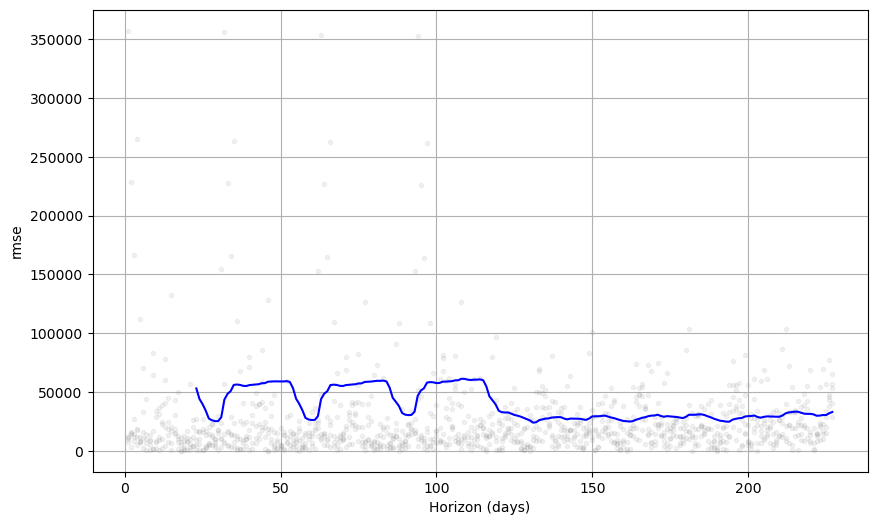

In [147]:
plt.figure(figsize=(14, 8))
fig = plot_cross_validation_metric(df_cv, metric='rmse')
plt.show()

This function generates a plot to visualize the performance of the Prophet model during the cross-validation process, focusing on the specified evaluation metric (**RMSE** in this case).

- **X-Axis**: The forecast horizon (how many days into the future the prediction is made).
- **Y-Axis**: The RMSE values for forecasts at different horizons.
- **Grey points**: Represent individual forecast errors for each horizon, showing the variability in the RMSE at each horizon length.
- **The blue line**: is the smoothed average RMSE, highlighting the general trend across forecast horizons. The default moving average is a rolling window of **10%** of the total forecast horizon range, which is **22.7 days** in this case.
- **Purpose**:
  - To evaluate how the accuracy of the model changes as the forecast horizon increases.
  - It helps identify if the model performs well for short-term forecasts but struggles for longer horizons.
  
#### Summary of the Cross-Validation RMSE Results
The cross-validation RMSE plot provides the following insights:

1. **Short-Term Peaks at ~30-Day Intervals**:
   - These periodic spikes are not solely caused by New Year's Day (01 January) but likely reflect monthly seasonality, other holidays, and specific anomalies in sales patterns.
   - The residual effects of extreme events, such as holidays or promotions, may propagate into forecasts for subsequent periods.
<br><br>
2. **Stabilization Beyond 125 Days**:
   - RMSE stabilizes for long-term forecasts, suggesting the model's seasonality and trend components effectively capture extended patterns.
   - This highlights the model's robustness for longer horizons.
<br><br>
3. **Residual Impact of 01 January**:
   - While New Year's Day contributes significantly to short-term errors, it is not the sole driver of the observed spikes.
   - Other events or holidays may also need to be better accounted for in the model.

#### Overall Insight:
The model performs consistently for long-term forecasts, but the short-term RMSE spikes indicate challenges in capturing extreme outliers and their residual effects. Further refinements, such as adding additional holiday or event-specific regressors, may help address these short-term forecasting issues.

#### Run the model with holiday information and best hyperparameters

The model will now be run with holiday information and best hyperparamerters chosen from the grid search to evaluate if the accuracy improves.

**Create an instance of the model with the holiday data and best hyperparameters**

In [148]:
# Create an instance of the model with the best hyperparameters and add the holiday data to it
pr5 = Prophet(
    holidays=ecuador_holidays_df,
    changepoint_prior_scale=best_parameters['changepoint_prior_scale'], 
    seasonality_prior_scale=best_parameters['seasonality_prior_scale'],
    holidays_prior_scale=best_parameters.get('holidays_prior_scale'),
    seasonality_mode=best_parameters.get('seasonality_mode'),
    n_changepoints=best_parameters.get('n_changepoints'),
    yearly_seasonality=best_parameters.get('yearly_seasonality'),  
    weekly_seasonality=best_parameters.get('weekly_seasonality')
)

# Add the regressors to the model
pr5.add_regressor('first_weekend_of_month', mode='multiplicative')
pr5.add_regressor('first_weekend_after_15th', mode='multiplicative')
pr5.add_regressor('dcoilwtico')
#pr5.add_regressor('onpromotion')
#pr5.add_regressor('LogOfPromotion')
pr5.add_regressor('earthquake_1_day_after')
pr5.add_regressor('eq_2_days_after')
pr5.add_regressor('eq_3_days_after')
pr5.add_regressor('eq_4_days_after')
pr5.add_regressor('eq_5_days_after')
pr5.add_regressor('eq_6_days_after')
pr5.add_regressor('is_1st_day_non_weekend_excl_jan')
pr5.add_regressor('is_28_december')

**Train the model**

In [149]:
# Train the model
pr5.fit(df_train5)

13:11:54 - cmdstanpy - INFO - Chain [1] start processing
13:11:54 - cmdstanpy - INFO - Chain [1] done processing


**Make a future data frame and predict the future sales**

In [150]:
# Make a future data frame for the number of specified days. 
# This is seven and a half months
future5 = pr5.make_future_dataframe(periods=num_days)

# Merge the regressor columns onto the future dataframe.
# Note: if they are commented out above, they will not be active even though they are included here.
future5 = future5.merge(dfp[['ds', 'first_weekend_of_month', 'first_weekend_after_15th', 'dcoilwtico', 
                             'onpromotion', 'LogOfPromotion', 'earthquake_1_day_after', 'eq_2_days_after', 
                             'eq_3_days_after', 'eq_4_days_after', 'eq_5_days_after', 'eq_6_days_after', 
                            'is_1st_day_non_weekend_excl_jan', 'is_28_december']], 
                        on='ds', 
                        how='left')

In [151]:
# Predict sales for the next two months
df_pred5 = pr5.predict(future5)

**Plot the forecast**

<Figure size 1400x800 with 0 Axes>

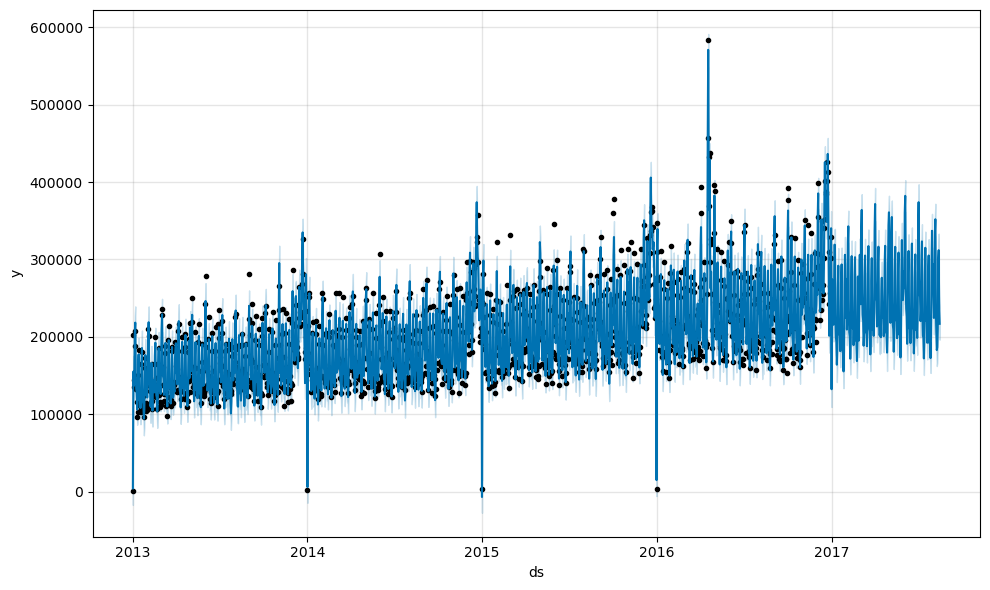

In [152]:
plt.figure(figsize=(14, 8)) 
fig1 = pr5.plot(df_pred5)
plt.show()

Tuning the hyperparameters has improved the model's performance for New Year's Day, particularly by setting seasonality to multiplicative. However, predictions for the test set remain suboptimal, reinforcing the need for a specialized model to accurately handle New Year's Day sales.

**Plot the breakdown of the model's components**

<Figure size 1400x800 with 0 Axes>

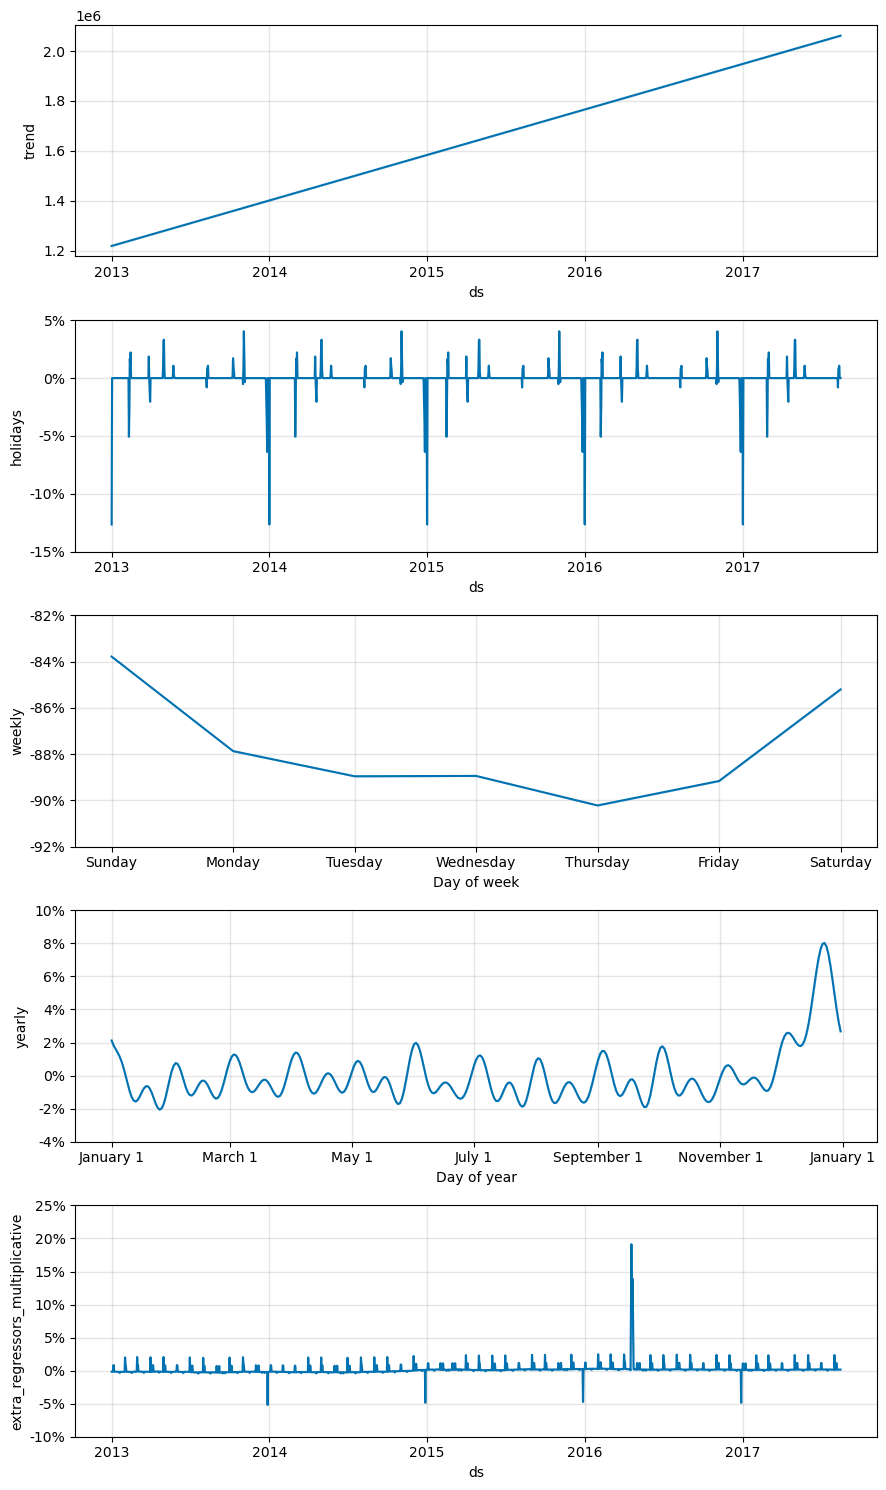

In [153]:
plt.figure(figsize=(14, 8))
pr5.plot_components(df_pred5)
plt.show()

#### Summary of Prophet Model 5 Components

1. **Trend**
    - The steady upward trend in sales from 2013 to 2017 shows a consistent increase in overall grocery sales.
<br><br>
2. **Holidays**  
   - Holiday effects reveal interesting insights. Some holidays boost sales, while others have a negative impact.  
   - **Key Observations**:  
     - **New Year’s Day (01 January)**: Sales drop to near zero as most stores are closed.  
     - **Carnaval**: Many stores are closed on the first day (around 11 February), but sales recover on the second day.  
     - **Independence Day for Cuenca and others**: These holidays show continued sales activity, suggesting that stores remain open.
     - **Christmas Day** was excluded from the original dataset as all stores are closed on that day.
<br><br>
3. **Weekly Seasonality**
    - Weekly sales patterns reveal the lowest activity on weekdays (especially Thursday) and the highest on weekends, particularly Sunday.
<br><br>
4. **Yearly Seasonality**
    - Peaks occur around the end of December and early January due to the holiday season, with periodic fluctuations throughout the year tied to specific annual events and payday.
    - With hyperparameter tuning, particularly for **yearly_seasonality**, this chart now captures yearly seasonality with sharper precision. Notably, peaks after payday at the start and middle of the month are now accurately captured.
<br><br>
5. **Extra Regressors (Multiplicative)**
    - This graph highlights the impact of additional regressors applied multiplicatively.
      - **Notable Spikes**: Events like the Manabí earthquake in 2016 are captured through significant upward spikes. The other positive spikes are less pronounced. They represent the first day of the month and the first weekend after payday, which occurs twice a month.
      - **Negative Spike**: After analysing the largest prediction errors of Model 3.1, 28 December was consistently over predicted in the training set. A regressor has been added for this date to correct this.
      - **Consistent Patterns**: Recurring events such as payday weekends or promotions are represented by smaller, regular fluctuations.
      - **Negative Dips**: This is due to the extra regressor to better account for lower sales on 28 December as was originally forecast.
      - **Oil prices**: The slight, continuous change in oil prices is visible in the chart, but its minimal fluctuations compared to other regressors indicate that its overall effect on grocery sales is almost negligible. This suggests oil prices are not a key driver of daily sales in this context. 
<br><br>
6. **Extra Regressors (Additive)**
    - Removed during hyperparameter tuning.
    - The adoption of a multiplicative seasonality mode, in combination with optimized parameters, was found to result in more accurate predictions.
  
**Key Insights**:   
- The addition of extra regressors greatly improves the model's ability to account for both regular and irregular external factors, providing a better understanding of unique sales patterns.
- Hyperparameter tuning significantly improved the model's ability to reflect sharp seasonal patterns This enhancement emphasizes the importance of fine-tuning parameters for a more precise understanding of unique sales behaviours.

**Filter the Predicted Test Set and Merge the Actual Sales Values to it**

In [154]:
# Prophet has predicted for the entire training set plus the additional 227 days in the test set.
# Filter out the test set.
df_test5 = df_pred5[df_pred5['ds'] >= test_start_date] 

In [155]:
# Convert 'ds' to datetime in both dataframes to ensure consistency
df_test5.loc[:, 'ds'] = pd.to_datetime(df_test5['ds'])
dfp['ds'] = pd.to_datetime(dfp['ds'])

**Merge the actual sales values to the predicted test set**

In [156]:
df_test5 = df_test5.merge(dfp[['ds', 'y']], on='ds', how='left')

#### Plot and Analyze the Forecast

**Merge the predictions with the actual data**

In [157]:
# Merge predictions with actual data over the entire dataset
df_pred5_long = df_pred5.merge(dfp[['ds', 'y']], on='ds', how='left')

# Create a plot dataset showing the last two years of the predictions.
# This comprises both the train and test set.
df_pred5_plt = df_pred5_long[df_pred5_long['ds'] >= '2015-08-15']

#### Plot Predicted vs. Actual Sales
This code overlays the predicted sales values on top of the actual sales data to visually evaluate the model's performance.

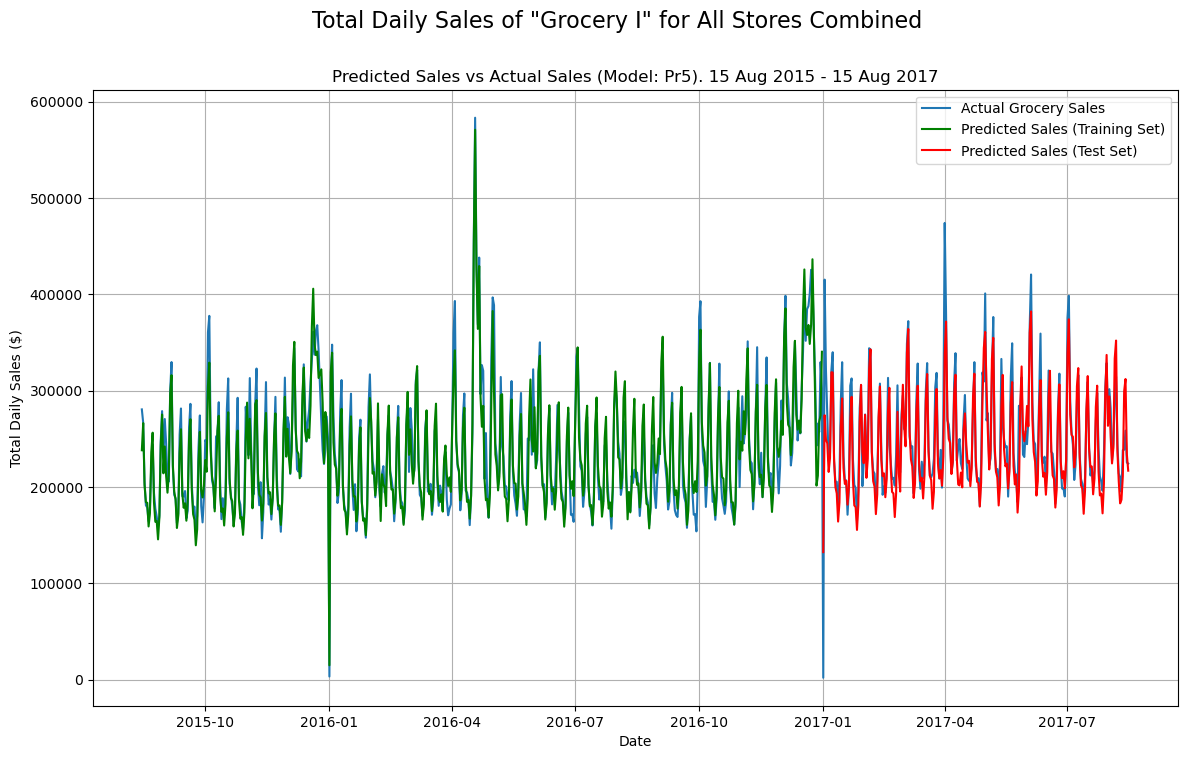

In [158]:
model_name = 'Pr5'
plot_train_set(test_start_date, df_pred5_plt, model_name)

Careful observation is required in this plot, but there is an overall slight improvement in the prediction accuracy compared to Model 3.1 (shown below for easy comparison). In particular, the accuracy of predicting the peaks and troughs in the test set has improved.

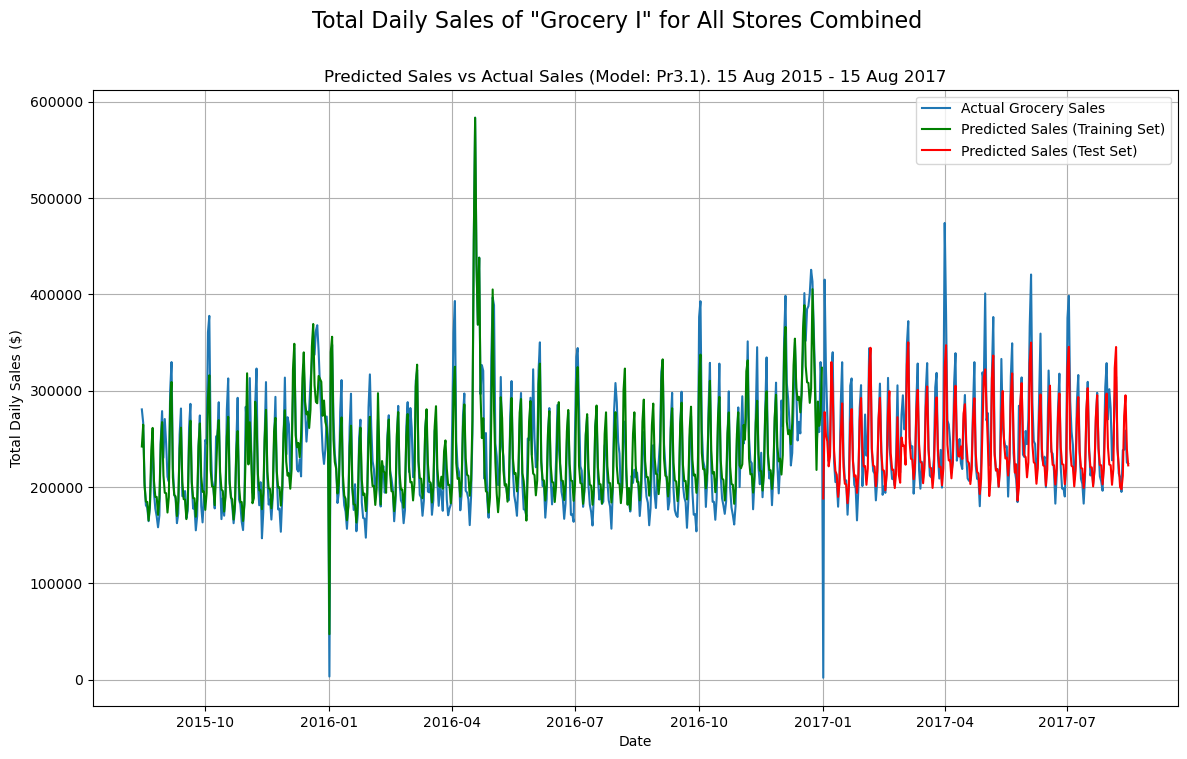

In [159]:
plot_train_set(test_start_date, df_pred3_plt, 'Pr3.1')

#### Calculate Performance Metrics for the Training Set: Model Pr5   
Note these figures are for the entire four years of the training set, not just the green period displayed above.

In [160]:
df_train5.tail()

ds           y  first_weekend_of_month  first_weekend_after_15th  \
1452 2016-12-27  242792.095                       0                         0   
1453 2016-12-28  265759.513                       0                         0   
1454 2016-12-29  257006.744                       0                         0   
1455 2016-12-30  329599.654                       0                         0   
1456 2016-12-31  302232.811                       0                         0   

      dcoilwtico  onpromotion  LogOfPromotion  earthquake_1_day_after  \
1452   52.820000   105.574074        4.668840                       0   
1453   54.010000   118.703704        4.785020                       0   
1454   53.800000   116.629630        4.767541                       0   
1455   53.750000   119.277778        4.789804                       0   
1456   53.518333   116.685185        4.768013                       0   

      eq_2_days_after  eq_3_days_after  eq_4_days_after  eq_5_days_after  \
1452                0                0                0                0   
1453                0                0                0                0   
1454                0                0                0                0   
1455                0                0                0                0   
1456                0                0                0                0   

      eq_6_days_after  is_1st_day_non_weekend_excl_jan  is_28_december  
1452                0                                0               0  
1453                0                                0               1  
1454                0                                0               0  
1455                0                                0               0  
1456                0                                0               0

In [161]:
# Prophet has predicted for the entire training set plus the additional 227 days in the test set.
# Filter for training data only, before the cutoff date of 2017-01-01
df_train5 = df_pred5[df_pred5['ds'] < test_start_date]

# Merge the actual sales values to the predicted test set
df_train5 = df_pred5[['ds', 'yhat']].merge(dfp, on='ds', how='left')

In [162]:
rmse_trn5, mae_trn5, mape_trn5, accuracy_trn5 = calculate_metrics(df_train5)

In [163]:
# Print the performance metrics
print(f'{"RMSE:":<{label_width}} {round(rmse_trn5, 2):<{value_width}}')
print(f'{"MAE:":<{label_width}} {round(mae_trn5, 2):<{value_width}}')
print(f'{"MAPE:":<{label_width}} {round(mape_trn5, 2)}%')
print(f'{"Accuracy:":<{label_width}} {round(100 - mape_trn5, 2)}%')

RMSE:      18190.09       
MAE:       12449.73       
MAPE:      10.61%
Accuracy:  89.39%


**Comparison to Training Set Metrics of Model Pr3.1**

- **RMSE (Root Mean Square Error):** Improved substantially, dropping from **22,418** to **18,190**.
- **MAE (Mean Absolute Error):** Reduced significantly from **16,197** to **12,449**.
- **MAPE (Mean Absolute Percentage Error):** Decreased significantly from **12.47%** to **10.61%**.

These improvements highlight the effectiveness of hyperparameter tuning through a comprehensive grid search and cross-validation process. The optimized parameters have significantly enhanced the model’s performance on the training set. The next step is to validate these results on the test set.

#### Create a Model for New Year's Day Only and Merge with Pr5  

As demonstrated on the training set, the RMSE and MAE improved compared to Model Pr2.2 but the MAPE became less accurate. Imputing the New Year's Day prediction with the value produced in the separate model will improve this.

**Create a prophet model for New Year's Day**   
This will add an improved prediction for New Year's Day to the test set by modelling New Year's Day separately from the other data. It will replace the previously predicted value for 01 January in the test set.

13:11:57 - cmdstanpy - INFO - Chain [1] start processing
13:11:57 - cmdstanpy - INFO - Chain [1] done processing


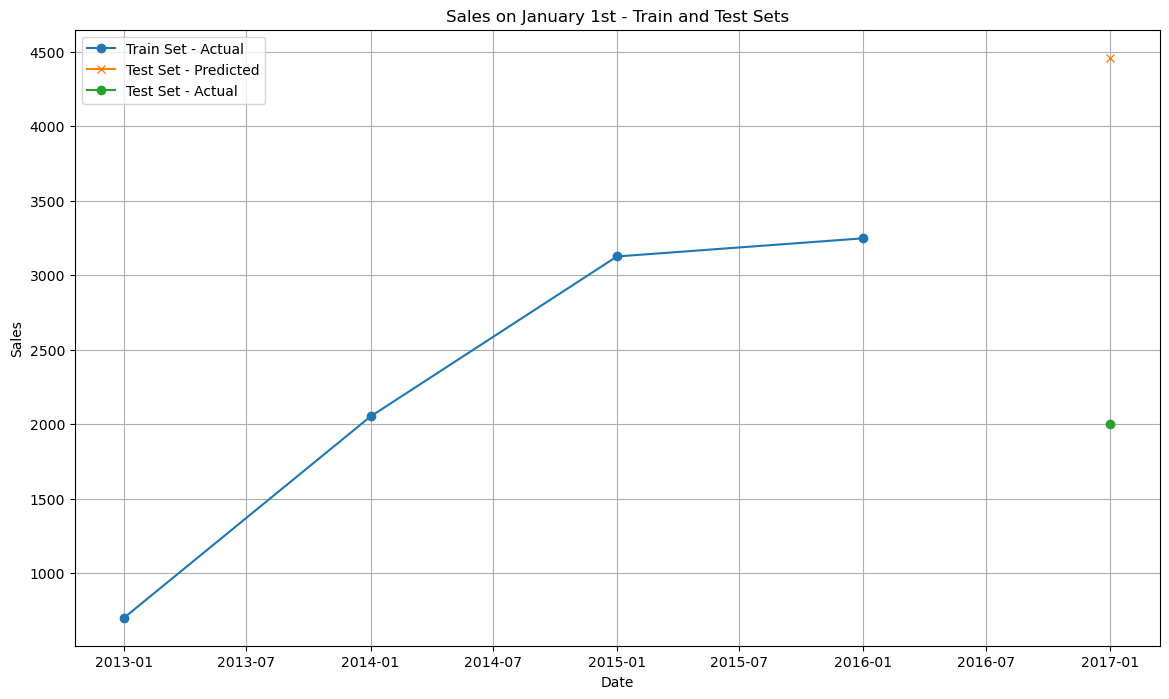

In [164]:
df_test5 = model_new_years_day_prophet(df_train, df_test5)

As observed above, the actual sales value for 01 January 2017 is **\\$2,000**, while the historical trend suggests an upward trajectory, leading the model to forecast nearly **\\$4,500**. Although this represents a significant error, it is a notable improvement compared to **Model Pr3.1**, which predicted an inflated value of approximately **\\$190,000** for the same date. While the error in the chart above could be considered large, it is an enormous improvement and the adjustments made in this model drastically improve the accuracy in the overall modelling results. 

**Plot the test set predictions in more detail**

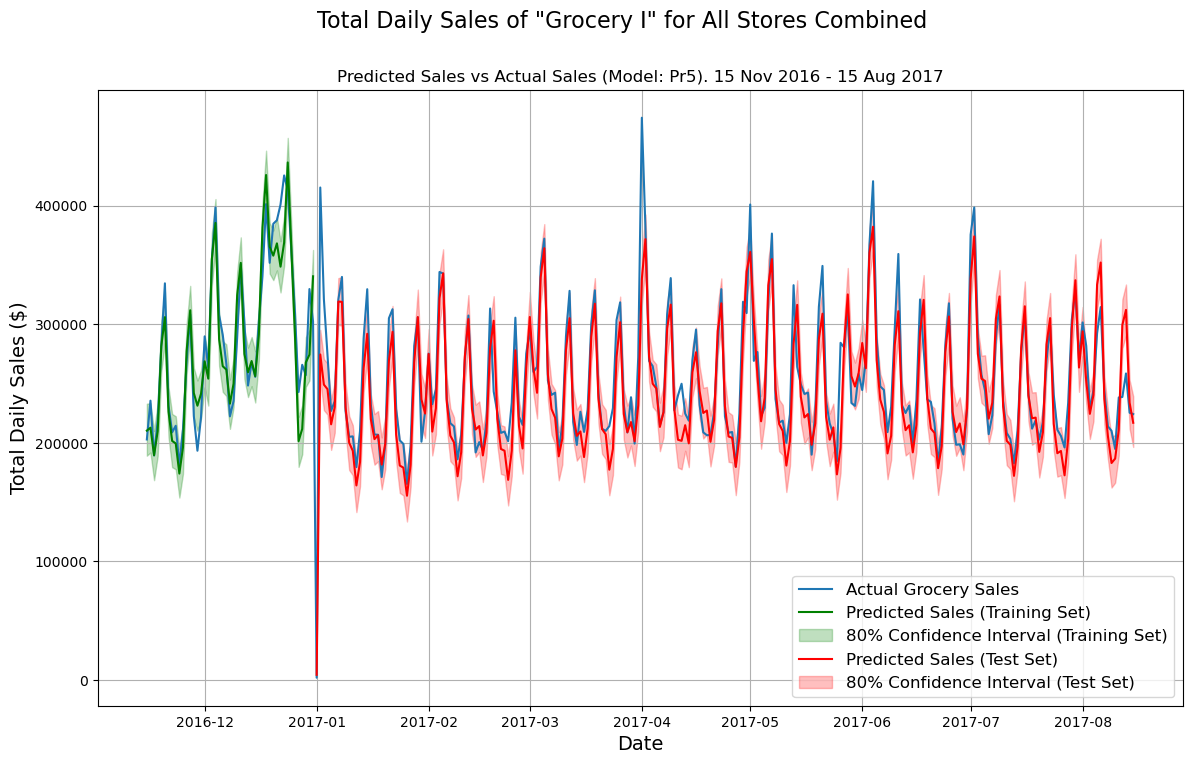

In [165]:
plot_test_set('Pr5', df_pred5_plt, df_test5)

Comparing this chart to the performance of Model 3.1 (shown below for reference), Model 5 demonstrates slight overall improvements, particularly in the training set. In the test set, the predicted peaks and troughs align more closely with the actual values, highlighting better accuracy in capturing sales patterns. While some areas show minor degradation, the overall performance indicates a net improvement.

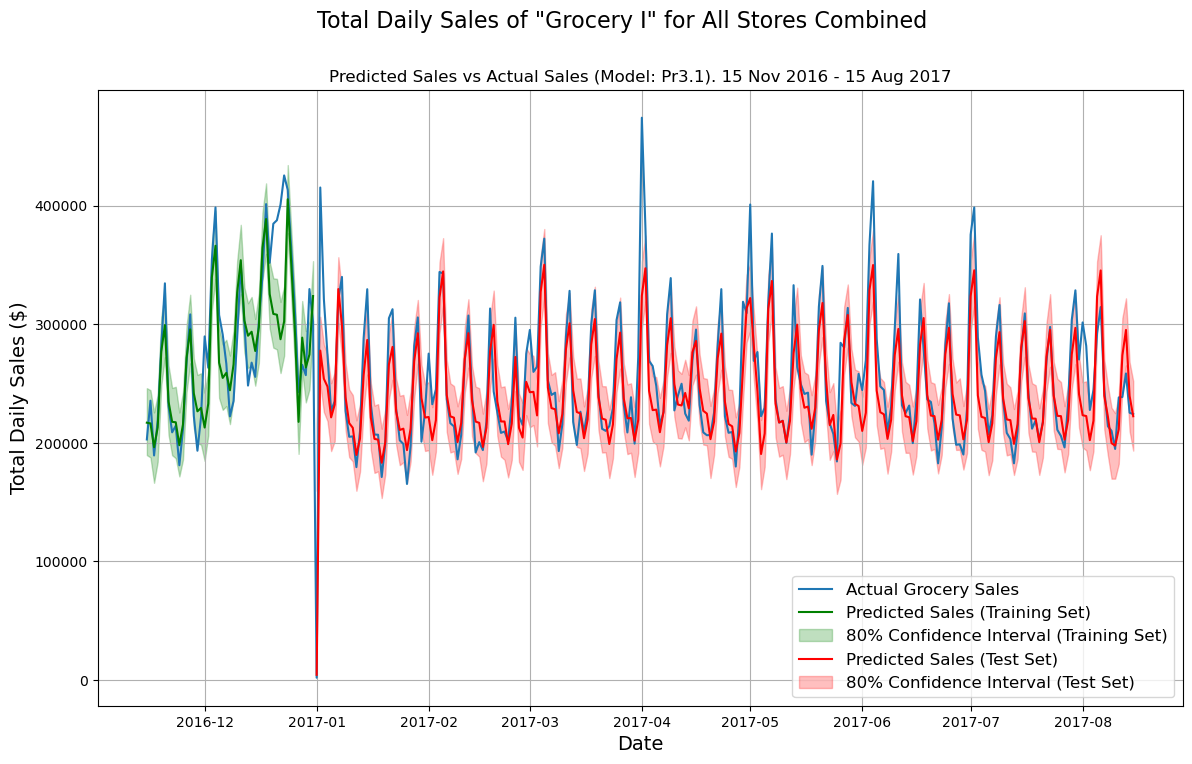

In [166]:
plot_test_set('Pr3.1', df_pred3_plt, df_test3)

#### Calculate Performance Metrics for the Test Set: Model Pr5 

This is predicted for the specified number of days after the cutoff of the train set. From 01 January 2017 to 15 August 2017.

The previous results show how well the model fits to the data it was trained on. The real test for a model is to determine how well it predicts on unseen data, which is what is done below.

In [167]:
rmse_pr5, mae_pr5, mape_pr5, accuracy_pr5 = calculate_metrics(df_test5)

In [168]:
# Print the performance metrics
print(f'{"RMSE:":<{label_width}} {round(rmse_pr5, 2):<{value_width}}')
print(f'{"MAE:":<{label_width}} {round(mae_pr5, 2):<{value_width}}')
print(f'{"MAPE:":<{label_width}} {round(mape_pr5, 2)}%')
print(f'{"Accuracy:":<{label_width}} {round(100 - mape_pr5, 2)}%')

RMSE:      24679.15       
MAE:       16990.55       
MAPE:      7.03%
Accuracy:  92.97%


#### Comparison to Test Set Metrics of Model Pr3.1

- **RMSE (Root Mean Square Error):** Notable improvement, reduced from **28,133** to **24,679**.
- **MAE (Mean Absolute Error):** Significant improvement, decreasing from **19,644** to **16,990**.
- **MAPE (Mean Absolute Percentage Error):** Substantial improvement, reduced from **7.76%** to **7.03%**.

While the improvements in the test set are less pronounced compared to the training set, they demonstrate the effectiveness of hyperparameter optimization through cross-validation in enhancing model performance. This is a very important step in the modelling process.

---

## <span style="color: darkblue;">6. Summary of Results</span>

### Summary of Methodology

This project utilized Facebook Prophet, an open-source tool for time-series forecasting, to predict grocery sales in Ecuador's Favorita supermarkets. The primary goal was to iteratively improve model accuracy by addressing specific data challenges and incorporating meaningful features, ensuring systematic refinement of model performance.

Key steps included:
- **Incorporating Holiday Effects**: Accounting for significant sales fluctuations during holidays to improve predictions. Holidays like New Year’s Day, with near-zero sales, were modelled separately to address extreme outliers effectively.
- **Adding Regressors**: External events such as the Manabí earthquake and recurring patterns like payday weekends were modelled with dedicated regressors to better capture their impact on sales.
- **Outlier Handling**: Extreme outliers, such as New Year’s Day, were modelled separately, while high-error dates in the training set were identified and addressed with additional regressors, reducing both training and test set errors.
- **Seasonality Modes**: Leveraging additive and multiplicative seasonality modes to capture complex sales behaviours, including the sharper yearly seasonality observed after hyperparameter tuning.
- **Hyperparameter Optimization**: A carefully chosen cross-validation process (defining the initial, period, and horizon parameters) was used to tune key hyperparameters systematically. This enhanced the model’s ability to generalize to unseen data, leading to significant improvements in metrics.

This structured approach enabled the models to evolve iteratively, capturing trends, seasonality, and anomalies with greater precision while addressing specific patterns and challenges in the data. The final model provided robust and accurate forecasts for grocery sales across all stores.

--- 

### Model Summary

#### Prophet Model 1: Baseline Model
- **Objective**: Establish a baseline for forecasting grocery sales using default settings.
- **Key Outcomes**:
  - Captured general seasonality and trend components.
  - Struggled with extreme values and holidays, especially New Year’s Day.
- **Performance (Test Set)**:
  - **RMSE**: 41,012.7
  - **MAE**: 24,738.0
  - **MAPE**: 81.5%
  - **Accuracy**: 18.5%


#### Prophet Model 2.1: Incorporating Holidays
- **Objective**: Address significant inaccuracies in sales predictions during holidays, particularly New Year’s Day.
- **Additions**:
  - Incorporated Ecuadorian holiday data with windows of influence (one day before and two days after most holidays).
  - Treated New Year’s Day as a unique holiday with no influence window due to near-zero sales.
- **Key Outcomes**:
  - Improved predictions for holidays, reducing RMSE and MAPE significantly compared to the baseline model.
  - However, errors persisted for New Year’s Day, where sales are near zero.
- **Performance (Test Set)**:
  - **RMSE**: 33,199.8
  - **MAE**: 21,876.6
  - **MAPE**: 40.2%
  - **Accuracy**: 59.8%


#### Prophet Model 2.2: Model with New Year's As A Multiplicative Holiday
- **Objective**: Further refine holiday predictions by treating New Year’s Day as a multiplicative holiday.
- **Additions**:
  - Excluded **New Year's Day** from additive holiday list to treat it as multiplicative holidays.
  - Added binary flags for this holiday as regressors.
- **Key Outcomes**:
  - Improved predictions for New Year's Day, reducing RMSE significantly and MAPE substantially compared to the previous model.
  - However, large errors persisted for New Year’s Day, where sales are near zero.
  - As the performance of Model 2.3 was far better, New Year's Day was reverted back to an additive holiday.
- **Performance (Test Set)**:
  - **RMSE**: 32,534.5
  - **MAE**: 21,782.7
  - **MAPE**: 25.66%
  - **Accuracy**: 74.34%


#### Prophet Model 2.3: New Year's Day Only Model
- **Objective**: Improve accuracy for near-zero sales on New Year’s Day using a dedicated model.
- **Additions**:
  - Create a standalone Prophet model specifically for **New Year's Day** to handle its unique sales pattern.
  - Replace the **01 January** predictions in **Model 2.2** with outputs from this specialized model.
- **Key Outcomes**:
  - Vastly improved predictions for New Year's Day, reducing RMSE slightly and MAPE enormously compared to the previous model.
- **Performance (Test Set)**:
  - **RMSE**: 31,729.6
  - **MAE**: 21,238.8
  - **MAPE**: 8.28%
  - **Accuracy**: 91.72%


#### Prophet Model 3.1: Additional Regressors for Oil Prices, Earthquake Impact and Payday Weekends
- **Objective**: Account for major outliers and recurring patterns to improve model accuracy.
- **Additions**:
  - Add a specific regressor for the continuous oil price variable.
  - Add specific regressors to account for the sales impact of the **Manabí Earthquake** and its aftermath, rather than relying on imputation.
  - Include regressors for payday-related spikes, that consistently occur on the first weekends after the **1st** and **15th** of each month.
- **Key Outcomes**:
  - Significant improvement in all metrics.
  - Including oil prices alone yielded only a marginal improvement in model performance. Additionally, its practical applicability is limited, as future oil prices are difficult to forecast with certainty, especially in the longer term.
- **Performance (Test Set)**:
  - **RMSE**: 28,133.3
  - **MAE**: 19,643.9
  - **MAPE**: 7.76%
  - **Accuracy**: 92.24%


#### Prophet Model 3.2: Additional Regressors for Key Dates with High Prediction Error
- **Objective**: After additional analysis of training set prediction error, key dates were identified as areas of improvement.
- **Additions**:
  - A regressor for the **first day of the month** was added as this was often significantly underpredicted.
  - A regressor for **28 of December** was added as this was often significantly overpredicted.
- **Key Outcomes**:
  - Significant improvement in all metrics.
- **Performance (Test Set)**:
  - **RMSE**: 26,952.3
  - **MAE**: 18,853.5
  - **MAPE**: 7.49%
  - **Accuracy**: 92.51%


#### Prophet Model 4: Scaling Non-Binary Regressors
- **Objective**: Enhance model optimization by standardizing non-binary regressors to ensure consistent influence during training.
- **Additions**:
  - Standardization and evaluation of all continuous variables. This is to ensure all regressors are treated with equal weight in the modelling process.
- **Key Outcomes**:
  - Standardizing non-binary regressors yielded no change in performance. This step was excluded from the final model.
- **Performance (Test Set)**:
  - **RMSE**: 26,955.3
  - **MAE**: 18,852.6
  - **MAPE**: 7.49%
  - **Accuracy**: 92.51%
- **Outcome**: Standardizing non-binary regressors yielded performance degradation and was ultimately excluded from the final model.


#### Prophet Model 5: Cross-Validation and Hyperparameter Optimization
- **Objective**: Use Model 3.2 and optimize key hyperparameters through cross-validation to improve overall model performance.
- **Additions**:
  - Developed an extensive grid-search strategy to fine-tune hyperparameters.
  - Carefully selected cross-validation parameters to ensure a balance between training data availability and evaluation of future prediction accuracy.
- **Key Outcomes**:
  - Significant improvement in all metrics.
- **Performance (Test Set)**:
  - **RMSE**: 24,679.2
  - **MAE**: 16,990.6
  - **MAPE**: 7.03%
  - **Accuracy**: 92.97%

---

### Summary of Model Evolution

| **Model**  | **RMSE**     | **MAE**       | **MAPE**   | **Accuracy (%)** | **Key Additions**                                                |
|------------|--------------|---------------|------------|------------------|--------------------------------------------------------------------|
| **Pr1**    | 41,012.7    | 24,738.0     | 81.51%      | 18.49%            | Baseline model with general seasonality and trend components.      |
| **Pr2.1**  | 33,199.8    | 21,876.6     | 40.20%      | 59.80%            | Incorporated holiday effects into the model.                       |
| **Pr2.2**  | 32,534.50    | 21,782.7     | 25.66%     | 74.34%           | Treated New Year’s as a multiplicative holiday. Not implemented as Pr2.3's solution was far better.                    |
| **Pr2.3**  | 31,729.6    | 21,238.8     | 8.28%      | 91.72%           | Created a separate model for New Year’s Day.                       |
| **Pr3.1**  | 28,133.3    | 19,643.9     | 7.76%      | 92.24%           | Added regressors for oil prices, weekends after payday and the outlier impact of the earthquake.        |
| **Pr3.2**  | 26,952.3    | 18,853.5     | 7.49%      | 92.51%           | Added regressors for the 1st day of the month and 28 December.     |
| **Pr4**    | 26,955.3    | 18,852.6     | 7.49%      | 92.51%           | Scaled non-binary regressors for consistent influence. This had no effect so was not implemented.             |
| **Pr5**    | 24,679.2    | 16,990.6     | 7.03%      | 92.97%           | Applied cross-validation and hyperparameter tuning.                   |

---

### Key Takeaways
1. **Holiday Effects**: Incorporating holiday-specific data significantly enhanced the model's ability to accurately predict sales fluctuations during holidays, such as Carnaval and New Year’s Day.
<br><br>
2. **Outlier Handling**: 
   - Modelling **New Year’s Day** separately dramatically improved accuracy for extreme outliers with near-zero sales.
   - Treating earthquake-related sales impacts as regressors, rather than relying on imputation, effectively captured these unique anomalies and improved model performance.
<br><br>
3. **Payday Effects**: Adding regressors for the first day of the month and weekends immediately following payday (1st and 15th) significantly enhanced the model's ability to predict recurring sales spikes, leading to better overall accuracy.
<br><br>
4. **Addressing Patterns of Consistently High Prediction Errors**: By identifying dates with consistent high prediction errors in the training set, additional targeted regressors were introduced. These adjustments reduced errors for problematic dates, resulting in improved performance on the test set.
<br><br>
5. **Hyperparameter Optimization**: 
   - Cross-validation fine-tuned the model’s hyperparameters, such as changepoint prior scale and seasonality mode, enabling better generalization to unseen data.
   - Carefully selected cross-validation parameters (e.g., initial, period, and horizon) ensured a robust evaluation and further boosted the model's predictive power.
<br><br>
6. **Practicality**: 
   - Prioritize essential regressors and clearly identifiable patterns to ensure robust and actionable predictions.
   - Avoid reliance on regressors (e.g., oil prices) that are challenging to forecast accurately in real-world scenarios and have a negligible impact on the model’s performance.


## <span style="color: darkblue;">7. Conclusion</span>

This project demonstrates a comprehensive and practical approach to time-series forecasting using Facebook Prophet to predict grocery sales in Ecuador's Favorita supermarkets. By focusing on the "Grocery I" product family, the project emphasized iterative refinement through feature engineering, the incorporation of external factors, and hyperparameter optimization to improve accuracy.

**Key findings include:**
- **Holiday Effects**: Treating New Year’s Day as a unique case and integrating holiday data enhanced the model’s ability to handle extreme outliers and improve predictive performance during holidays.
- **Outlier and Anomaly Handling**: Regressors for events like the Manabí earthquake and payday weekends effectively captured unique sales patterns, reducing errors and improving accuracy.
- **Hyperparameter Optimization**: Cross-validation and systematic tuning of key parameters balanced model complexity with generalization to unseen data, enhancing overall performance.
- **Seasonality and Recurring Patterns**: Prophet’s flexibility in managing weekly, monthly, and yearly seasonality, as well as payday-related effects, addressed complex and recurring patterns in sales data.

This work underscores the effectiveness of Prophet when carefully tuned, showcasing its adaptability in addressing a range of forecasting challenges, including holidays, seasonality, and irregular events. The project highlights how combining domain knowledge, advanced forecasting techniques, and open-source tools can provide actionable insights, optimize operations, and solve real-world business problems.

Future directions include exploring other algorithms such as XGBoost and neural networks such as LSTM (Long-Short Term Memory), to compare to their performance of this dataset. Additionally, modelling other sales categories with more irregular patterns is seen as an exciting challenge that offers opportunities for further learning and development.